### Conexao SQL codigo

In [ ]:
import pyodbc

In [ ]:
 conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    ('SERVER={server},{port};'   +
     'DATABASE={database};'      +
     'UID={username};'           +
     'PWD={password}').format(
            server= '25.110.216.28',
              port= 1433,
          database= 'DataStage',
          username= 'leticia',
          password= 'leticia')
)
    
cursor = conn.cursor()
cursor.execute('select top 10 NUMCONTACORRENTE, SUM(VALORLANC) TOTAL from DataStage.tce.LANCAMENTOCCO where IDTIPOHISTORICOLANC=680 group by NUMCONTACORRENTE')
resultado = cursor.fetchall()

In [ ]:
print(list(resultado))

In [ ]:
for row in cursor:
    print(row)

In [ ]:
resultado_lista = [list(item) for item in resultado]

### Lendo DataFrames

In [ ]:
import pandas as pd

In [ ]:
df =  pd.DataFrame(resultado_lista)

In [ ]:
display(df)

#### Features: info dos clientes fisicos (todos)
#### Labels: valores de ADP para os que precisaram

In [ ]:
features = pd.read_csv('entradas.csv', sep = ';', names = ['idcliente', 'prof', 'sexo','estcivil','vincemp','bairro','cidade','valorreceita','idade','dependentes'])
labels = pd.read_csv('resultado_adp.csv', sep = ';',names = ['numconta', 'idcliente','valor'])


In [ ]:
display(features)
display(labels)


print(len(features.idcliente))

print(len(set(features.idcliente)))
print(len(set(labels.idcliente)))

In [ ]:
print(features)

#### Concat right: mantem todos os clientes fisicos. Os que nao tem ADP poe zero

In [ ]:
result = pd.merge(labels,features, on = 'idcliente', how = 'right')

In [ ]:
result.columns


In [ ]:
result.valor = result.valor.fillna(0)
result.corr(method ='pearson')



In [ ]:
display(result)

### Testando um modelo simples de regressao

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

y = result.valor
X = result.drop(columns=['numconta','idcliente','valor'])
colunas = X.columns
le = preprocessing.LabelEncoder()


# display(X)

X.prof = le.fit_transform(X.prof)
X.sexo = le.fit_transform(X.sexo)
X.estcivil = le.fit_transform(X.estcivil)
X.vincemp = le.fit_transform(X.vincemp)
X.bairro = X.bairro.fillna('a')
X.bairro = le.fit_transform(X.bairro)
X.cidade = X.cidade.fillna('a')
X.cidade = le.fit_transform(X.cidade)

X = scaler.fit_transform(X)

In [ ]:
display(X)
display(y)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X, y)

In [ ]:
regr.score(X,y)

#### importando dados select daniel

In [ ]:
dados_daniel_novo = pd.read_csv('somaADPxRendaBruta-2015-2019/somaADPxRendaBruta-2019.csv')

In [ ]:
display(dados_daniel_novo)

### Voltando ao dataframe anterior que foi usado pra treinar o modelo

In [ ]:
resultado_corr = pd.concat([pd.DataFrame(X, columns=colunas),y], axis=1)

In [ ]:
print(X.shape)
display(resultado_corr)

### maiores correlacoes entre valor de adp e dados do cliente foram: estado civil, sexo, profissao, valor da receita bruta mensal e idade

In [ ]:
resultado_corr.corr()

### Refazendo o processo mas mantendo apenas colunas mais relevantes de X

In [ ]:
colunas

In [ ]:
X = pd.DataFrame(X, columns=colunas)
X = X.drop(columns = ['vincemp', 'cidade','bairro','dependentes'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X, y)

In [ ]:
regr.score(X,y)

# Tratando clientes com mais de uma renda

SELECT top 20000
    TCE.CLIENTEFISICA.IDCLIENTE,
    --TCE.INSTITUICAOCOOPERATIVA.IDINSTITUICAO IDINST,
    TCE.TIPOPROFISSAO.DESCTIPOPROFISSAO PROFISSAO,
    TCE.TIPOSEXO.DESCTIPOSEXO SEXO,
    TCE.ESTADOCIVIL.DESCESTADOCIVIL ESTADOCIVIL,
    TCE.VINCULOEMPREGATICIO.DESCVINCULOEMPREGATICIO VINCULOEMP,
	ENDERECOCLIENTE.NOMEBAIRRO BAIRRO,
	ENDERECOCLIENTE.NOMECIDADE CIDADE,
	TCE.FONTERENDA.VALORRECEITABRUTAMENSAL RECEITA,
	TCE.FONTERENDA.DATACADASTRO DATA_RECEITA,
	TCE.FONTERENDA.BOLRENDAFIXA RENDAFIXA,
	TCE.FONTERENDA.CODTIPOFONTERENDA CODIGORENDA,
    DATEDIFF(YY,TCE.CLIENTEFISICA.DATANASCIMENTO, GETDATE()) IDADE,
    TCE.CLIENTEFISICA.NUMDEPENDENTES DEPENDENTES

FROM
    TCE.CLIENTEFISICA
INNER JOIN
    TCE.TIPOPROFISSAO
ON
    TCE.CLIENTEFISICA.CODTIPOPROFISSAO = TCE.TIPOPROFISSAO.CODTIPOPROFISSAO
INNER JOIN
    TCE.TIPOSEXO
ON
    TCE.CLIENTEFISICA.CODTIPOSEXO = TCE.TIPOSEXO.CODTIPOSEXO
INNER JOIN
    TCE.ESTADOCIVIL
ON
    TCE.CLIENTEFISICA.CODESTADOCIVIL = TCE.ESTADOCIVIL.CODESTADOCIVIL
INNER JOIN
    TCE.VINCULOEMPREGATICIO
ON
    TCE.CLIENTEFISICA.CODVINCULOEMPREGATICIO = TCE.VINCULOEMPREGATICIO.CODVINCULOEMPREGATICIO
INNER JOIN
    TCE.INSTITUICAOCOOPERATIVA
ON
     TCE.CLIENTEFISICA.IDINSTITUICAO = TCE.INSTITUICAOCOOPERATIVA.IDINSTITUICAO

INNER JOIN (select * from TCE.ENDERECOCLIENTE where tce.ENDERECOCLIENTE.CODTIPOENDERECO = 0) as ENDERECOCLIENTE

on	TCE.CLIENTEFISICA.IDCLIENTE = ENDERECOCLIENTE.IDCLIENTE

INNER JOIN 
	TCE.FONTERENDA
ON 
	TCE.CLIENTEFISICA.IDCLIENTE = TCE.FONTERENDA.IDCLIENTE

group by tce.clientefisica.IDCLIENTE,
    TCE.TIPOPROFISSAO.DESCTIPOPROFISSAO,
    TCE.TIPOSEXO.DESCTIPOSEXO,
    TCE.ESTADOCIVIL.DESCESTADOCIVIL,
    TCE.VINCULOEMPREGATICIO.DESCVINCULOEMPREGATICIO,
	ENDERECOCLIENTE.NOMEBAIRRO,
	ENDERECOCLIENTE.NOMECIDADE,
	TCE.CLIENTEFISICA.NUMDEPENDENTES,
	tce.CLIENTEFISICA.DATANASCIMENTO,
	TCE.FONTERENDA.BOLRENDAFIXA,
	TCE.FONTERENDA.VALORRECEITABRUTAMENSAL,
	TCE.FONTERENDA.CODTIPOFONTERENDA,
	TCE.FONTERENDA.DATACADASTRO
    
order by tce.clientefisica.IDCLIENTE

In [10]:
novas_entradas = pd.read_csv('csvs/meus/inputs_correto_c_endereco.csv', sep=';',names = ['idcliente','prof','sexo','estcivilp','vincemp','bairro','cidade','valor','data','fixo','codtipoempr','idade','dependentes'])

In [ ]:
display(novas_entradas)

### Criando dicionario: chave = idcliente values=informacoes, pode ter mais de uma linha pois tem mais infos de renda

In [11]:
print(novas_entradas.columns)

Index(['idcliente', 'prof', 'sexo', 'estcivilp', 'vincemp', 'bairro', 'cidade',
       'valor', 'data', 'fixo', 'codtipoempr', 'idade', 'dependentes'],
      dtype='object')


In [12]:
id_cliente = list(novas_entradas.idcliente.unique()) # todas as contas que já foram ADP algum dia
lista_adp = []

dict_qtd = {}     
colunas_clientes = novas_entradas.columns

for num in id_cliente:

    a = novas_entradas.loc[novas_entradas.idcliente == num]
    a = a.values
    dict_qtd[num] = a
    
#     lista_adp.append(dict_qtd)

 

# with open('lista_adp.json','w') as json_file: # função para salvar os resultados em um arquivo json
#     json.dump(lista_adp, json_file)

Estrategia para juntar tudo em um cliente: 

rendas: somar todas as rendas

renda fixa: se tiver pelo menos uma renda fixa entre todas, considerar fixa

codigo tipo de renda: tornar varios booleanos? / ou definir uma  hierarquia entre tipos de renda, se a pessoa tem salario assume como fonte principal de renda

enderecos escritos diferentes: escolher um, mais recente

In [13]:
df_tratado = []

for item in dict_qtd.values():
    item = pd.DataFrame(item, columns = colunas_clientes)
#     print(item)
#     print(item.columns)
    #   IDCLIENTE VAI SER INDIFERENTE, PODE PEGAR QUALQUER LINHA
    idcliente = item.idcliente.iloc[0]
    
    # ESCOLHENDO DATA MAIS RECENTE PRA PEGAR INFOS
    
#     print('DATAS', item.data)
    item.data.fillna('0', inplace = True)
    data_mais_recente = sorted(item.data, reverse=True)[0]
    indice_data = item.data[item.data == data_mais_recente].index[0]
#     print(item)
#     print('INDICE', indice_data)
    
    # PEGANDO INFOS DATA MAIS RECENTE
    prof = item.prof.iloc[indice_data]
    sexo = item.sexo.iloc[indice_data]
    estcivilp = item.estcivilp.iloc[indice_data]
    vincemp = item.vincemp.iloc[indice_data]
#     bairro = item.bairro.iloc[indice_data]
#     cidade = item.cidade.iloc[indice_data]
    dependentes = item.dependentes.iloc[indice_data]
    idade = item.idade.iloc[indice_data]
    data = item.data.iloc[indice_data]
    cidade = item.cidade.iloc[indice_data]
    bairro = item.bairro.iloc[indice_data]
    
    # FALTA: FIXO, CODTIPEMP, VALOR
    
    # CODEMP 
#     print(item.valor)
    max_valor = sorted(item.valor, reverse=True)[0]
    indice_valor_max = list(item.valor[item.valor == max_valor].index)[0]
#     print('VALOR', max_valor)
    codtipoempr = item.codtipoempr.iloc[indice_valor_max]
    
    
    
    # FIXO
    vdd = any(item.fixo==1)
    fixo = vdd
#     print(item.valor)

#     print(indice_valor_max, '\n \n')
    print('##### CLIENTE', idcliente,' #####')
    print(item[['valor', 'codtipoempr', 'data']],'\n')
    print('MAXIMO', max_valor)
    print('CODPRINC',codtipoempr, '\n \n')

    valor = sum(item.valor)
        
    df_tratado.append([idcliente, prof, sexo, estcivilp, vincemp, bairro, cidade,
    valor, data, fixo, codtipoempr, idade, dependentes])

##### CLIENTE 76  #####
  valor codtipoempr                     data
0   800           0  2004-10-15 00:00:00.000 

MAXIMO 800.0
CODPRINC 0 
 

##### CLIENTE 170  #####
   valor codtipoempr                     data
0  413.6           0  2005-10-25 00:00:00.000 

MAXIMO 413.6
CODPRINC 0 
 

##### CLIENTE 182  #####
  valor codtipoempr                     data
0   380           0  2004-09-09 00:00:00.000 

MAXIMO 380.0
CODPRINC 0 
 

##### CLIENTE 254  #####
    valor codtipoempr                     data
0  505.25           0  2015-05-21 00:00:00.000 

MAXIMO 505.25
CODPRINC 0 
 

##### CLIENTE 328  #####
     valor codtipoempr                     data
0      710           0  2019-09-26 00:00:00.000
1  1690.83           6  2019-09-26 00:00:00.000 

MAXIMO 1690.83
CODPRINC 6 
 

##### CLIENTE 353  #####
  valor codtipoempr                     data
0     0          12  2017-03-17 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 368  #####
     valor codtipoempr                     d

     valor codtipoempr                     data
0  1268.33           6  2005-08-23 00:00:00.000
1     9000           6  2005-08-24 00:00:00.000 

MAXIMO 9000.0
CODPRINC 6 
 

##### CLIENTE 6134  #####
     valor codtipoempr                     data
0  2451.53           0  2003-09-22 00:00:00.000 

MAXIMO 2451.53
CODPRINC 0 
 

##### CLIENTE 6142  #####
  valor codtipoempr                     data
0  2000           1  2005-04-11 00:00:00.000 

MAXIMO 2000.0
CODPRINC 1 
 

##### CLIENTE 6173  #####
  valor codtipoempr                     data
0  2500           6  2002-12-17 00:00:00.000 

MAXIMO 2500.0
CODPRINC 6 
 

##### CLIENTE 6186  #####
     valor codtipoempr                     data
0  35201.1           1  2019-08-15 00:00:00.000
1    15000           1  2019-08-15 00:00:00.000
2  12959.1           1  2019-08-15 00:00:00.000 

MAXIMO 35201.09
CODPRINC 1 
 

##### CLIENTE 6191  #####
  valor codtipoempr                     data
0  2000           1  2006-11-09 00:00:00.000 

MAXIMO 2

CODPRINC 6 
 

##### CLIENTE 10049  #####
    valor codtipoempr                     data
0    1250           0  2019-06-24 00:00:00.000
1  1361.1           6  2019-06-24 00:00:00.000 

MAXIMO 1361.1
CODPRINC 6 
 

##### CLIENTE 10053  #####
  valor codtipoempr                     data
0   300           3  2003-07-28 00:00:00.000 

MAXIMO 300.0
CODPRINC 3 
 

##### CLIENTE 10073  #####
     valor codtipoempr                     data
0  11964.4           0  2019-05-10 00:00:00.000
1   208.33           6  2019-05-10 00:00:00.000 

MAXIMO 11964.39
CODPRINC 0 
 

##### CLIENTE 10075  #####
    valor codtipoempr                     data
0  357.62           1  2003-07-24 00:00:00.000 

MAXIMO 357.62
CODPRINC 1 
 

##### CLIENTE 10244  #####
    valor codtipoempr                     data
0  490072           9  2017-11-27 00:00:00.000 

MAXIMO 490072.15
CODPRINC 9 
 

##### CLIENTE 10265  #####
  valor codtipoempr                     data
0   724           3  2014-03-11 00:00:00.000 

MAXIMO 72

##### CLIENTE 13466  #####
  valor codtipoempr                     data
0  3500           8  2006-07-13 00:00:00.000 

MAXIMO 3500.0
CODPRINC 8 
 

##### CLIENTE 13503  #####
  valor codtipoempr                     data
0  1725           6  2008-02-06 00:00:00.000 

MAXIMO 1725.0
CODPRINC 6 
 

##### CLIENTE 13504  #####
     valor codtipoempr                     data
0  17568.8           6  2016-01-26 00:00:00.000 

MAXIMO 17568.78
CODPRINC 6 
 

##### CLIENTE 13506  #####
  valor codtipoempr                     data
0   890           6  2007-09-27 00:00:00.000 

MAXIMO 890.0
CODPRINC 6 
 

##### CLIENTE 13510  #####
  valor codtipoempr                     data
0   600           1  2005-07-25 00:00:00.000 

MAXIMO 600.0
CODPRINC 1 
 

##### CLIENTE 13563  #####
    valor codtipoempr                     data
0    1425           6  2019-09-06 00:00:00.000
1  952.58           1  2019-09-06 00:00:00.000 

MAXIMO 1425.0
CODPRINC 6 
 

##### CLIENTE 13565  #####
    valor codtipoempr       

CODPRINC 6 
 

##### CLIENTE 17202  #####
  valor codtipoempr                     data
0   300           6  2004-04-12 00:00:00.000 

MAXIMO 300.0
CODPRINC 6 
 

##### CLIENTE 17299  #####
    valor codtipoempr                     data
0  3147.6           6  2015-12-15 00:00:00.000 

MAXIMO 3147.6
CODPRINC 6 
 

##### CLIENTE 17305  #####
     valor codtipoempr                     data
0  9786.09           6  2014-10-27 00:00:00.000 

MAXIMO 9786.09
CODPRINC 6 
 

##### CLIENTE 17323  #####
  valor codtipoempr                     data
0  1875           1  2019-03-01 00:00:00.000 

MAXIMO 1875.0
CODPRINC 1 
 

##### CLIENTE 17325  #####
     valor codtipoempr                     data
0      954           1  2019-05-03 00:00:00.000
1  12404.4           6  2019-05-03 00:00:00.000
2  35158.5           0  2019-05-03 00:00:00.000 

MAXIMO 35158.47
CODPRINC 0 
 

##### CLIENTE 17358  #####
  valor codtipoempr                     data
0     0          12  2016-11-11 00:00:00.000 

MAXIMO 0.0
C

##### CLIENTE 23262  #####
     valor codtipoempr                     data
0  95253.1           9  2019-05-22 00:00:00.000
1      100           6  2019-05-22 00:00:00.000
2  14218.8           0  2019-05-22 00:00:00.000
3  7908.03           0  2019-05-22 00:00:00.000
4   958.33           1  2019-05-22 00:00:00.000 

MAXIMO 95253.06
CODPRINC 9 
 

##### CLIENTE 23297  #####
  valor codtipoempr                     data
0   800           6  2004-05-25 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 23324  #####
  valor codtipoempr                     data
0  1159           0  2015-01-08 00:00:00.000 

MAXIMO 1159.0
CODPRINC 0 
 

##### CLIENTE 23346  #####
     valor codtipoempr                     data
0  2076.38           0  2011-12-08 00:00:00.000 

MAXIMO 2076.38
CODPRINC 0 
 

##### CLIENTE 23371  #####
  valor codtipoempr                     data
0   760           0  2004-11-03 00:00:00.000 

MAXIMO 760.0
CODPRINC 0 
 

##### CLIENTE 23377  #####
  valor codtipoempr         

1   500           0  2003-04-02 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 25331  #####
    valor codtipoempr                     data
0  306.04           6  2007-04-03 00:00:00.000 

MAXIMO 306.04
CODPRINC 6 
 

##### CLIENTE 25334  #####
  valor codtipoempr                     data
0   500           6  2006-04-10 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 25373  #####
    valor codtipoempr                     data
0  1306.8           6  2018-08-28 00:00:00.000 

MAXIMO 1306.8
CODPRINC 6 
 

##### CLIENTE 25388  #####
     valor codtipoempr                     data
0  2697.25           0  2013-05-23 00:00:00.000 

MAXIMO 2697.25
CODPRINC 0 
 

##### CLIENTE 25620  #####
  valor codtipoempr                     data
0     0          12  2017-07-13 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 25709  #####
     valor codtipoempr                     data
0   220.83           6  2016-09-16 00:00:00.000
1     3000           6  2016-09-16 00:00:00.000
2 

6  10383.7           0  2019-07-18 00:00:00.000 

MAXIMO 10383.72
CODPRINC 0 
 

##### CLIENTE 31153  #####
  valor codtipoempr                     data
0  1100           0  2006-06-27 00:00:00.000 

MAXIMO 1100.0
CODPRINC 0 
 

##### CLIENTE 31158  #####
  valor codtipoempr                     data
0     0          12  2017-10-13 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 31160  #####
   valor codtipoempr                     data
0  10000           1  2012-08-17 00:00:00.000 

MAXIMO 10000.0
CODPRINC 1 
 

##### CLIENTE 31162  #####
    valor codtipoempr                     data
0  526.13           0  2004-10-15 00:00:00.000 

MAXIMO 526.13
CODPRINC 0 
 

##### CLIENTE 31163  #####
     valor codtipoempr                     data
0  1421.55           0  2004-10-18 00:00:00.000 

MAXIMO 1421.55
CODPRINC 0 
 

##### CLIENTE 31165  #####
    valor codtipoempr                     data
0  864.64           0  2004-10-13 00:00:00.000 

MAXIMO 864.64
CODPRINC 0 
 

##### CLIENTE 3

##### CLIENTE 37361  #####
  valor codtipoempr                     data
0   423           6  2005-05-12 00:00:00.000 

MAXIMO 423.0
CODPRINC 6 
 

##### CLIENTE 37464  #####
     valor codtipoempr                     data
0   727.22           6  2017-05-17 00:00:00.000
1  1335.32           6  2017-05-17 00:00:00.000
2  2609.22           3  2017-05-17 00:00:00.000 

MAXIMO 2609.22
CODPRINC 3 
 

##### CLIENTE 37556  #####
  valor codtipoempr                     data
0     0          12  2018-01-31 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 37576  #####
  valor codtipoempr                     data
0  1900           8  2017-08-28 00:00:00.000 

MAXIMO 1900.0
CODPRINC 8 
 

##### CLIENTE 37633  #####
     valor codtipoempr                     data
0  1646.75           8  2018-12-04 00:00:00.000 

MAXIMO 1646.75
CODPRINC 8 
 

##### CLIENTE 37894  #####
  valor codtipoempr                     data
0   500           1  2006-06-05 00:00:00.000 

MAXIMO 500.0
CODPRINC 1 
 

##### 

##### CLIENTE 39780  #####
     valor codtipoempr                     data
0  2226.98           4  2003-02-18 00:00:00.000
1  1632.94           3  2003-01-21 00:00:00.000 

MAXIMO 2226.98
CODPRINC 4 
 

##### CLIENTE 39791  #####
     valor codtipoempr                     data
0  1548.41           6  2016-04-08 00:00:00.000 

MAXIMO 1548.41
CODPRINC 6 
 

##### CLIENTE 39792  #####
     valor codtipoempr                     data
0  7076.23           9  2018-12-13 00:00:00.000
1     3.35           6  2018-12-13 00:00:00.000
2  8811.67           1  2018-12-13 00:00:00.000
3     22.8           6  2018-12-13 00:00:00.000
4  5155.17           1  2018-12-13 00:00:00.000
5   776.08           1  2018-12-13 00:00:00.000
6  17783.9           1  2018-12-13 00:00:00.000
7    67644           1  2018-12-13 00:00:00.000
8    61650           1  2018-12-13 00:00:00.000 

MAXIMO 67644.02
CODPRINC 1 
 

##### CLIENTE 39793  #####
  valor codtipoempr                     data
0  2200           0  2002-08-2


##### CLIENTE 41131  #####
     valor codtipoempr                     data
0  7066.24           0  2004-07-19 00:00:00.000 

MAXIMO 7066.24
CODPRINC 0 
 

##### CLIENTE 41133  #####
  valor codtipoempr                     data
0  4993           6  2009-07-14 00:00:00.000 

MAXIMO 4993.0
CODPRINC 6 
 

##### CLIENTE 41139  #####
     valor codtipoempr                     data
0  6065.97           0  2017-04-19 00:00:00.000 

MAXIMO 6065.97
CODPRINC 0 
 

##### CLIENTE 41280  #####
    valor codtipoempr                     data
0  752.97           0  2005-05-20 00:00:00.000 

MAXIMO 752.97
CODPRINC 0 
 

##### CLIENTE 41464  #####
  valor codtipoempr                     data
0  1500           1  2002-08-26 00:00:00.000 

MAXIMO 1500.0
CODPRINC 1 
 

##### CLIENTE 41504  #####
  valor codtipoempr                     data
0  4800           6  2008-01-23 00:00:00.000 

MAXIMO 4800.0
CODPRINC 6 
 

##### CLIENTE 41509  #####
     valor codtipoempr                     data
0  1737.96        

##### CLIENTE 46276  #####
  valor codtipoempr                     data
0   500           8  2006-08-14 00:00:00.000 

MAXIMO 500.0
CODPRINC 8 
 

##### CLIENTE 46280  #####
  valor codtipoempr                     data
0  4000           6  2006-11-23 00:00:00.000 

MAXIMO 4000.0
CODPRINC 6 
 

##### CLIENTE 46390  #####
     valor codtipoempr                     data
0  1326.64           0  2004-04-29 00:00:00.000 

MAXIMO 1326.64
CODPRINC 0 
 

##### CLIENTE 46398  #####
    valor codtipoempr                     data
0  1740.7           3  2009-01-16 00:00:00.000 

MAXIMO 1740.7
CODPRINC 3 
 

##### CLIENTE 46445  #####
   valor codtipoempr                     data
0  734.8           0  2009-02-26 00:00:00.000 

MAXIMO 734.8
CODPRINC 0 
 

##### CLIENTE 46482  #####
    valor codtipoempr                     data
0  3043.3           6  2017-05-15 00:00:00.000
1  302045           6  2017-05-15 00:00:00.000 

MAXIMO 302045.0
CODPRINC 6 
 

##### CLIENTE 46532  #####
  valor codtipoempr  

##### CLIENTE 52202  #####
  valor codtipoempr                     data
0   454           0  2005-01-10 00:00:00.000 

MAXIMO 454.0
CODPRINC 0 
 

##### CLIENTE 52218  #####
  valor codtipoempr                     data
0  4575           6  2013-05-02 00:00:00.000 

MAXIMO 4575.0
CODPRINC 6 
 

##### CLIENTE 52220  #####
  valor codtipoempr                     data
0   360           0  2005-05-17 00:00:00.000 

MAXIMO 360.0
CODPRINC 0 
 

##### CLIENTE 52342  #####
   valor codtipoempr                     data
0  23000           6  2013-02-07 00:00:00.000
1   2500           6  2013-10-25 00:00:00.000 

MAXIMO 23000.0
CODPRINC 6 
 

##### CLIENTE 52543  #####
  valor codtipoempr                     data
0   240           0  2004-03-01 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 52558  #####
     valor codtipoempr                     data
0  1778.58           3  2019-03-22 00:00:00.000 

MAXIMO 1778.58
CODPRINC 3 
 

##### CLIENTE 52651  #####
     valor codtipoempr          

CODPRINC 3 
 

##### CLIENTE 55012  #####
    valor codtipoempr                     data
0  363.03           6  2004-12-14 00:00:00.000
1  465.46           0  2004-12-14 00:00:00.000 

MAXIMO 465.46
CODPRINC 0 
 

##### CLIENTE 55055  #####
     valor codtipoempr                     data
0  1619.08           0  2019-02-22 00:00:00.000 

MAXIMO 1619.08
CODPRINC 0 
 

##### CLIENTE 55082  #####
     valor codtipoempr                     data
0  10356.6           6  2007-05-22 00:00:00.000 

MAXIMO 10356.58
CODPRINC 6 
 

##### CLIENTE 55290  #####
  valor codtipoempr                     data
0     1           6  2016-02-16 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 55299  #####
    valor codtipoempr                     data
0  2422.5           6  2016-12-23 00:00:00.000 

MAXIMO 2422.5
CODPRINC 6 
 

##### CLIENTE 55348  #####
  valor codtipoempr                     data
0   817           3  2007-11-01 00:00:00.000 

MAXIMO 817.0
CODPRINC 3 
 

##### CLIENTE 55362  #####
    

MAXIMO 6307.68
CODPRINC 0 
 

##### CLIENTE 62004  #####
     valor codtipoempr                     data
0  3865.24           0  2019-01-07 00:00:00.000 

MAXIMO 3865.24
CODPRINC 0 
 

##### CLIENTE 62019  #####
  valor codtipoempr                     data
0  3000           6  2014-08-25 00:00:00.000 

MAXIMO 3000.0
CODPRINC 6 
 

##### CLIENTE 62033  #####
  valor codtipoempr                     data
0  2300           6  2017-12-06 00:00:00.000 

MAXIMO 2300.0
CODPRINC 6 
 

##### CLIENTE 62037  #####
  valor codtipoempr                     data
0   800           0  2004-09-21 00:00:00.000 

MAXIMO 800.0
CODPRINC 0 
 

##### CLIENTE 62040  #####
  valor codtipoempr                     data
0  2800           6  2005-07-08 00:00:00.000 

MAXIMO 2800.0
CODPRINC 6 
 

##### CLIENTE 62046  #####
    valor codtipoempr                     data
0  766.36           6  2019-09-12 00:00:00.000
1  952.58           1  2019-09-11 00:00:00.000 

MAXIMO 952.58
CODPRINC 1 
 

##### CLIENTE 62054  ####

CODPRINC 12 
 

##### CLIENTE 69765  #####
  valor codtipoempr                     data
0  6000           0  2002-11-28 00:00:00.000 

MAXIMO 6000.0
CODPRINC 0 
 

##### CLIENTE 69888  #####
     valor codtipoempr                     data
0  11289.9           6  2012-07-03 00:00:00.000 

MAXIMO 11289.92
CODPRINC 6 
 

##### CLIENTE 69900  #####
  valor codtipoempr                     data
0     1           6  2008-10-29 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 70106  #####
     valor codtipoempr                     data
0  4728.06           0  2015-02-09 00:00:00.000 

MAXIMO 4728.06
CODPRINC 0 
 

##### CLIENTE 70325  #####
  valor codtipoempr                     data
0   551           6  2006-07-11 00:00:00.000 

MAXIMO 551.0
CODPRINC 6 
 

##### CLIENTE 70327  #####
  valor codtipoempr                     data
0     0          12  2018-09-05 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 70453  #####
     valor codtipoempr                     data
0   134.06  

##### CLIENTE 73123  #####
  valor codtipoempr                     data
0     0          12  2018-07-12 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 73136  #####
     valor codtipoempr                     data
0  16586.1           6  2019-06-11 00:00:00.000 

MAXIMO 16586.08
CODPRINC 6 
 

##### CLIENTE 73142  #####
     valor codtipoempr                     data
0  9847.73           6  2007-08-23 00:00:00.000 

MAXIMO 9847.73
CODPRINC 6 
 

##### CLIENTE 73314  #####
    valor codtipoempr                     data
0  535.22           0  2008-05-08 00:00:00.000 

MAXIMO 535.22
CODPRINC 0 
 

##### CLIENTE 73333  #####
  valor codtipoempr                     data
0   500           6  2003-01-23 00:00:00.000
1   200           6  2003-01-23 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 73343  #####
  valor codtipoempr                     data
0   500           0  2003-02-21 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 73397  #####
    valor codtipoempr    

CODPRINC 1 
 

##### CLIENTE 76182  #####
  valor codtipoempr                     data
0  1648           0  2016-09-27 00:00:00.000 

MAXIMO 1648.0
CODPRINC 0 
 

##### CLIENTE 76187  #####
     valor codtipoempr                     data
0    767.5           1  2018-10-10 00:00:00.000
1   776.08           1  2018-10-10 00:00:00.000
2  6821.41           1  2018-10-10 00:00:00.000
3  4398.96           3  2018-10-10 00:00:00.000
4  2041.67           1  2018-10-10 00:00:00.000
5    787.5           1  2018-10-10 00:00:00.000
6   1571.6           1  2018-10-10 00:00:00.000
7  8656.67           1  2018-10-10 00:00:00.000 

MAXIMO 8656.67
CODPRINC 1 
 

##### CLIENTE 76190  #####
     valor codtipoempr                     data
0     1.09           6  2018-07-30 00:00:00.000
1  7239.83           0  2018-07-30 00:00:00.000
2    11.11           6  2018-07-30 00:00:00.000
3   378.25           1  2018-07-30 00:00:00.000 

MAXIMO 7239.83
CODPRINC 0 
 

##### CLIENTE 76199  #####
  valor codtipoempr 

##### CLIENTE 79024  #####
     valor codtipoempr                     data
0  2379.97           6  2017-11-03 00:00:00.000
1   717.25           0  2013-04-30 00:00:00.000 

MAXIMO 2379.97
CODPRINC 6 
 

##### CLIENTE 79059  #####
  valor codtipoempr                     data
0   788           3  2015-03-13 00:00:00.000 

MAXIMO 788.0
CODPRINC 3 
 

##### CLIENTE 79136  #####
     valor codtipoempr                     data
0  6649.17           6  2014-02-04 00:00:00.000 

MAXIMO 6649.17
CODPRINC 6 
 

##### CLIENTE 79213  #####
  valor codtipoempr                     data
0     0          12  2018-09-26 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 79214  #####
  valor codtipoempr                     data
0   560           0  2002-08-26 00:00:00.000 

MAXIMO 560.0
CODPRINC 0 
 

##### CLIENTE 79220  #####
  valor codtipoempr                     data
0  1000           6  2004-09-15 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 79234  #####
  valor codtipoempr        

0  1200           0  2014-11-20 00:00:00.000 

MAXIMO 1200.0
CODPRINC 0 
 

##### CLIENTE 80720  #####
  valor codtipoempr                     data
0  1400           0  2002-08-26 00:00:00.000 

MAXIMO 1400.0
CODPRINC 0 
 

##### CLIENTE 80724  #####
  valor codtipoempr                     data
0     0          12  2019-03-09 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 80727  #####
  valor codtipoempr                     data
0   900           1  2002-08-26 00:00:00.000 

MAXIMO 900.0
CODPRINC 1 
 

##### CLIENTE 80779  #####
     valor codtipoempr                     data
0  7194.44           9  2019-06-17 00:00:00.000
1  10846.8           0  2019-06-17 00:00:00.000
2  3254.05           6  2019-06-17 00:00:00.000
3     5150           1  2019-06-17 00:00:00.000
4     0.77           6  2019-06-17 00:00:00.000
5  2652.61           3  2019-06-17 00:00:00.000 

MAXIMO 10846.83
CODPRINC 0 
 

##### CLIENTE 80893  #####
  valor codtipoempr                     data
0   350        

CODPRINC 0 
 

##### CLIENTE 82592  #####
  valor codtipoempr                     data
0  1650           6  2014-11-11 00:00:00.000 

MAXIMO 1650.0
CODPRINC 6 
 

##### CLIENTE 82637  #####
  valor codtipoempr                     data
0     0          12  2017-07-26 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 83100  #####
     valor codtipoempr                     data
0  11567.4           0  2019-07-30 00:00:00.000 

MAXIMO 11567.37
CODPRINC 0 
 

##### CLIENTE 83290  #####
  valor codtipoempr                     data
0  8155           9  2017-11-27 00:00:00.000 

MAXIMO 8155.0
CODPRINC 9 
 

##### CLIENTE 83509  #####
  valor codtipoempr                     data
0     0          12  2015-12-11 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 83667  #####
  valor codtipoempr                     data
0   500           0  2004-05-24 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 83709  #####
    valor codtipoempr                     data
0  1186.5           

##### CLIENTE 86720  #####
  valor codtipoempr                     data
0  2000           3  2005-11-24 00:00:00.000 

MAXIMO 2000.0
CODPRINC 3 
 

##### CLIENTE 86776  #####
  valor codtipoempr                     data
0  1000           6  2016-11-23 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 86829  #####
     valor codtipoempr                     data
0     2300           8  2017-11-30 00:00:00.000
1  5392.79           3  2018-08-20 00:00:00.000
2  13761.2           3  2018-08-20 00:00:00.000 

MAXIMO 13761.16
CODPRINC 3 
 

##### CLIENTE 86864  #####
  valor codtipoempr                     data
0   700           0  2012-06-14 00:00:00.000 

MAXIMO 700.0
CODPRINC 0 
 

##### CLIENTE 86898  #####
     valor codtipoempr                     data
0  2115.16           7  2004-12-16 00:00:00.000 

MAXIMO 2115.16
CODPRINC 7 
 

##### CLIENTE 86905  #####
  valor codtipoempr                     data
0  1823           6  2013-04-27 00:00:00.000 

MAXIMO 1823.0
CODPRINC 6 
 

##

##### CLIENTE 88910  #####
     valor codtipoempr                     data
0  1913.15           0  2019-02-25 00:00:00.000 

MAXIMO 1913.15
CODPRINC 0 
 

##### CLIENTE 88949  #####
  valor codtipoempr                     data
0   622           3  2012-10-23 00:00:00.000 

MAXIMO 622.0
CODPRINC 3 
 

##### CLIENTE 88987  #####
  valor codtipoempr                     data
0     0          12  2016-02-16 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 88994  #####
    valor codtipoempr                     data
0  305.89           0  2004-10-19 00:00:00.000 

MAXIMO 305.89
CODPRINC 0 
 

##### CLIENTE 88999  #####
  valor codtipoempr                     data
0  2000           6  2006-11-27 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 89020  #####
     valor codtipoempr                     data
0  2944.58           6  2012-06-08 00:00:00.000 

MAXIMO 2944.58
CODPRINC 6 
 

##### CLIENTE 89025  #####
     valor codtipoempr                     data
0  6448.01           6

MAXIMO 9000.0
CODPRINC 1 
 

##### CLIENTE 95609  #####
     valor codtipoempr                     data
0   777.53           6  2018-12-04 00:00:00.000
1  1798.28           3  2018-12-04 00:00:00.000 

MAXIMO 1798.28
CODPRINC 3 
 

##### CLIENTE 95625  #####
  valor codtipoempr                     data
0   678           0  2014-04-02 00:00:00.000 

MAXIMO 678.0
CODPRINC 0 
 

##### CLIENTE 95637  #####
     valor codtipoempr                     data
0     2400           0  2011-07-29 00:00:00.000
1     1440           3  2005-10-03 00:00:00.000
2  2234.71           6  2015-09-09 00:00:00.000 

MAXIMO 2400.0
CODPRINC 0 
 

##### CLIENTE 95680  #####
     valor codtipoempr                     data
0  3546.59           4  2019-10-17 00:00:00.000
1     5000           6  2019-10-17 00:00:00.000
2  20067.3           9  2018-12-17 00:00:00.000 

MAXIMO 20067.28
CODPRINC 9 
 

##### CLIENTE 95710  #####
     valor codtipoempr                     data
0  3421.24           6  2019-03-12 00:00:00.

0   788           6  2016-05-03 00:00:00.000 

MAXIMO 788.0
CODPRINC 6 
 

##### CLIENTE 98401  #####
  valor codtipoempr                     data
0  1500           6  2004-06-01 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 98618  #####
  valor codtipoempr                     data
0     0          12  2015-06-24 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 98798  #####
     valor codtipoempr                     data
0  1351.23           6  2004-07-27 00:00:00.000 

MAXIMO 1351.23
CODPRINC 6 
 

##### CLIENTE 98891  #####
     valor codtipoempr                     data
0  16294.4           0  2019-01-04 00:00:00.000 

MAXIMO 16294.39
CODPRINC 0 
 

##### CLIENTE 99140  #####
     valor codtipoempr                     data
0  1466.35           0  2014-04-01 00:00:00.000 

MAXIMO 1466.35
CODPRINC 0 
 

##### CLIENTE 99161  #####
    valor codtipoempr                     data
0  1773.2           0  2019-01-15 00:00:00.000 

MAXIMO 1773.2
CODPRINC 0 
 

##### CLIENTE

##### CLIENTE 101769  #####
  valor codtipoempr                     data
0   400           0  2008-01-04 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 101774  #####
  valor codtipoempr                     data
0  1200           6  2006-01-09 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 101797  #####
     valor codtipoempr                     data
0  2106.66           1  2013-06-20 00:00:00.000 

MAXIMO 2106.66
CODPRINC 1 
 

##### CLIENTE 101805  #####
  valor codtipoempr                     data
0   392           6  2006-01-19 00:00:00.000 

MAXIMO 392.0
CODPRINC 6 
 

##### CLIENTE 101808  #####
  valor codtipoempr                     data
0  2000           6  2003-11-04 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 101815  #####
     valor codtipoempr                     data
0  15994.8           6  2016-11-14 00:00:00.000 

MAXIMO 15994.79
CODPRINC 6 
 

##### CLIENTE 101818  #####
     valor codtipoempr                     data
0  11870.5       

##### CLIENTE 107268  #####
     valor codtipoempr                     data
0  1364.47           6  2018-06-14 00:00:00.000
1     4.24           6  2018-09-24 00:00:00.000
2  5502.85           1  2018-09-24 00:00:00.000
3     3125           1  2018-09-24 00:00:00.000
4  34778.7           1  2018-09-24 00:00:00.000 

MAXIMO 34778.7
CODPRINC 1 
 

##### CLIENTE 107271  #####
  valor codtipoempr                     data
0   560           3  2010-09-17 00:00:00.000 

MAXIMO 560.0
CODPRINC 3 
 

##### CLIENTE 107277  #####
  valor codtipoempr                     data
0  2500           6  2017-02-07 00:00:00.000 

MAXIMO 2500.0
CODPRINC 6 
 

##### CLIENTE 107470  #####
  valor codtipoempr                     data
0   612           0  2004-09-10 00:00:00.000 

MAXIMO 612.0
CODPRINC 0 
 

##### CLIENTE 107527  #####
  valor codtipoempr                     data
0   200           6  2016-01-18 00:00:00.000 

MAXIMO 200.0
CODPRINC 6 
 

##### CLIENTE 107702  #####
    valor codtipoempr          

0  613.8           0  2005-10-25 00:00:00.000 

MAXIMO 613.8
CODPRINC 0 
 

##### CLIENTE 112159  #####
  valor codtipoempr                     data
0     0          12  2018-02-23 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 112341  #####
     valor codtipoempr                     data
0  3027.34           3  2018-07-16 00:00:00.000
1     5000           1  2018-07-16 00:00:00.000 

MAXIMO 5000.0
CODPRINC 1 
 

##### CLIENTE 112434  #####
  valor codtipoempr                     data
0  5000           6  2005-09-02 00:00:00.000 

MAXIMO 5000.0
CODPRINC 6 
 

##### CLIENTE 112681  #####
  valor codtipoempr                     data
0  1830           0  2016-11-02 00:00:00.000 

MAXIMO 1830.0
CODPRINC 0 
 

##### CLIENTE 112682  #####
     valor codtipoempr                     data
0  2465.73           6  2012-07-24 00:00:00.000 

MAXIMO 2465.73
CODPRINC 6 
 

##### CLIENTE 112773  #####
  valor codtipoempr                     data
0  1200           1  2018-02-01 00:00:00.000 



CODPRINC 1 
 

##### CLIENTE 118960  #####
  valor codtipoempr                     data
0  1030           6  2006-02-23 00:00:00.000 

MAXIMO 1030.0
CODPRINC 6 
 

##### CLIENTE 118970  #####
     valor codtipoempr                     data
0  1853.71           0  2004-11-11 00:00:00.000 

MAXIMO 1853.71
CODPRINC 0 
 

##### CLIENTE 119227  #####
  valor codtipoempr                     data
0     0          12  2015-09-09 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 119249  #####
  valor codtipoempr                     data
0  2200           6  2017-07-24 00:00:00.000 

MAXIMO 2200.0
CODPRINC 6 
 

##### CLIENTE 119272  #####
  valor codtipoempr                     data
0  7125           1  2018-11-01 00:00:00.000 

MAXIMO 7125.0
CODPRINC 1 
 

##### CLIENTE 119365  #####
   valor codtipoempr                     data
0  802.1           6  2006-07-07 00:00:00.000 

MAXIMO 802.1
CODPRINC 6 
 

##### CLIENTE 119551  #####
  valor codtipoempr                     data
0  1000     

CODPRINC 0 
 

##### CLIENTE 125213  #####
    valor codtipoempr                     data
0  296.75           0  2005-02-25 00:00:00.000 

MAXIMO 296.75
CODPRINC 0 
 

##### CLIENTE 125227  #####
     valor codtipoempr                     data
0  3143.05           6  2016-10-19 00:00:00.000 

MAXIMO 3143.05
CODPRINC 6 
 

##### CLIENTE 125245  #####
     valor codtipoempr                     data
0  20343.1           6  2018-06-28 00:00:00.000
1     9350           9  2018-06-28 00:00:00.000 

MAXIMO 20343.11
CODPRINC 6 
 

##### CLIENTE 125356  #####
     valor codtipoempr                     data
0  43630.6           6  2005-05-10 00:00:00.000 

MAXIMO 43630.63
CODPRINC 6 
 

##### CLIENTE 125485  #####
    valor codtipoempr                     data
0  776.16           8  2014-10-13 00:00:00.000 

MAXIMO 776.16
CODPRINC 8 
 

##### CLIENTE 125490  #####
    valor codtipoempr                     data
0  631.42           0  2005-11-21 00:00:00.000 

MAXIMO 631.42
CODPRINC 0 
 

##### CL

MAXIMO 9128.0
CODPRINC 6 
 

##### CLIENTE 130359  #####
  valor codtipoempr                     data
0  0.01           0  2016-04-29 00:00:00.000 

MAXIMO 0.01
CODPRINC 0 
 

##### CLIENTE 130384  #####
     valor codtipoempr                     data
0      880           6  2011-03-30 00:00:00.000
1  1060.72           0  2011-03-30 00:00:00.000 

MAXIMO 1060.72
CODPRINC 0 
 

##### CLIENTE 130385  #####
     valor codtipoempr                     data
0  17723.7           6  2017-04-06 00:00:00.000 

MAXIMO 17723.73
CODPRINC 6 
 

##### CLIENTE 130504  #####
  valor codtipoempr                     data
0  1029           6  2004-07-08 00:00:00.000 

MAXIMO 1029.0
CODPRINC 6 
 

##### CLIENTE 130569  #####
  valor codtipoempr                     data
0  1000           6  2004-11-23 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 130582  #####
  valor codtipoempr                     data
0  2300           8  2019-10-22 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 13

    valor codtipoempr                     data
0  1691.7           0  2005-08-09 00:00:00.000 

MAXIMO 1691.7
CODPRINC 0 
 

##### CLIENTE 132725  #####
  valor codtipoempr                     data
0  2022           6  2013-08-27 00:00:00.000 

MAXIMO 2022.0
CODPRINC 6 
 

##### CLIENTE 132727  #####
  valor codtipoempr                     data
0  1000           8  2005-10-03 00:00:00.000 

MAXIMO 1000.0
CODPRINC 8 
 

##### CLIENTE 132729  #####
  valor codtipoempr                     data
0  2200           6  2017-10-09 00:00:00.000 

MAXIMO 2200.0
CODPRINC 6 
 

##### CLIENTE 132732  #####
     valor codtipoempr                     data
0  38666.7           6  2004-11-26 00:00:00.000 

MAXIMO 38666.67
CODPRINC 6 
 

##### CLIENTE 132741  #####
    valor codtipoempr                     data
0  456.83           0  2004-10-18 00:00:00.000 

MAXIMO 456.83
CODPRINC 0 
 

##### CLIENTE 132746  #####
     valor codtipoempr                     data
0  1853.33           6  2007-07-19 00:00:0

MAXIMO 1000.0
CODPRINC 7 
 

##### CLIENTE 137747  #####
   valor codtipoempr                     data
0  481.4           1  2005-05-03 00:00:00.000 

MAXIMO 481.4
CODPRINC 1 
 

##### CLIENTE 137789  #####
  valor codtipoempr                     data
0   900           6  2017-04-12 00:00:00.000 

MAXIMO 900.0
CODPRINC 6 
 

##### CLIENTE 137843  #####
    valor codtipoempr                     data
0  2050.3           0  2014-09-16 00:00:00.000 

MAXIMO 2050.3
CODPRINC 0 
 

##### CLIENTE 137883  #####
     valor codtipoempr                     data
0  3602.25           1  2019-08-07 00:00:00.000
1     1.94           6  2019-08-07 00:00:00.000
2     0.64           6  2019-08-07 00:00:00.000 

MAXIMO 3602.25
CODPRINC 1 
 

##### CLIENTE 137907  #####
  valor codtipoempr                     data
0  3800           0  2016-03-24 00:00:00.000 

MAXIMO 3800.0
CODPRINC 0 
 

##### CLIENTE 137983  #####
    valor codtipoempr                     data
0  232796           9  2019-07-17 00:00:00.0

CODPRINC 3 
 

##### CLIENTE 140938  #####
  valor codtipoempr                     data
0  1450           0  2006-08-28 00:00:00.000 

MAXIMO 1450.0
CODPRINC 0 
 

##### CLIENTE 140943  #####
     valor codtipoempr                     data
0  1219.96           6  2004-11-24 00:00:00.000 

MAXIMO 1219.96
CODPRINC 6 
 

##### CLIENTE 140965  #####
    valor codtipoempr                     data
0  416.67           6  2006-01-31 00:00:00.000 

MAXIMO 416.67
CODPRINC 6 
 

##### CLIENTE 141033  #####
     valor codtipoempr                     data
0  19973.4           6  2019-01-16 00:00:00.000 

MAXIMO 19973.37
CODPRINC 6 
 

##### CLIENTE 141044  #####
    valor codtipoempr                     data
0  711.87           1  2017-05-23 00:00:00.000
1  1067.8           1  2017-05-23 00:00:00.000
2   80.95           3  2017-05-23 00:00:00.000 

MAXIMO 1067.8
CODPRINC 1 
 

##### CLIENTE 141710  #####
  valor codtipoempr                     data
0  1371           8  2019-03-28 00:00:00.000 

MAX

##### CLIENTE 143132  #####
   valor codtipoempr                     data
0  10000           6  2013-05-06 00:00:00.000 

MAXIMO 10000.0
CODPRINC 6 
 

##### CLIENTE 143148  #####
   valor codtipoempr                     data
0  11008           6  2013-04-26 00:00:00.000 

MAXIMO 11008.0
CODPRINC 6 
 

##### CLIENTE 143156  #####
  valor codtipoempr                     data
0  3100           6  2013-05-06 00:00:00.000 

MAXIMO 3100.0
CODPRINC 6 
 

##### CLIENTE 143162  #####
  valor codtipoempr                     data
0   465           6  2007-06-13 00:00:00.000 

MAXIMO 465.0
CODPRINC 6 
 

##### CLIENTE 143175  #####
     valor codtipoempr                     data
0  1244.15           3  2005-06-10 00:00:00.000
1  1620.64           3  2005-06-10 00:00:00.000 

MAXIMO 1620.64
CODPRINC 3 
 

##### CLIENTE 143176  #####
     valor codtipoempr                     data
0  3730.99           0  2012-03-29 00:00:00.000 

MAXIMO 3730.99
CODPRINC 0 
 

##### CLIENTE 143180  #####
     valor 

MAXIMO 250.0
CODPRINC 0 
 

##### CLIENTE 146991  #####
     valor codtipoempr                     data
0  6666.66           1  2019-07-23 00:00:00.000
1    874.5           1  2019-07-23 00:00:00.000
2   952.58           1  2019-07-23 00:00:00.000 

MAXIMO 6666.66
CODPRINC 1 
 

##### CLIENTE 147010  #####
  valor codtipoempr                     data
0  3500           1  2005-06-15 00:00:00.000 

MAXIMO 3500.0
CODPRINC 1 
 

##### CLIENTE 147047  #####
     valor codtipoempr                     data
0  3059.33           6  2005-07-22 00:00:00.000 

MAXIMO 3059.33
CODPRINC 6 
 

##### CLIENTE 147440  #####
     valor codtipoempr                     data
0  30975.8           6  2017-08-03 00:00:00.000
1   166.67           1  2017-08-03 00:00:00.000 

MAXIMO 30975.84
CODPRINC 6 
 

##### CLIENTE 147514  #####
  valor codtipoempr                     data
0  1400           6  2018-04-02 00:00:00.000 

MAXIMO 1400.0
CODPRINC 6 
 

##### CLIENTE 147679  #####
  valor codtipoempr              

0  6000           6  2015-08-24 00:00:00.000 

MAXIMO 6000.0
CODPRINC 6 
 

##### CLIENTE 149942  #####
  valor codtipoempr                     data
0   400           0  2004-05-07 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 149948  #####
     valor codtipoempr                     data
0  1549.14           0  2012-09-21 00:00:00.000 

MAXIMO 1549.14
CODPRINC 0 
 

##### CLIENTE 149993  #####
    valor codtipoempr                     data
0  6080.6           0  2019-07-16 00:00:00.000 

MAXIMO 6080.6
CODPRINC 0 
 

##### CLIENTE 150078  #####
  valor codtipoempr                     data
0  2000           6  2006-07-12 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 150082  #####
  valor codtipoempr                     data
0  2300           6  2018-08-29 00:00:00.000 

MAXIMO 2300.0
CODPRINC 6 
 

##### CLIENTE 150265  #####
     valor codtipoempr                     data
0  4713.12           0  2006-12-13 00:00:00.000
1  2049.05           0  2006-12-13 00:00:00.0

##### CLIENTE 154828  #####
     valor codtipoempr                     data
0  1413.53           0  2016-09-20 00:00:00.000
1  1030.41           6  2016-09-20 00:00:00.000
2  1639.21           0  2016-09-20 00:00:00.000
3  2053.25           0  2016-09-20 00:00:00.000 

MAXIMO 2053.25
CODPRINC 0 
 

##### CLIENTE 155048  #####
  valor codtipoempr                     data
0  1233           6  2006-07-06 00:00:00.000
1  2000           6  2006-07-06 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 155151  #####
  valor codtipoempr                     data
0   250           0  2003-11-20 00:00:00.000 

MAXIMO 250.0
CODPRINC 0 
 

##### CLIENTE 155177  #####
  valor codtipoempr                     data
0   240           0  2003-07-03 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 155462  #####
     valor codtipoempr                     data
0  1070.33           0  2016-05-03 00:00:00.000 

MAXIMO 1070.33
CODPRINC 0 
 

##### CLIENTE 155465  #####
  valor codtipoempr       

##### CLIENTE 161384  #####
     valor codtipoempr                     data
0      930           1  2019-02-04 00:00:00.000
1   936.66           1  2019-02-04 00:00:00.000
2  8477.78           9  2019-02-04 00:00:00.000
3  2462.94           3  2019-02-04 00:00:00.000
4    10500           1  2019-02-04 00:00:00.000 

MAXIMO 10500.0
CODPRINC 1 
 

##### CLIENTE 161389  #####
  valor codtipoempr                     data
0  2500           6  2017-01-18 00:00:00.000 

MAXIMO 2500.0
CODPRINC 6 
 

##### CLIENTE 161392  #####
     valor codtipoempr                     data
0  1348.54           6  2004-08-03 00:00:00.000 

MAXIMO 1348.54
CODPRINC 6 
 

##### CLIENTE 161395  #####
    valor codtipoempr                     data
0  281605           9  2012-08-22 00:00:00.000 

MAXIMO 281605.42
CODPRINC 9 
 

##### CLIENTE 161428  #####
     valor codtipoempr                     data
0  66984.5           6  2015-08-24 00:00:00.000 

MAXIMO 66984.5
CODPRINC 6 
 

##### CLIENTE 161622  #####
     va

##### CLIENTE 166703  #####
     valor codtipoempr                     data
0  1926.76           6  2010-09-03 00:00:00.000 

MAXIMO 1926.76
CODPRINC 6 
 

##### CLIENTE 166704  #####
  valor codtipoempr                     data
0   800           4  2005-01-28 00:00:00.000 

MAXIMO 800.0
CODPRINC 4 
 

##### CLIENTE 166708  #####
    valor codtipoempr                     data
0  4450.8           6  2004-01-21 00:00:00.000 

MAXIMO 4450.8
CODPRINC 6 
 

##### CLIENTE 166709  #####
     valor codtipoempr                     data
0  2143.66           0  2014-10-20 00:00:00.000 

MAXIMO 2143.66
CODPRINC 0 
 

##### CLIENTE 166832  #####
     valor codtipoempr                     data
0  30703.8           9  2019-09-23 00:00:00.000 

MAXIMO 30703.75
CODPRINC 9 
 

##### CLIENTE 166901  #####
     valor codtipoempr                     data
0  1687.91           3  2017-06-02 00:00:00.000 

MAXIMO 1687.91
CODPRINC 3 
 

##### CLIENTE 166943  #####
     valor codtipoempr                     dat

##### CLIENTE 169005  #####
  valor codtipoempr                     data
0   600           0  2006-03-29 00:00:00.000 

MAXIMO 600.0
CODPRINC 0 
 

##### CLIENTE 169007  #####
  valor codtipoempr                     data
0   788           3  2015-12-14 00:00:00.000 

MAXIMO 788.0
CODPRINC 3 
 

##### CLIENTE 169008  #####
     valor codtipoempr                     data
0  1314.66           6  2004-09-23 00:00:00.000 

MAXIMO 1314.66
CODPRINC 6 
 

##### CLIENTE 169014  #####
  valor codtipoempr                     data
0   937           1  2017-09-06 00:00:00.000 

MAXIMO 937.0
CODPRINC 1 
 

##### CLIENTE 169025  #####
    valor codtipoempr                     data
0  958.33           6  2005-10-14 00:00:00.000
1    6920           6  2005-10-14 00:00:00.000 

MAXIMO 6920.0
CODPRINC 6 
 

##### CLIENTE 169060  #####
  valor codtipoempr                     data
0   954           1  2019-08-09 00:00:00.000 

MAXIMO 954.0
CODPRINC 1 
 

##### CLIENTE 169064  #####
  valor codtipoempr     

##### CLIENTE 169865  #####
  valor codtipoempr                     data
0   937           1  2017-05-16 00:00:00.000 

MAXIMO 937.0
CODPRINC 1 
 

##### CLIENTE 169867  #####
  valor codtipoempr                     data
0  1700           6  2017-08-24 00:00:00.000 

MAXIMO 1700.0
CODPRINC 6 
 

##### CLIENTE 169870  #####
  valor codtipoempr                     data
0   600           8  2008-07-30 00:00:00.000 

MAXIMO 600.0
CODPRINC 8 
 

##### CLIENTE 169873  #####
     valor codtipoempr                     data
0  3170.95           0  2018-10-31 00:00:00.000 

MAXIMO 3170.95
CODPRINC 0 
 

##### CLIENTE 169882  #####
    valor codtipoempr                     data
0  1216.1           6  2004-12-09 00:00:00.000 

MAXIMO 1216.1
CODPRINC 6 
 

##### CLIENTE 169883  #####
     valor codtipoempr                     data
0  1508.33           6  2004-08-04 00:00:00.000 

MAXIMO 1508.33
CODPRINC 6 
 

##### CLIENTE 169886  #####
  valor codtipoempr                     data
0   800          

##### CLIENTE 170603  #####
  valor codtipoempr                     data
0   400           1  2003-10-02 00:00:00.000 

MAXIMO 400.0
CODPRINC 1 
 

##### CLIENTE 170604  #####
  valor codtipoempr                     data
0   620           0  2011-09-15 00:00:00.000 

MAXIMO 620.0
CODPRINC 0 
 

##### CLIENTE 170647  #####
     valor codtipoempr                     data
0  10167.5           1  2019-06-04 00:00:00.000
1   124.99           6  2019-06-04 00:00:00.000
2   786.08           6  2019-06-04 00:00:00.000
3   276207           1  2019-06-04 00:00:00.000
4  2318.57           3  2019-06-04 00:00:00.000 

MAXIMO 276206.72
CODPRINC 1 
 

##### CLIENTE 170653  #####
     valor codtipoempr                     data
0  1458.07           6  2008-11-12 00:00:00.000 

MAXIMO 1458.07
CODPRINC 6 
 

##### CLIENTE 170654  #####
     valor codtipoempr                     data
0  10355.5           6  2018-01-26 00:00:00.000
1  2062.65           3  2018-01-26 00:00:00.000
2   8246.6           6  20

##### CLIENTE 171580  #####
  valor codtipoempr                     data
0  3195           1  2019-06-06 00:00:00.000 

MAXIMO 3195.0
CODPRINC 1 
 

##### CLIENTE 171589  #####
     valor codtipoempr                     data
0  6431.02           0  2019-03-29 00:00:00.000 

MAXIMO 6431.02
CODPRINC 0 
 

##### CLIENTE 171598  #####
   valor codtipoempr                     data
0  22054           0  2019-10-09 00:00:00.000 

MAXIMO 22054.0
CODPRINC 0 
 

##### CLIENTE 171599  #####
  valor codtipoempr                     data
0   400           0  2004-10-15 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 171622  #####
  valor codtipoempr                     data
0     0          12  2015-10-02 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 171634  #####
     valor codtipoempr                     data
0  1181.25           6  2007-06-22 00:00:00.000 

MAXIMO 1181.25
CODPRINC 6 
 

##### CLIENTE 171661  #####
   valor codtipoempr                     data
0  413.6          

CODPRINC 6 
 

##### CLIENTE 174590  #####
  valor codtipoempr                     data
0     1           6  2016-01-18 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 174637  #####
  valor codtipoempr                     data
0   900           6  2004-12-14 00:00:00.000 

MAXIMO 900.0
CODPRINC 6 
 

##### CLIENTE 174641  #####
  valor codtipoempr                     data
0  1500           0  2013-04-25 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 174642  #####
  valor codtipoempr                     data
0  2300           8  2019-08-20 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 174656  #####
     valor codtipoempr                     data
0  1582.79           0  2018-01-30 00:00:00.000 

MAXIMO 1582.79
CODPRINC 0 
 

##### CLIENTE 174666  #####
  valor codtipoempr                     data
0  1500           0  2007-08-09 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 174672  #####
     valor codtipoempr                     data
0  2343.65  

CODPRINC 7 
 

##### CLIENTE 176328  #####
     valor codtipoempr                     data
0  1660.14           6  2008-05-21 00:00:00.000 

MAXIMO 1660.14
CODPRINC 6 
 

##### CLIENTE 176363  #####
  valor codtipoempr                     data
0   250           0  2003-12-02 00:00:00.000 

MAXIMO 250.0
CODPRINC 0 
 

##### CLIENTE 176378  #####
     valor codtipoempr                     data
0  1280.57           0  2016-02-05 00:00:00.000 

MAXIMO 1280.57
CODPRINC 0 
 

##### CLIENTE 176433  #####
     valor codtipoempr                     data
0  4663.73           6  2016-06-30 00:00:00.000 

MAXIMO 4663.73
CODPRINC 6 
 

##### CLIENTE 176434  #####
  valor codtipoempr                     data
0  1500           1  2004-09-15 00:00:00.000 

MAXIMO 1500.0
CODPRINC 1 
 

##### CLIENTE 176462  #####
    valor codtipoempr                     data
0  786.81           0  2008-03-10 00:00:00.000 

MAXIMO 786.81
CODPRINC 0 
 

##### CLIENTE 176463  #####
  valor codtipoempr                    

  valor codtipoempr                     data
0   622           0  2015-09-15 00:00:00.000 

MAXIMO 622.0
CODPRINC 0 
 

##### CLIENTE 176781  #####
     valor codtipoempr                     data
0  3042.87           0  2017-07-13 00:00:00.000 

MAXIMO 3042.87
CODPRINC 0 
 

##### CLIENTE 176803  #####
    valor codtipoempr                     data
0  676080           9  2018-11-01 00:00:00.000
1  583.33           1  2019-10-03 00:00:00.000
2    5000           1  2019-10-03 00:00:00.000 

MAXIMO 676080.0
CODPRINC 9 
 

##### CLIENTE 176805  #####
  valor codtipoempr                     data
0   100           6  2016-01-12 00:00:00.000 

MAXIMO 100.0
CODPRINC 6 
 

##### CLIENTE 176816  #####
  valor codtipoempr                     data
0  0.09           1  2018-12-21 00:00:00.000 

MAXIMO 0.09
CODPRINC 1 
 

##### CLIENTE 176835  #####
  valor codtipoempr                     data
0   350           3  2007-02-13 00:00:00.000 

MAXIMO 350.0
CODPRINC 3 
 

##### CLIENTE 176842  #####
    

CODPRINC 6 
 

##### CLIENTE 177235  #####
    valor codtipoempr                     data
0  511.82           0  2003-08-26 00:00:00.000 

MAXIMO 511.82
CODPRINC 0 
 

##### CLIENTE 177256  #####
  valor codtipoempr                     data
0  1157           1  2006-08-29 00:00:00.000 

MAXIMO 1157.0
CODPRINC 1 
 

##### CLIENTE 177258  #####
  valor codtipoempr                     data
0     0          12  2018-03-08 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 177275  #####
     valor codtipoempr                     data
0  1120.75           0  2006-03-06 00:00:00.000 

MAXIMO 1120.75
CODPRINC 0 
 

##### CLIENTE 177296  #####
     valor codtipoempr                     data
0  6666.66           6  2015-10-06 00:00:00.000 

MAXIMO 6666.66
CODPRINC 6 
 

##### CLIENTE 177362  #####
     valor codtipoempr                     data
0  4916.66           1  2018-11-02 00:00:00.000
1     5950           6  2018-11-02 00:00:00.000 

MAXIMO 5950.0
CODPRINC 6 
 

##### CLIENTE 177363 

MAXIMO 800.0
CODPRINC 0 
 

##### CLIENTE 178832  #####
  valor codtipoempr                     data
0  2300           6  2018-01-03 00:00:00.000 

MAXIMO 2300.0
CODPRINC 6 
 

##### CLIENTE 178850  #####
     valor codtipoempr                     data
0  2776.81           0  2018-01-09 00:00:00.000 

MAXIMO 2776.81
CODPRINC 0 
 

##### CLIENTE 178854  #####
     valor codtipoempr                     data
0  13273.3           6  2005-09-22 00:00:00.000 

MAXIMO 13273.32
CODPRINC 6 
 

##### CLIENTE 178865  #####
  valor codtipoempr                     data
0   766           0  2003-11-03 00:00:00.000 

MAXIMO 766.0
CODPRINC 0 
 

##### CLIENTE 178893  #####
  valor codtipoempr                     data
0  1350           6  2018-08-31 00:00:00.000 

MAXIMO 1350.0
CODPRINC 6 
 

##### CLIENTE 178894  #####
  valor codtipoempr                     data
0   600           0  2004-12-30 00:00:00.000 

MAXIMO 600.0
CODPRINC 0 
 

##### CLIENTE 178987  #####
  valor codtipoempr                  

##### CLIENTE 180294  #####
  valor codtipoempr                     data
0   350           0  2005-03-02 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 180296  #####
  valor codtipoempr                     data
0   800           6  2004-10-07 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 180308  #####
     valor codtipoempr                     data
0  1283.33           6  2007-01-30 00:00:00.000 

MAXIMO 1283.33
CODPRINC 6 
 

##### CLIENTE 180316  #####
     valor codtipoempr                     data
0  2122.67           6  2006-02-06 00:00:00.000 

MAXIMO 2122.67
CODPRINC 6 
 

##### CLIENTE 180323  #####
  valor codtipoempr                     data
0  2500           7  2005-01-10 00:00:00.000 

MAXIMO 2500.0
CODPRINC 7 
 

##### CLIENTE 180326  #####
  valor codtipoempr                     data
0   400           0  2005-08-01 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 180348  #####
     valor codtipoempr                     data
0  5598.75         

##### CLIENTE 181494  #####
  valor codtipoempr                     data
0   500           6  2003-11-28 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 181549  #####
  valor codtipoempr                     data
0   250           1  2003-09-09 00:00:00.000 

MAXIMO 250.0
CODPRINC 1 
 

##### CLIENTE 181604  #####
  valor codtipoempr                     data
0   500           6  2015-11-30 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 181617  #####
  valor codtipoempr                     data
0  3000           0  2003-05-07 00:00:00.000 

MAXIMO 3000.0
CODPRINC 0 
 

##### CLIENTE 181627  #####
  valor codtipoempr                     data
0     0          12  2016-11-01 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 181694  #####
    valor codtipoempr                     data
0  564.95           0  2004-10-18 00:00:00.000 

MAXIMO 564.95
CODPRINC 0 
 

##### CLIENTE 181700  #####
  valor codtipoempr                     data
0  1600           8  2005-05-10 00

##### CLIENTE 182900  #####
    valor codtipoempr                     data
0  932.25           1  2018-05-11 00:00:00.000
1    1425           6  2018-05-11 00:00:00.000 

MAXIMO 1425.0
CODPRINC 6 
 

##### CLIENTE 182963  #####
  valor codtipoempr                     data
0   440           3  2004-02-12 00:00:00.000 

MAXIMO 440.0
CODPRINC 3 
 

##### CLIENTE 182971  #####
     valor codtipoempr                     data
0  4534.68           0  2003-09-29 00:00:00.000 

MAXIMO 4534.68
CODPRINC 0 
 

##### CLIENTE 183014  #####
  valor codtipoempr                     data
0  1008           0  2004-08-25 00:00:00.000 

MAXIMO 1008.0
CODPRINC 0 
 

##### CLIENTE 183022  #####
  valor codtipoempr                     data
0  5300           6  2015-11-20 00:00:00.000 

MAXIMO 5300.0
CODPRINC 6 
 

##### CLIENTE 183023  #####
  valor codtipoempr                     data
0  3000           6  2004-07-14 00:00:00.000 

MAXIMO 3000.0
CODPRINC 6 
 

##### CLIENTE 183026  #####
  valor codtipoempr  

##### CLIENTE 184981  #####
  valor codtipoempr                     data
0  5475           1  2018-11-09 00:00:00.000 

MAXIMO 5475.0
CODPRINC 1 
 

##### CLIENTE 184987  #####
  valor codtipoempr                     data
0  0.01           0  2016-04-29 00:00:00.000 

MAXIMO 0.01
CODPRINC 0 
 

##### CLIENTE 184992  #####
    valor codtipoempr                     data
0  378.99           0  2002-10-16 00:00:00.000 

MAXIMO 378.99
CODPRINC 0 
 

##### CLIENTE 184996  #####
     valor codtipoempr                     data
0  3771.49           3  2017-11-24 00:00:00.000
1    795.6           0  2017-11-24 00:00:00.000
2      735           0  2017-11-24 00:00:00.000 

MAXIMO 3771.49
CODPRINC 3 
 

##### CLIENTE 184998  #####
   valor codtipoempr                     data
0  421.6           1  2003-10-08 00:00:00.000 

MAXIMO 421.6
CODPRINC 1 
 

##### CLIENTE 185000  #####
  valor codtipoempr                     data
0   570           8  2005-07-27 00:00:00.000 

MAXIMO 570.0
CODPRINC 8 
 

#

CODPRINC 1 
 

##### CLIENTE 186251  #####
  valor codtipoempr                     data
0  4159           6  2014-05-22 00:00:00.000 

MAXIMO 4159.0
CODPRINC 6 
 

##### CLIENTE 186252  #####
     valor codtipoempr                     data
0     1900           6  2018-06-14 00:00:00.000
1  1011.75           1  2018-06-14 00:00:00.000 

MAXIMO 1900.0
CODPRINC 6 
 

##### CLIENTE 186267  #####
     valor codtipoempr                     data
0  18915.2           6  2013-09-02 00:00:00.000 

MAXIMO 18915.18
CODPRINC 6 
 

##### CLIENTE 186271  #####
     valor codtipoempr                     data
0  1681.25           6  2007-12-11 00:00:00.000 

MAXIMO 1681.25
CODPRINC 6 
 

##### CLIENTE 186274  #####
   valor codtipoempr                     data
0  10200           1  2003-01-15 00:00:00.000 

MAXIMO 10200.0
CODPRINC 1 
 

##### CLIENTE 186286  #####
  valor codtipoempr                     data
0   505           6  2017-01-23 00:00:00.000 

MAXIMO 505.0
CODPRINC 6 
 

##### CLIENTE 186301

MAXIMO 2750.81
CODPRINC 6 
 

##### CLIENTE 187210  #####
     valor codtipoempr                     data
0  1095.38           0  2014-07-14 00:00:00.000 

MAXIMO 1095.38
CODPRINC 0 
 

##### CLIENTE 187215  #####
     valor codtipoempr                     data
0  1398.33           6  2005-12-09 00:00:00.000 

MAXIMO 1398.33
CODPRINC 6 
 

##### CLIENTE 187220  #####
  valor codtipoempr                     data
0   600           8  2019-10-23 00:00:00.000 

MAXIMO 600.0
CODPRINC 8 
 

##### CLIENTE 187221  #####
     valor codtipoempr                     data
0      954           1  2019-10-04 00:00:00.000
1   145.25           3  2019-10-04 00:00:00.000
2  9440.34           1  2019-10-04 00:00:00.000
3  1279.16           6  2019-10-04 00:00:00.000
4    25000           1  2019-10-04 00:00:00.000 

MAXIMO 25000.0
CODPRINC 1 
 

##### CLIENTE 187222  #####
  valor codtipoempr                     data
0   350           0  2004-06-22 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 

##### CLIENTE 188002  #####
  valor codtipoempr                     data
0   500           0  2005-03-29 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 188044  #####
  valor codtipoempr                     data
0   900           6  2014-07-16 00:00:00.000 

MAXIMO 900.0
CODPRINC 6 
 

##### CLIENTE 188112  #####
  valor codtipoempr                     data
0     0          12  2016-09-09 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 188128  #####
     valor codtipoempr                     data
0  1087.76           3  2016-02-19 00:00:00.000 

MAXIMO 1087.76
CODPRINC 3 
 

##### CLIENTE 188155  #####
  valor codtipoempr                     data
0   499           6  2005-06-21 00:00:00.000 

MAXIMO 499.0
CODPRINC 6 
 

##### CLIENTE 188164  #####
  valor codtipoempr                     data
0   400           8  2006-03-23 00:00:00.000 

MAXIMO 400.0
CODPRINC 8 
 

##### CLIENTE 188182  #####
  valor codtipoempr                     data
0   200           0  2003-03-27 

##### CLIENTE 190059  #####
  valor codtipoempr                     data
0   900           0  2006-09-22 00:00:00.000 

MAXIMO 900.0
CODPRINC 0 
 

##### CLIENTE 190061  #####
   valor codtipoempr                     data
0  92.88           6  2018-06-15 00:00:00.000
1   3.38           6  2018-06-15 00:00:00.000
2     28          10  2018-06-15 00:00:00.000
3  47.63           6  2018-06-15 00:00:00.000
4     87          10  2018-06-15 00:00:00.000 

MAXIMO 92.88
CODPRINC 6 
 

##### CLIENTE 190064  #####
     valor codtipoempr                     data
0  1083.33           0  2005-05-03 00:00:00.000 

MAXIMO 1083.33
CODPRINC 0 
 

##### CLIENTE 190098  #####
  valor codtipoempr                     data
0     0          12  2017-03-13 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 190101  #####
    valor codtipoempr                     data
0  522.66           0  2004-09-14 00:00:00.000 

MAXIMO 522.66
CODPRINC 0 
 

##### CLIENTE 190226  #####
  valor codtipoempr               

CODPRINC 6 
 

##### CLIENTE 192280  #####
  valor codtipoempr                     data
0  2100           6  2018-08-29 00:00:00.000 

MAXIMO 2100.0
CODPRINC 6 
 

##### CLIENTE 192325  #####
     valor codtipoempr                     data
0  5496.91           0  2017-04-27 00:00:00.000 

MAXIMO 5496.91
CODPRINC 0 
 

##### CLIENTE 192331  #####
    valor codtipoempr                     data
0  952.58           0  2019-05-09 00:00:00.000 

MAXIMO 952.58
CODPRINC 0 
 

##### CLIENTE 192357  #####
  valor codtipoempr                     data
0     0          12  2016-11-01 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 192453  #####
  valor codtipoempr                     data
0     0          12  2017-10-06 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 192454  #####
  valor codtipoempr                     data
0     0          12  2016-08-02 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 192459  #####
  valor codtipoempr                     data
0  1600      

##### CLIENTE 193502  #####
  valor codtipoempr                     data
0  2200           6  2018-04-23 00:00:00.000 

MAXIMO 2200.0
CODPRINC 6 
 

##### CLIENTE 193504  #####
  valor codtipoempr                     data
0   260           0  2004-10-13 00:00:00.000 

MAXIMO 260.0
CODPRINC 0 
 

##### CLIENTE 193505  #####
  valor codtipoempr                     data
0   100           6  2016-01-12 00:00:00.000 

MAXIMO 100.0
CODPRINC 6 
 

##### CLIENTE 193524  #####
  valor codtipoempr                     data
0   840           0  2006-11-09 00:00:00.000 

MAXIMO 840.0
CODPRINC 0 
 

##### CLIENTE 193525  #####
  valor codtipoempr                     data
0   240           0  2003-12-12 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 193590  #####
  valor codtipoempr                     data
0  2000           6  2017-11-10 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 193614  #####
  valor codtipoempr                     data
0   300           1  2003-09-05 00:00

CODPRINC 6 
 

##### CLIENTE 195471  #####
     valor codtipoempr                     data
0  9275.07           0  2019-04-10 00:00:00.000 

MAXIMO 9275.07
CODPRINC 0 
 

##### CLIENTE 195478  #####
     valor codtipoempr                     data
0  12675.3           1  2019-05-21 00:00:00.000
1  38866.7           1  2019-05-21 00:00:00.000 

MAXIMO 38866.71
CODPRINC 1 
 

##### CLIENTE 195483  #####
  valor codtipoempr                     data
0  5000           1  2010-11-03 00:00:00.000
1  5000           0  2010-06-01 00:00:00.000 

MAXIMO 5000.0
CODPRINC 1 
 

##### CLIENTE 195484  #####
     valor codtipoempr                     data
0  1100.44           1  2004-11-29 00:00:00.000 

MAXIMO 1100.44
CODPRINC 1 
 

##### CLIENTE 195489  #####
  valor codtipoempr                     data
0   704           3  2005-10-07 00:00:00.000 

MAXIMO 704.0
CODPRINC 3 
 

##### CLIENTE 195546  #####
     valor codtipoempr                     data
0  1195.87           6  2009-05-19 00:00:00.000 



CODPRINC 6 
 

##### CLIENTE 197191  #####
  valor codtipoempr                     data
0  3000           1  2003-06-30 00:00:00.000 

MAXIMO 3000.0
CODPRINC 1 
 

##### CLIENTE 197214  #####
    valor codtipoempr                     data
0  738.05           0  2007-01-09 00:00:00.000 

MAXIMO 738.05
CODPRINC 0 
 

##### CLIENTE 197299  #####
     valor codtipoempr                     data
0  1648.85           0  2007-04-13 00:00:00.000 

MAXIMO 1648.85
CODPRINC 0 
 

##### CLIENTE 197389  #####
    valor codtipoempr                     data
0  284.14           6  2018-02-23 00:00:00.000
1   12420           6  2018-02-23 00:00:00.000
2    4159           1  2018-02-23 00:00:00.000
3     540           6  2018-02-23 00:00:00.000
4   53.18          10  2018-02-23 00:00:00.000 

MAXIMO 12420.0
CODPRINC 6 
 

##### CLIENTE 197392  #####
  valor codtipoempr                     data
0  1000           6  2005-01-18 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 197413  #####
    valo

  valor codtipoempr                     data
0  2000           0  2007-11-21 00:00:00.000 

MAXIMO 2000.0
CODPRINC 0 
 

##### CLIENTE 199093  #####
  valor codtipoempr                     data
0   440           6  2004-06-23 00:00:00.000 

MAXIMO 440.0
CODPRINC 6 
 

##### CLIENTE 199112  #####
     valor codtipoempr                     data
0  2316.78           0  2018-07-18 00:00:00.000 

MAXIMO 2316.78
CODPRINC 0 
 

##### CLIENTE 199113  #####
     valor codtipoempr                     data
0  2234.71           6  2015-07-01 00:00:00.000 

MAXIMO 2234.71
CODPRINC 6 
 

##### CLIENTE 199133  #####
    valor codtipoempr                     data
0  737.72           6  2005-10-31 00:00:00.000
1    3500           6  2004-06-02 00:00:00.000 

MAXIMO 3500.0
CODPRINC 6 
 

##### CLIENTE 199141  #####
  valor codtipoempr                     data
0  3500           6  2016-04-14 00:00:00.000 

MAXIMO 3500.0
CODPRINC 6 
 

##### CLIENTE 199144  #####
  valor codtipoempr                     da

    valor codtipoempr                     data
0  932.25           3  2018-08-10 00:00:00.000
1    1223           6  2018-08-10 00:00:00.000 

MAXIMO 1223.0
CODPRINC 6 
 

##### CLIENTE 200441  #####
    valor codtipoempr                     data
0  1667.5           6  2017-07-10 00:00:00.000 

MAXIMO 1667.5
CODPRINC 6 
 

##### CLIENTE 200458  #####
  valor codtipoempr                     data
0   700           6  2007-12-03 00:00:00.000
1   550           3  2007-12-03 00:00:00.000 

MAXIMO 700.0
CODPRINC 6 
 

##### CLIENTE 200465  #####
    valor codtipoempr                     data
0  784.44           0  2007-02-02 00:00:00.000
1     910           3  2007-02-02 00:00:00.000 

MAXIMO 910.0
CODPRINC 3 
 

##### CLIENTE 200533  #####
  valor codtipoempr                     data
0   240           0  2003-12-19 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 200770  #####
    valor codtipoempr                     data
0  845.01           6  2004-07-23 00:00:00.000 

MAXIMO 845.

     valor codtipoempr                     data
0  1919.66           3  2009-10-05 00:00:00.000 

MAXIMO 1919.66
CODPRINC 3 
 

##### CLIENTE 205038  #####
  valor codtipoempr                     data
0   880           0  2017-01-04 00:00:00.000 

MAXIMO 880.0
CODPRINC 0 
 

##### CLIENTE 205310  #####
     valor codtipoempr                     data
0  1042.78           1  2019-08-23 00:00:00.000
1    20000           1  2019-08-23 00:00:00.000
2      550           1  2019-08-23 00:00:00.000 

MAXIMO 20000.0
CODPRINC 1 
 

##### CLIENTE 205330  #####
  valor codtipoempr                     data
0  1200           6  2007-04-16 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 205347  #####
  valor codtipoempr                     data
0   500           0  2005-01-20 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 205355  #####
  valor codtipoempr                     data
0   517           0  2006-07-31 00:00:00.000 

MAXIMO 517.0
CODPRINC 0 
 

##### CLIENTE 205365  #####

CODPRINC 0 
 

##### CLIENTE 212757  #####
  valor codtipoempr                     data
0  2000           4  2005-10-14 00:00:00.000 

MAXIMO 2000.0
CODPRINC 4 
 

##### CLIENTE 212828  #####
    valor codtipoempr                     data
0  486.58           0  2005-04-15 00:00:00.000 

MAXIMO 486.58
CODPRINC 0 
 

##### CLIENTE 212851  #####
     valor codtipoempr                     data
0  2551.91           6  2017-07-21 00:00:00.000 

MAXIMO 2551.91
CODPRINC 6 
 

##### CLIENTE 212914  #####
     valor codtipoempr                     data
0  2073.36           3  2019-02-27 00:00:00.000 

MAXIMO 2073.36
CODPRINC 3 
 

##### CLIENTE 212966  #####
  valor codtipoempr                     data
0     0          12  2015-10-28 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 212975  #####
    valor codtipoempr                     data
0  3123.3           0  2018-11-08 00:00:00.000 

MAXIMO 3123.3
CODPRINC 0 
 

##### CLIENTE 213042  #####
  valor codtipoempr                     dat

0  4048.33           6  2009-07-22 00:00:00.000 

MAXIMO 4048.33
CODPRINC 6 
 

##### CLIENTE 217657  #####
     valor codtipoempr                     data
0  3404.24           3  2013-03-13 00:00:00.000 

MAXIMO 3404.24
CODPRINC 3 
 

##### CLIENTE 217937  #####
  valor codtipoempr                     data
0   520           0  2004-09-27 00:00:00.000 

MAXIMO 520.0
CODPRINC 0 
 

##### CLIENTE 218010  #####
     valor codtipoempr                     data
0  2290.53           3  2014-06-25 00:00:00.000 

MAXIMO 2290.53
CODPRINC 3 
 

##### CLIENTE 218017  #####
  valor codtipoempr                     data
0  1000           6  2005-06-29 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 218244  #####
     valor codtipoempr                     data
0  2601.29           3  2004-10-18 00:00:00.000 

MAXIMO 2601.29
CODPRINC 3 
 

##### CLIENTE 218267  #####
     valor codtipoempr                     data
0  1313.33           6  2006-01-23 00:00:00.000 

MAXIMO 1313.33
CODPRINC 6 
 


##### CLIENTE 222902  #####
  valor codtipoempr                     data
0  1850           6  2011-12-12 00:00:00.000 

MAXIMO 1850.0
CODPRINC 6 
 

##### CLIENTE 222919  #####
  valor codtipoempr                     data
0  2000           0  2009-07-21 00:00:00.000 

MAXIMO 2000.0
CODPRINC 0 
 

##### CLIENTE 223117  #####
  valor codtipoempr                     data
0   728           0  2004-11-29 00:00:00.000 

MAXIMO 728.0
CODPRINC 0 
 

##### CLIENTE 223134  #####
     valor codtipoempr                     data
0  1548.75           3  2018-11-28 00:00:00.000
1   978.68           3  2018-11-28 00:00:00.000 

MAXIMO 1548.75
CODPRINC 3 
 

##### CLIENTE 223205  #####
     valor codtipoempr                     data
0  6741.65           0  2003-07-03 00:00:00.000 

MAXIMO 6741.65
CODPRINC 0 
 

##### CLIENTE 223223  #####
  valor codtipoempr                     data
0   600           0  2015-03-24 00:00:00.000 

MAXIMO 600.0
CODPRINC 0 
 

##### CLIENTE 223325  #####
  valor codtipoemp

##### CLIENTE 224919  #####
  valor codtipoempr                     data
0  2340           0  2007-04-03 00:00:00.000 

MAXIMO 2340.0
CODPRINC 0 
 

##### CLIENTE 224920  #####
     valor codtipoempr                     data
0  1293.94           0  2017-02-21 00:00:00.000 

MAXIMO 1293.94
CODPRINC 0 
 

##### CLIENTE 224925  #####
  valor codtipoempr                     data
0  5000           8  2005-03-21 00:00:00.000 

MAXIMO 5000.0
CODPRINC 8 
 

##### CLIENTE 224927  #####
     valor codtipoempr                     data
0  4504.63           6  2017-07-18 00:00:00.000
1  5145.98           1  2017-07-18 00:00:00.000 

MAXIMO 5145.98
CODPRINC 1 
 

##### CLIENTE 224931  #####
    valor codtipoempr                     data
0    1000           0  2017-08-25 00:00:00.000
1  647.08           0  2017-08-25 00:00:00.000
2   65.83           0  2017-08-25 00:00:00.000
3    2.19           6  2017-08-25 00:00:00.000
4   602.5           0  2017-08-25 00:00:00.000
5  806.67           0  2017-08-2

##### CLIENTE 226253  #####
  valor codtipoempr                     data
0   830           1  2006-05-18 00:00:00.000 

MAXIMO 830.0
CODPRINC 1 
 

##### CLIENTE 226265  #####
     valor codtipoempr                     data
0  28216.6           7  2003-12-17 00:00:00.000 

MAXIMO 28216.59
CODPRINC 7 
 

##### CLIENTE 226318  #####
  valor codtipoempr                     data
0     0          12  2017-02-06 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 226320  #####
    valor codtipoempr                     data
0  1288.3           6  2006-02-20 00:00:00.000 

MAXIMO 1288.3
CODPRINC 6 
 

##### CLIENTE 226332  #####
  valor codtipoempr                     data
0  2447           6  2015-06-18 00:00:00.000 

MAXIMO 2447.0
CODPRINC 6 
 

##### CLIENTE 226335  #####
    valor codtipoempr                     data
0  1672.5           6  2008-02-29 00:00:00.000 

MAXIMO 1672.5
CODPRINC 6 
 

##### CLIENTE 226337  #####
     valor codtipoempr                     data
0  1568.92       

CODPRINC 8 
 

##### CLIENTE 227447  #####
     valor codtipoempr                     data
0  3454.04           0  2010-06-11 00:00:00.000 

MAXIMO 3454.04
CODPRINC 0 
 

##### CLIENTE 227455  #####
     valor codtipoempr                     data
0  24256.2           6  2007-07-16 00:00:00.000 

MAXIMO 24256.25
CODPRINC 6 
 

##### CLIENTE 227475  #####
  valor codtipoempr                     data
0  1300           6  2008-04-23 00:00:00.000 

MAXIMO 1300.0
CODPRINC 6 
 

##### CLIENTE 227476  #####
  valor codtipoempr                     data
0   937           1  2018-12-03 00:00:00.000 

MAXIMO 937.0
CODPRINC 1 
 

##### CLIENTE 227479  #####
     valor codtipoempr                     data
0  2603.33           6  2004-06-28 00:00:00.000 

MAXIMO 2603.33
CODPRINC 6 
 

##### CLIENTE 227489  #####
     valor codtipoempr                     data
0   166667           1  2019-06-07 00:00:00.000
1   552.75           6  2019-06-07 00:00:00.000
2   5645.8           1  2019-06-07 00:00:00.000

##### CLIENTE 232156  #####
     valor codtipoempr                     data
0  2361.25           6  2017-06-02 00:00:00.000
1  3489.33           1  2017-06-02 00:00:00.000
2  17912.8           0  2017-06-02 00:00:00.000
3   174.91           0  2017-06-02 00:00:00.000
4    17.77           0  2017-06-02 00:00:00.000 

MAXIMO 17912.83
CODPRINC 0 
 

##### CLIENTE 232157  #####
     valor codtipoempr                     data
0  1683.45           6  2006-05-10 00:00:00.000 

MAXIMO 1683.45
CODPRINC 6 
 

##### CLIENTE 232188  #####
  valor codtipoempr                     data
0     0          12  2018-06-27 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 232201  #####
     valor codtipoempr                     data
0  6667.39           3  2019-11-06 00:00:00.000 

MAXIMO 6667.39
CODPRINC 3 
 

##### CLIENTE 232288  #####
    valor codtipoempr                     data
0  128779           9  2018-11-28 00:00:00.000 

MAXIMO 128778.75
CODPRINC 9 
 

##### CLIENTE 232341  #####
  valor 

##### CLIENTE 236929  #####
  valor codtipoempr                     data
0  1126           0  2016-09-05 00:00:00.000 

MAXIMO 1126.0
CODPRINC 0 
 

##### CLIENTE 236979  #####
  valor codtipoempr                     data
0  1200           1  2007-12-12 00:00:00.000 

MAXIMO 1200.0
CODPRINC 1 
 

##### CLIENTE 237034  #####
     valor codtipoempr                     data
0   767.76           0  2017-05-12 00:00:00.000
1  1615.55           0  2017-05-12 00:00:00.000 

MAXIMO 1615.55
CODPRINC 0 
 

##### CLIENTE 237042  #####
     valor codtipoempr                     data
0  6311.66           9  2016-11-28 00:00:00.000
1     2034           1  2016-11-28 00:00:00.000
2    59.19           0  2016-11-28 00:00:00.000 

MAXIMO 6311.66
CODPRINC 9 
 

##### CLIENTE 237163  #####
  valor codtipoempr                     data
0  1200           6  2004-11-24 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 237167  #####
  valor codtipoempr                     data
0  3500           0  200

    valor codtipoempr                     data
0  208095           6  2009-01-21 00:00:00.000 

MAXIMO 208094.65
CODPRINC 6 
 

##### CLIENTE 239233  #####
  valor codtipoempr                     data
0  1100           6  2007-10-05 00:00:00.000 

MAXIMO 1100.0
CODPRINC 6 
 

##### CLIENTE 239236  #####
  valor codtipoempr                     data
0  1000           6  2019-02-14 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 239239  #####
  valor codtipoempr                     data
0  1000           6  2005-09-13 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 239242  #####
  valor codtipoempr                     data
0  2000           6  2015-08-28 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 239245  #####
  valor codtipoempr                     data
0  1500           0  2014-11-21 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 239247  #####
  valor codtipoempr                     data
0  1996           1  2019-11-08 00:00:00.000 

MAXIMO 

  valor codtipoempr                     data
0   678           6  2013-10-10 00:00:00.000 

MAXIMO 678.0
CODPRINC 6 
 

##### CLIENTE 244251  #####
  valor codtipoempr                     data
0   350           0  2003-05-15 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 244280  #####
  valor codtipoempr                     data
0  2100           0  2019-04-29 00:00:00.000 

MAXIMO 2100.0
CODPRINC 0 
 

##### CLIENTE 244312  #####
     valor codtipoempr                     data
0  1112.69           8  2019-02-13 00:00:00.000 

MAXIMO 1112.69
CODPRINC 8 
 

##### CLIENTE 244368  #####
     valor codtipoempr                     data
0  5092.72           0  2019-01-10 00:00:00.000 

MAXIMO 5092.72
CODPRINC 0 
 

##### CLIENTE 244370  #####
     valor codtipoempr                     data
0  2553.32           3  2005-07-14 00:00:00.000 

MAXIMO 2553.32
CODPRINC 3 
 

##### CLIENTE 244376  #####
     valor codtipoempr                     data
0  3168.34           0  2019-04-24 00:0

1  11774.7           0  2019-05-17 00:00:00.000 

MAXIMO 11774.68
CODPRINC 0 
 

##### CLIENTE 250537  #####
  valor codtipoempr                     data
0     0          12  2017-03-21 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 250601  #####
    valor codtipoempr                     data
0  112545           6  2016-06-27 00:00:00.000
1    5159           1  2016-06-27 00:00:00.000 

MAXIMO 112545.18
CODPRINC 6 
 

##### CLIENTE 250683  #####
     valor codtipoempr                     data
0    662.5           6  2019-05-02 00:00:00.000
1  3283.32           3  2019-05-21 00:00:00.000
2   952.58           1  2019-05-02 00:00:00.000
3     2500           6  2019-05-02 00:00:00.000 

MAXIMO 3283.32
CODPRINC 3 
 

##### CLIENTE 250712  #####
   valor codtipoempr                     data
0  12706           6  2019-03-27 00:00:00.000 

MAXIMO 12705.99
CODPRINC 6 
 

##### CLIENTE 250805  #####
  valor codtipoempr                     data
0   500           6  2005-09-13 00:00:00.00

    valor codtipoempr                     data
0  296.75           0  2005-05-09 00:00:00.000 

MAXIMO 296.75
CODPRINC 0 
 

##### CLIENTE 255361  #####
     valor codtipoempr                     data
0   144.51           6  2018-07-04 00:00:00.000
1   466.05           6  2018-07-04 00:00:00.000
2    14480           1  2018-07-04 00:00:00.000
3  49352.7           1  2018-07-04 00:00:00.000 

MAXIMO 49352.65
CODPRINC 1 
 

##### CLIENTE 255407  #####
    valor codtipoempr                     data
0  8584.9           0  2019-07-03 00:00:00.000 

MAXIMO 8584.9
CODPRINC 0 
 

##### CLIENTE 255529  #####
     valor codtipoempr                     data
0  1359.57           6  2006-05-10 00:00:00.000 

MAXIMO 1359.57
CODPRINC 6 
 

##### CLIENTE 256175  #####
     valor codtipoempr                     data
0  41873.4           6  2019-06-17 00:00:00.000
1  5655.12           4  2019-06-17 00:00:00.000
2    10676           0  2019-06-17 00:00:00.000 

MAXIMO 41873.43
CODPRINC 6 
 

##### CLIENT

MAXIMO 3415.33
CODPRINC 0 
 

##### CLIENTE 262807  #####
  valor codtipoempr                     data
0  8050           1  2004-11-05 00:00:00.000 

MAXIMO 8050.0
CODPRINC 1 
 

##### CLIENTE 262810  #####
  valor codtipoempr                     data
0  3500           4  2007-04-26 00:00:00.000 

MAXIMO 3500.0
CODPRINC 4 
 

##### CLIENTE 262914  #####
  valor codtipoempr                     data
0   700           0  2007-09-27 00:00:00.000 

MAXIMO 700.0
CODPRINC 0 
 

##### CLIENTE 262924  #####
  valor codtipoempr                     data
0   880           3  2016-04-18 00:00:00.000 

MAXIMO 880.0
CODPRINC 3 
 

##### CLIENTE 262930  #####
     valor codtipoempr                     data
0  1840.41           6  2017-03-02 00:00:00.000
1  2033.59           3  2017-03-02 00:00:00.000
2   309.52           3  2017-03-02 00:00:00.000 

MAXIMO 2033.59
CODPRINC 3 
 

##### CLIENTE 262947  #####
  valor codtipoempr                     data
0  1240           6  2005-08-24 00:00:00.000 

MAXI

##### CLIENTE 266432  #####
  valor codtipoempr                     data
0   937           1  2018-09-24 00:00:00.000
1  8375           1  2018-09-24 00:00:00.000 

MAXIMO 8375.0
CODPRINC 1 
 

##### CLIENTE 266449  #####
     valor codtipoempr                     data
0  1550.49           0  1924-02-03 00:00:00.000 

MAXIMO 1550.49
CODPRINC 0 
 

##### CLIENTE 266567  #####
  valor codtipoempr                     data
0  1000           6  2007-09-21 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 266614  #####
     valor codtipoempr                     data
0  1815.58           6  2013-11-18 00:00:00.000 

MAXIMO 1815.58
CODPRINC 6 
 

##### CLIENTE 266655  #####
     valor codtipoempr                     data
0  78691.1           9  2017-12-08 00:00:00.000
1   451.02           1  2017-12-08 00:00:00.000 

MAXIMO 78691.08
CODPRINC 9 
 

##### CLIENTE 266742  #####
     valor codtipoempr                     data
0  2014.32           7  2004-11-24 00:00:00.000 

MAXIMO 2014.32

##### CLIENTE 268845  #####
     valor codtipoempr                     data
0  3819.37           0  2007-06-05 00:00:00.000 

MAXIMO 3819.37
CODPRINC 0 
 

##### CLIENTE 268928  #####
  valor codtipoempr                     data
0  1500           6  2012-11-23 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 268932  #####
    valor codtipoempr                     data
0  663.71           0  2004-10-16 00:00:00.000 

MAXIMO 663.71
CODPRINC 0 
 

##### CLIENTE 268936  #####
     valor codtipoempr                     data
0  5339.31           6  2005-10-06 00:00:00.000 

MAXIMO 5339.31
CODPRINC 6 
 

##### CLIENTE 268949  #####
     valor codtipoempr                     data
0   107.37           6  2019-08-26 00:00:00.000
1   840.88           6  2019-08-26 00:00:00.000
2        0           9  2019-08-26 00:00:00.000
3  14166.7           1  2019-08-26 00:00:00.000
4      414           1  2019-08-26 00:00:00.000
5  4931.35           3  2019-08-26 00:00:00.000
6     9.94           6

##### CLIENTE 272485  #####
     valor codtipoempr                     data
0  2379.97           6  2018-04-24 00:00:00.000 

MAXIMO 2379.97
CODPRINC 6 
 

##### CLIENTE 272492  #####
  valor codtipoempr                     data
0  1200           0  2015-05-04 00:00:00.000 

MAXIMO 1200.0
CODPRINC 0 
 

##### CLIENTE 272504  #####
  valor codtipoempr                     data
0   581           6  2005-07-29 00:00:00.000 

MAXIMO 581.0
CODPRINC 6 
 

##### CLIENTE 272505  #####
     valor codtipoempr                     data
0  1057.83           6  2005-07-11 00:00:00.000 

MAXIMO 1057.83
CODPRINC 6 
 

##### CLIENTE 272730  #####
  valor codtipoempr                     data
0     0          12  2018-12-07 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 272857  #####
     valor codtipoempr                     data
0     4280           6  2019-11-06 00:00:00.000
1      500           1  2019-11-06 00:00:00.000
2    24.93           6  2019-11-06 00:00:00.000
3  9730.55           9  

     valor codtipoempr                     data
0  1697.02           0  2018-07-31 00:00:00.000 

MAXIMO 1697.02
CODPRINC 0 
 

##### CLIENTE 275995  #####
     valor codtipoempr                     data
0  1006.08           3  2017-08-29 00:00:00.000
1  14584.1           3  2017-08-29 00:00:00.000
2  1047.05          10  2017-08-29 00:00:00.000
3  1745.32           3  2017-08-29 00:00:00.000 

MAXIMO 14584.13
CODPRINC 3 
 

##### CLIENTE 276098  #####
   valor codtipoempr                     data
0  10000           6  2013-05-13 00:00:00.000 

MAXIMO 10000.0
CODPRINC 6 
 

##### CLIENTE 276240  #####
   valor codtipoempr                     data
0  413.6           0  2005-10-25 00:00:00.000 

MAXIMO 413.6
CODPRINC 0 
 

##### CLIENTE 276261  #####
  valor codtipoempr                     data
0   788           3  2015-11-13 00:00:00.000 

MAXIMO 788.0
CODPRINC 3 
 

##### CLIENTE 276540  #####
     valor codtipoempr                     data
0  2301.14           6  2013-03-15 00:00:00.0

##### CLIENTE 278653  #####
    valor codtipoempr                     data
0  487.71           0  2005-10-14 00:00:00.000
1  533.46           0  2004-03-18 00:00:00.000 

MAXIMO 533.46
CODPRINC 0 
 

##### CLIENTE 278664  #####
  valor codtipoempr                     data
0  1538           1  2005-06-29 00:00:00.000 

MAXIMO 1538.0
CODPRINC 1 
 

##### CLIENTE 278673  #####
     valor codtipoempr                     data
0  1749.93           0  2009-08-13 00:00:00.000 

MAXIMO 1749.93
CODPRINC 0 
 

##### CLIENTE 278677  #####
  valor codtipoempr                     data
0  1790           0  2015-02-10 00:00:00.000 

MAXIMO 1790.0
CODPRINC 0 
 

##### CLIENTE 278925  #####
  valor codtipoempr                     data
0  3000           6  2003-02-21 00:00:00.000 

MAXIMO 3000.0
CODPRINC 6 
 

##### CLIENTE 278942  #####
     valor codtipoempr                     data
0  1905.17           1  2019-09-16 00:00:00.000 

MAXIMO 1905.17
CODPRINC 1 
 

##### CLIENTE 279102  #####
  valor codti

##### CLIENTE 282643  #####
     valor codtipoempr                     data
0  1386.53           6  2007-03-14 00:00:00.000
1       47           1  2007-03-14 00:00:00.000
2   554.16           6  2007-03-14 00:00:00.000 

MAXIMO 1386.53
CODPRINC 6 
 

##### CLIENTE 282681  #####
     valor codtipoempr                     data
0  2083.33           6  2019-09-18 00:00:00.000
1    874.5           1  2019-09-18 00:00:00.000
2      1.5           6  2019-09-18 00:00:00.000
3    20.13           6  2019-09-18 00:00:00.000 

MAXIMO 2083.33
CODPRINC 6 
 

##### CLIENTE 282747  #####
     valor codtipoempr                     data
0  5014.11           6  2007-08-08 00:00:00.000 

MAXIMO 5014.11
CODPRINC 6 
 

##### CLIENTE 282797  #####
    valor codtipoempr                     data
0  5037.8           6  2009-03-09 00:00:00.000 

MAXIMO 5037.8
CODPRINC 6 
 

##### CLIENTE 282798  #####
     valor codtipoempr                     data
0  1335.41           6  2015-07-08 00:00:00.000 

MAXIMO 1335.4

##### CLIENTE 286934  #####
     valor codtipoempr                     data
0      880           1  2017-04-12 00:00:00.000
1  15033.3           6  2017-04-12 00:00:00.000 

MAXIMO 15033.33
CODPRINC 6 
 

##### CLIENTE 286965  #####
     valor codtipoempr                     data
0  86798.3           6  2019-05-09 00:00:00.000 

MAXIMO 86798.27
CODPRINC 6 
 

##### CLIENTE 287046  #####
     valor codtipoempr                     data
0  1819.29           0  2016-10-25 00:00:00.000 

MAXIMO 1819.29
CODPRINC 0 
 

##### CLIENTE 287061  #####
  valor codtipoempr                     data
0     0          12  2015-12-16 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 287068  #####
  valor codtipoempr                     data
0  2066           6  2015-08-27 00:00:00.000 

MAXIMO 2066.0
CODPRINC 6 
 

##### CLIENTE 287669  #####
     valor codtipoempr                     data
0      788           1  2016-06-30 00:00:00.000
1     1500           1  2016-06-30 00:00:00.000
2   601.67    

##### CLIENTE 290013  #####
  valor codtipoempr                     data
0   125           6  2003-08-28 00:00:00.000 

MAXIMO 125.0
CODPRINC 6 
 

##### CLIENTE 290211  #####
    valor codtipoempr                     data
0  476.78           0  2006-02-10 00:00:00.000 

MAXIMO 476.78
CODPRINC 0 
 

##### CLIENTE 290780  #####
     valor codtipoempr                     data
0  12167.3           0  2019-06-13 00:00:00.000 

MAXIMO 12167.34
CODPRINC 0 
 

##### CLIENTE 291133  #####
     valor codtipoempr                     data
0  1329.71           0  2007-07-10 00:00:00.000 

MAXIMO 1329.71
CODPRINC 0 
 

##### CLIENTE 291232  #####
  valor codtipoempr                     data
0  6519           6  2013-05-06 00:00:00.000 

MAXIMO 6519.0
CODPRINC 6 
 

##### CLIENTE 291315  #####
  valor codtipoempr                     data
0     0          12  2018-11-16 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 291520  #####
  valor codtipoempr                     data
0   700          

##### CLIENTE 293906  #####
  valor codtipoempr                     data
0     0          12  2018-03-07 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 294040  #####
  valor codtipoempr                     data
0  2200           0  2015-03-16 00:00:00.000 

MAXIMO 2200.0
CODPRINC 0 
 

##### CLIENTE 294055  #####
  valor codtipoempr                     data
0  1000           6  2010-06-22 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 294111  #####
    valor codtipoempr                     data
0  291.83           0  2002-11-12 00:00:00.000 

MAXIMO 291.83
CODPRINC 0 
 

##### CLIENTE 294121  #####
  valor codtipoempr                     data
0   400           0  2006-12-15 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 294189  #####
  valor codtipoempr                     data
0     0          12  2019-02-19 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 294293  #####
     valor codtipoempr                     data
0  1739.63           3  2018-06

##### CLIENTE 301612  #####
  valor codtipoempr                     data
0  1490           6  2004-08-17 00:00:00.000 

MAXIMO 1490.0
CODPRINC 6 
 

##### CLIENTE 301668  #####
    valor codtipoempr                     data
0  142679           9  2018-10-05 00:00:00.000 

MAXIMO 142678.61
CODPRINC 9 
 

##### CLIENTE 301797  #####
     valor codtipoempr                     data
0  2985.66           0  2018-10-18 00:00:00.000 

MAXIMO 2985.66
CODPRINC 0 
 

##### CLIENTE 301823  #####
  valor codtipoempr                     data
0  1700           1  2019-02-14 00:00:00.000 

MAXIMO 1700.0
CODPRINC 1 
 

##### CLIENTE 301914  #####
     valor codtipoempr                     data
0  1708.02           1  2003-12-18 00:00:00.000 

MAXIMO 1708.02
CODPRINC 1 
 

##### CLIENTE 301968  #####
     valor codtipoempr                     data
0  5634.66           6  2007-08-17 00:00:00.000 

MAXIMO 5634.66
CODPRINC 6 
 

##### CLIENTE 302023  #####
  valor codtipoempr                     data
0    

    valor codtipoempr                     data
0  257161           6  2019-05-09 00:00:00.000 

MAXIMO 257161.13
CODPRINC 6 
 

##### CLIENTE 307839  #####
     valor codtipoempr                     data
0  4894.18           6  2007-07-10 00:00:00.000 

MAXIMO 4894.18
CODPRINC 6 
 

##### CLIENTE 307841  #####
     valor codtipoempr                     data
0  1080.51           6  2018-07-27 00:00:00.000
1  1267.25           1  2018-07-27 00:00:00.000
2  1263.06           1  2018-07-27 00:00:00.000
3  2823.72           6  2018-07-27 00:00:00.000
4  2508.72           1  2018-07-27 00:00:00.000 

MAXIMO 2823.72
CODPRINC 6 
 

##### CLIENTE 307844  #####
    valor codtipoempr                     data
0  872.33           1  2017-10-10 00:00:00.000
1    1275           6  2017-10-10 00:00:00.000 

MAXIMO 1275.0
CODPRINC 6 
 

##### CLIENTE 307851  #####
     valor codtipoempr                     data
0     8.77           6  2019-01-17 00:00:00.000
1   994.75           1  2019-01-17 00:00:00.

##### CLIENTE 311986  #####
  valor codtipoempr                     data
0   240           0  2004-03-04 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 312019  #####
  valor codtipoempr                     data
0   859           0  2008-11-27 00:00:00.000 

MAXIMO 859.0
CODPRINC 0 
 

##### CLIENTE 312082  #####
  valor codtipoempr                     data
0   435           6  2007-05-02 00:00:00.000 

MAXIMO 435.0
CODPRINC 6 
 

##### CLIENTE 312510  #####
  valor codtipoempr                     data
0  5800           6  2004-11-08 00:00:00.000 

MAXIMO 5800.0
CODPRINC 6 
 

##### CLIENTE 312613  #####
    valor codtipoempr                     data
0  4186.8           0  2016-02-01 00:00:00.000 

MAXIMO 4186.8
CODPRINC 0 
 

##### CLIENTE 312647  #####
  valor codtipoempr                     data
0  5000           6  2006-07-10 00:00:00.000 

MAXIMO 5000.0
CODPRINC 6 
 

##### CLIENTE 312708  #####
     valor codtipoempr                     data
0  2212.72           6  2012-

##### CLIENTE 315885  #####
     valor codtipoempr                     data
0  1166.84           0  2013-10-16 00:00:00.000 

MAXIMO 1166.84
CODPRINC 0 
 

##### CLIENTE 315908  #####
     valor codtipoempr                     data
0    32.86           6  2017-12-01 00:00:00.000
1   501.53           3  2017-12-01 00:00:00.000
2  2062.64           3  2017-12-01 00:00:00.000
3    41.25           6  2017-12-01 00:00:00.000 

MAXIMO 2062.64
CODPRINC 3 
 

##### CLIENTE 315985  #####
  valor codtipoempr                     data
0  1940           6  2014-11-25 00:00:00.000 

MAXIMO 1940.0
CODPRINC 6 
 

##### CLIENTE 316178  #####
  valor codtipoempr                     data
0   200           0  2003-05-13 00:00:00.000 

MAXIMO 200.0
CODPRINC 0 
 

##### CLIENTE 316224  #####
  valor codtipoempr                     data
0   700           0  2004-07-12 00:00:00.000 

MAXIMO 700.0
CODPRINC 0 
 

##### CLIENTE 316324  #####
  valor codtipoempr                     data
0  3000           0  2003-

##### CLIENTE 319602  #####
     valor codtipoempr                     data
0  2863.33           6  2006-06-22 00:00:00.000 

MAXIMO 2863.33
CODPRINC 6 
 

##### CLIENTE 319603  #####
  valor codtipoempr                     data
0   880           3  2016-04-07 00:00:00.000 

MAXIMO 880.0
CODPRINC 3 
 

##### CLIENTE 319630  #####
  valor codtipoempr                     data
0     0          12  2015-10-02 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 319665  #####
  valor codtipoempr                     data
0  2400           1  2006-08-25 00:00:00.000 

MAXIMO 2400.0
CODPRINC 1 
 

##### CLIENTE 319705  #####
  valor codtipoempr                     data
0   280           0  2003-06-17 00:00:00.000 

MAXIMO 280.0
CODPRINC 0 
 

##### CLIENTE 319728  #####
  valor codtipoempr                     data
0     0          12  2017-04-10 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 319738  #####
     valor codtipoempr                     data
0  19016.7           6  2002-

##### CLIENTE 322899  #####
     valor codtipoempr                     data
0  5399.59           0  2018-04-27 00:00:00.000 

MAXIMO 5399.59
CODPRINC 0 
 

##### CLIENTE 323115  #####
     valor codtipoempr                     data
0  2048.49           6  2006-08-03 00:00:00.000 

MAXIMO 2048.49
CODPRINC 6 
 

##### CLIENTE 323333  #####
  valor codtipoempr                     data
0  1500           6  2005-05-12 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 323575  #####
  valor codtipoempr                     data
0  1877           6  2013-04-30 00:00:00.000 

MAXIMO 1877.0
CODPRINC 6 
 

##### CLIENTE 323614  #####
     valor codtipoempr                     data
0  2766.15           6  2015-10-28 00:00:00.000 

MAXIMO 2766.15
CODPRINC 6 
 

##### CLIENTE 323634  #####
  valor codtipoempr                     data
0   724           3  2014-09-10 00:00:00.000 

MAXIMO 724.0
CODPRINC 3 
 

##### CLIENTE 323640  #####
  valor codtipoempr                     data
0     0      

##### CLIENTE 329245  #####
     valor codtipoempr                     data
0  2313.51           6  2006-01-27 00:00:00.000 

MAXIMO 2313.51
CODPRINC 6 
 

##### CLIENTE 329262  #####
    valor codtipoempr                     data
0  4941.3           6  2013-08-06 00:00:00.000 

MAXIMO 4941.3
CODPRINC 6 
 

##### CLIENTE 329360  #####
   valor codtipoempr                     data
0  10000           6  2013-05-06 00:00:00.000 

MAXIMO 10000.0
CODPRINC 6 
 

##### CLIENTE 329364  #####
     valor codtipoempr                     data
0  8308.97           6  2019-10-21 00:00:00.000
1  33681.4           9  2019-10-21 00:00:00.000
2     2.83           6  2019-11-01 00:00:00.000
3     2.27           6  2019-11-01 00:00:00.000
4   560.39           3  2019-10-21 00:00:00.000
5    78.66           6  2019-10-21 00:00:00.000
6    20.84           6  2019-10-21 00:00:00.000 

MAXIMO 33681.43
CODPRINC 9 
 

##### CLIENTE 329376  #####
  valor codtipoempr                     data
0  2000           8  

0   200           0  2003-05-02 00:00:00.000 

MAXIMO 200.0
CODPRINC 0 
 

##### CLIENTE 336549  #####
  valor codtipoempr                     data
0   900           6  2006-06-19 00:00:00.000 

MAXIMO 900.0
CODPRINC 6 
 

##### CLIENTE 336695  #####
  valor codtipoempr                     data
0   100           0  2003-03-19 00:00:00.000 

MAXIMO 100.0
CODPRINC 0 
 

##### CLIENTE 336696  #####
    valor codtipoempr                     data
0  2102.2           0  2010-02-16 00:00:00.000 

MAXIMO 2102.2
CODPRINC 0 
 

##### CLIENTE 336699  #####
  valor codtipoempr                     data
0  1200           6  2006-07-03 00:00:00.000
1  1800           0  2006-07-03 00:00:00.000 

MAXIMO 1800.0
CODPRINC 0 
 

##### CLIENTE 336947  #####
  valor codtipoempr                     data
0   450           0  2008-01-18 00:00:00.000 

MAXIMO 450.0
CODPRINC 0 
 

##### CLIENTE 337086  #####
  valor codtipoempr                     data
0   370           6  2009-03-12 00:00:00.000 

MAXIMO 370.0
C

##### CLIENTE 345464  #####
   valor codtipoempr                     data
0  24745           0  2018-05-03 00:00:00.000 

MAXIMO 24745.0
CODPRINC 0 
 

##### CLIENTE 345856  #####
     valor codtipoempr                     data
0  14117.7           6  2016-04-18 00:00:00.000 

MAXIMO 14117.66
CODPRINC 6 
 

##### CLIENTE 345871  #####
     valor codtipoempr                     data
0  2984.65           3  2018-07-30 00:00:00.000
1     1100           1  2018-07-30 00:00:00.000
2     1.39           6  2018-07-30 00:00:00.000
3  1166.66           6  2018-07-30 00:00:00.000
4     1300           6  2018-07-30 00:00:00.000 

MAXIMO 2984.65
CODPRINC 3 
 

##### CLIENTE 345945  #####
  valor codtipoempr                     data
0   745           0  2005-06-24 00:00:00.000 

MAXIMO 745.0
CODPRINC 0 
 

##### CLIENTE 345962  #####
  valor codtipoempr                     data
0   500           0  2005-01-19 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 345975  #####
     valor codtipoe

CODPRINC 1 
 

##### CLIENTE 347953  #####
     valor codtipoempr                     data
0  3833.33           6  2014-08-11 00:00:00.000 

MAXIMO 3833.33
CODPRINC 6 
 

##### CLIENTE 347965  #####
  valor codtipoempr                     data
0  5000           1  2004-01-15 00:00:00.000 

MAXIMO 5000.0
CODPRINC 1 
 

##### CLIENTE 347967  #####
  valor codtipoempr                     data
0  3300           1  2002-08-26 00:00:00.000 

MAXIMO 3300.0
CODPRINC 1 
 

##### CLIENTE 347968  #####
    valor codtipoempr                     data
0  893.62           1  2018-11-20 00:00:00.000
1    1925           1  2018-11-20 00:00:00.000
2   341.9           1  2018-11-20 00:00:00.000 

MAXIMO 1925.0
CODPRINC 1 
 

##### CLIENTE 347975  #####
     valor codtipoempr                     data
0  1943.23           6  2017-07-04 00:00:00.000
1      394           1  2017-07-04 00:00:00.000
2      788           1  2017-07-04 00:00:00.000 

MAXIMO 1943.23
CODPRINC 6 
 

##### CLIENTE 347980  #####
    

CODPRINC 0 
 

##### CLIENTE 352329  #####
  valor codtipoempr                     data
0   500           4  2006-11-03 00:00:00.000 

MAXIMO 500.0
CODPRINC 4 
 

##### CLIENTE 352367  #####
     valor codtipoempr                     data
0  5543.91           6  2016-02-22 00:00:00.000
1  19470.8           6  2016-02-22 00:00:00.000 

MAXIMO 19470.76
CODPRINC 6 
 

##### CLIENTE 352419  #####
  valor codtipoempr                     data
0  2840           6  2010-01-28 00:00:00.000 

MAXIMO 2840.0
CODPRINC 6 
 

##### CLIENTE 352803  #####
  valor codtipoempr                     data
0  1200           6  2010-07-05 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 352953  #####
  valor codtipoempr                     data
0   700           0  2005-06-23 00:00:00.000 

MAXIMO 700.0
CODPRINC 0 
 

##### CLIENTE 353012  #####
   valor codtipoempr                     data
0   1000           1  2003-12-15 00:00:00.000
1  10000           7  2003-12-15 00:00:00.000 

MAXIMO 10000.0
COD

CODPRINC 3 
 

##### CLIENTE 360649  #####
  valor codtipoempr                     data
0  2233           6  2013-04-27 00:00:00.000 

MAXIMO 2233.0
CODPRINC 6 
 

##### CLIENTE 360869  #####
     valor codtipoempr                     data
0  1905.17           1  2019-07-22 00:00:00.000 

MAXIMO 1905.17
CODPRINC 1 
 

##### CLIENTE 360998  #####
  valor codtipoempr                     data
0   880           1  2018-02-23 00:00:00.000 

MAXIMO 880.0
CODPRINC 1 
 

##### CLIENTE 361175  #####
  valor codtipoempr                     data
0  0.01           0  2018-07-17 00:00:00.000 

MAXIMO 0.01
CODPRINC 0 
 

##### CLIENTE 361367  #####
     valor codtipoempr                     data
0  2516.67           6  2005-02-28 00:00:00.000 

MAXIMO 2516.67
CODPRINC 6 
 

##### CLIENTE 361369  #####
     valor codtipoempr                     data
0  11999.6           6  2012-11-16 00:00:00.000 

MAXIMO 11999.58
CODPRINC 6 
 

##### CLIENTE 361414  #####
     valor codtipoempr                     d

##### CLIENTE 369247  #####
  valor codtipoempr                     data
0  2500           0  2002-08-26 00:00:00.000 

MAXIMO 2500.0
CODPRINC 0 
 

##### CLIENTE 369248  #####
     valor codtipoempr                     data
0  9213.24           6  2012-06-28 00:00:00.000 

MAXIMO 9213.24
CODPRINC 6 
 

##### CLIENTE 369400  #####
  valor codtipoempr                     data
0  1872           0  2006-11-14 00:00:00.000 

MAXIMO 1872.0
CODPRINC 0 
 

##### CLIENTE 369435  #####
  valor codtipoempr                     data
0  6520           6  2013-05-06 00:00:00.000 

MAXIMO 6520.0
CODPRINC 6 
 

##### CLIENTE 369436  #####
  valor codtipoempr                     data
0  4672           6  2013-04-23 00:00:00.000 

MAXIMO 4672.0
CODPRINC 6 
 

##### CLIENTE 369469  #####
     valor codtipoempr                     data
0      954           3  2019-01-03 00:00:00.000
1  1289.46           3  2019-01-03 00:00:00.000 

MAXIMO 1289.46
CODPRINC 3 
 

##### CLIENTE 369683  #####
  valor codtipoe

##### CLIENTE 372278  #####
  valor codtipoempr                     data
0  3000           4  2004-02-10 00:00:00.000 

MAXIMO 3000.0
CODPRINC 4 
 

##### CLIENTE 372286  #####
     valor codtipoempr                     data
0  1834.14           6  2007-07-20 00:00:00.000 

MAXIMO 1834.14
CODPRINC 6 
 

##### CLIENTE 372312  #####
   valor codtipoempr                     data
0   4000           1  2019-10-09 00:00:00.000
1  29500           6  2019-10-09 00:00:00.000
2   1250           6  2019-10-09 00:00:00.000 

MAXIMO 29500.0
CODPRINC 6 
 

##### CLIENTE 372314  #####
  valor codtipoempr                     data
0  1500           8  2019-09-30 00:00:00.000 

MAXIMO 1500.0
CODPRINC 8 
 

##### CLIENTE 372339  #####
     valor codtipoempr                     data
0  11423.1           6  2012-01-09 00:00:00.000 

MAXIMO 11423.08
CODPRINC 6 
 

##### CLIENTE 372374  #####
     valor codtipoempr                     data
0  2297.49           1  2019-06-18 00:00:00.000 

MAXIMO 2297.49
CODP


##### CLIENTE 379008  #####
  valor codtipoempr                     data
0   954           8  2018-11-23 00:00:00.000 

MAXIMO 954.0
CODPRINC 8 
 

##### CLIENTE 379349  #####
    valor codtipoempr                     data
0  576.61           0  2007-06-13 00:00:00.000 

MAXIMO 576.61
CODPRINC 0 
 

##### CLIENTE 379380  #####
  valor codtipoempr                     data
0   418           0  2004-09-10 00:00:00.000 

MAXIMO 418.0
CODPRINC 0 
 

##### CLIENTE 379441  #####
  valor codtipoempr                     data
0   409           1  2005-05-30 00:00:00.000 

MAXIMO 409.0
CODPRINC 1 
 

##### CLIENTE 379445  #####
  valor codtipoempr                     data
0  2000           8  2005-03-04 00:00:00.000 

MAXIMO 2000.0
CODPRINC 8 
 

##### CLIENTE 379449  #####
  valor codtipoempr                     data
0   700           3  2014-06-12 00:00:00.000
1   700           3  2014-06-26 00:00:00.000 

MAXIMO 700.0
CODPRINC 3 
 

##### CLIENTE 379453  #####
  valor codtipoempr             

##### CLIENTE 382870  #####
  valor codtipoempr                     data
0   215           0  2002-08-26 00:00:00.000 

MAXIMO 215.0
CODPRINC 0 
 

##### CLIENTE 382874  #####
  valor codtipoempr                     data
0  1800           1  2018-10-31 00:00:00.000
1   937           1  2018-10-31 00:00:00.000 

MAXIMO 1800.0
CODPRINC 1 
 

##### CLIENTE 382877  #####
  valor codtipoempr                     data
0  2500           8  2005-03-02 00:00:00.000 

MAXIMO 2500.0
CODPRINC 8 
 

##### CLIENTE 382879  #####
    valor codtipoempr                     data
0  1382.5           6  2008-07-24 00:00:00.000 

MAXIMO 1382.5
CODPRINC 6 
 

##### CLIENTE 382895  #####
     valor codtipoempr                     data
0  20915.3           9  2016-03-30 00:00:00.000
1  10891.7           6  2016-03-30 00:00:00.000 

MAXIMO 20915.32
CODPRINC 9 
 

##### CLIENTE 382980  #####
  valor codtipoempr                     data
0   525           6  2010-06-30 00:00:00.000 

MAXIMO 525.0
CODPRINC 6 
 

###

##### CLIENTE 391140  #####
     valor codtipoempr                     data
0  1865.97           6  2005-09-06 00:00:00.000 

MAXIMO 1865.97
CODPRINC 6 
 

##### CLIENTE 391304  #####
  valor codtipoempr                     data
0   678           3  2013-03-12 00:00:00.000 

MAXIMO 678.0
CODPRINC 3 
 

##### CLIENTE 391371  #####
     valor codtipoempr                     data
0  2596.66           6  2013-03-11 00:00:00.000 

MAXIMO 2596.66
CODPRINC 6 
 

##### CLIENTE 391389  #####
     valor codtipoempr                     data
0  9219.47           0  2016-12-01 00:00:00.000 

MAXIMO 9219.47
CODPRINC 0 
 

##### CLIENTE 391667  #####
     valor codtipoempr                     data
0  1454.17           1  2019-05-17 00:00:00.000
1     5000           6  2019-05-17 00:00:00.000 

MAXIMO 5000.0
CODPRINC 6 
 

##### CLIENTE 392179  #####
     valor codtipoempr                     data
0  16433.3           6  2015-12-28 00:00:00.000 

MAXIMO 16433.33
CODPRINC 6 
 

##### CLIENTE 392226  ##

CODPRINC 8 
 

##### CLIENTE 394130  #####
  valor codtipoempr                     data
0   200           0  2003-04-02 00:00:00.000 

MAXIMO 200.0
CODPRINC 0 
 

##### CLIENTE 394183  #####
  valor codtipoempr                     data
0   240           0  2003-05-06 00:00:00.000 

MAXIMO 240.0
CODPRINC 0 
 

##### CLIENTE 394431  #####
    valor codtipoempr                     data
0  2264.3           3  2008-12-02 00:00:00.000 

MAXIMO 2264.3
CODPRINC 3 
 

##### CLIENTE 394860  #####
     valor codtipoempr                     data
0  1092.97           6  2018-12-12 00:00:00.000
1  2150.35           3  2018-12-12 00:00:00.000
2  12747.6           6  2018-12-12 00:00:00.000
3     1500           6  2018-12-18 00:00:00.000
4   741.86           6  2018-12-12 00:00:00.000
5  6764.18           6  2018-12-12 00:00:00.000
6   193430           6  2018-12-12 00:00:00.000
7   185.43           6  2018-12-12 00:00:00.000
8  2062.64           6  2018-12-12 00:00:00.000
9  1619.15           6  2018

CODPRINC 1 
 

##### CLIENTE 398669  #####
  valor codtipoempr                     data
0   350           0  2004-11-26 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 398685  #####
     valor codtipoempr                     data
0      200           6  2019-07-24 00:00:00.000
1  3766.66           6  2019-07-24 00:00:00.000
2   116.66           6  2019-07-24 00:00:00.000
3  1004.81           6  2019-07-24 00:00:00.000
4      100           6  2019-07-24 00:00:00.000
5      100           6  2019-07-24 00:00:00.000
6  2491.92           3  2019-07-24 00:00:00.000
7  43333.3           6  2019-07-24 00:00:00.000
8    15000           6  2019-07-24 00:00:00.000 

MAXIMO 43333.33
CODPRINC 6 
 

##### CLIENTE 398858  #####
     valor codtipoempr                     data
0  4100.02           6  2016-09-28 00:00:00.000 

MAXIMO 4100.02
CODPRINC 6 
 

##### CLIENTE 399007  #####
  valor codtipoempr                     data
0  2500           0  2002-10-18 00:00:00.000
1   450           6  2

##### CLIENTE 404419  #####
  valor codtipoempr                     data
0   540           3  2005-12-29 00:00:00.000 

MAXIMO 540.0
CODPRINC 3 
 

##### CLIENTE 404449  #####
  valor codtipoempr                     data
0   937           1  2017-10-26 00:00:00.000 

MAXIMO 937.0
CODPRINC 1 
 

##### CLIENTE 404452  #####
  valor codtipoempr                     data
0     0          12  2017-12-07 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 404453  #####
     valor codtipoempr                     data
0  1252.08           6  2006-10-30 00:00:00.000 

MAXIMO 1252.08
CODPRINC 6 
 

##### CLIENTE 404454  #####
     valor codtipoempr                     data
0  5245.85           6  2006-09-06 00:00:00.000 

MAXIMO 5245.85
CODPRINC 6 
 

##### CLIENTE 404460  #####
     valor codtipoempr                     data
0     1.87           6  2019-08-05 00:00:00.000
1  2702.58           1  2019-08-05 00:00:00.000
2     1.44           6  2019-08-05 00:00:00.000 

MAXIMO 2702.58
CODPRINC

CODPRINC 0 
 

##### CLIENTE 407358  #####
  valor codtipoempr                     data
0  1000           6  2005-09-06 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 407552  #####
     valor codtipoempr                     data
0  79876.1           6  2019-07-24 00:00:00.000
1    22353           6  2019-07-24 00:00:00.000
2   952.58           1  2019-07-24 00:00:00.000 

MAXIMO 79876.06
CODPRINC 6 
 

##### CLIENTE 407631  #####
  valor codtipoempr                     data
0     0          12  2018-07-31 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 407638  #####
     valor codtipoempr                     data
0  4296.22           0  2019-04-16 00:00:00.000 

MAXIMO 4296.22
CODPRINC 0 
 

##### CLIENTE 407667  #####
  valor codtipoempr                     data
0  1500           6  2015-08-06 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 407732  #####
   valor codtipoempr                     data
0   4500           6  2004-12-21 00:00:00.000
1  12000   

CODPRINC 6 
 

##### CLIENTE 410307  #####
     valor codtipoempr                     data
0  12029.1           6  2013-11-14 00:00:00.000
1     2500           6  2013-11-14 00:00:00.000 

MAXIMO 12029.08
CODPRINC 6 
 

##### CLIENTE 410338  #####
  valor codtipoempr                     data
0   300           6  2002-11-29 00:00:00.000 

MAXIMO 300.0
CODPRINC 6 
 

##### CLIENTE 410354  #####
     valor codtipoempr                     data
0  2181.39           0  2012-10-25 00:00:00.000
1      900           6  2012-10-25 00:00:00.000 

MAXIMO 2181.39
CODPRINC 0 
 

##### CLIENTE 410397  #####
  valor codtipoempr                     data
0   937           6  2018-07-13 00:00:00.000 

MAXIMO 937.0
CODPRINC 6 
 

##### CLIENTE 410406  #####
    valor codtipoempr                     data
0  618.57           3  2005-10-14 00:00:00.000 

MAXIMO 618.57
CODPRINC 3 
 

##### CLIENTE 410638  #####
  valor codtipoempr                     data
0  5000           8  2002-08-26 00:00:00.000 

MAXIMO 

##### CLIENTE 416928  #####
    valor codtipoempr                     data
0   22.73           6  2019-09-18 00:00:00.000
1  1887.5           1  2019-09-18 00:00:00.000
2  126.94           6  2019-09-18 00:00:00.000
3  5645.8           1  2019-09-18 00:00:00.000 

MAXIMO 5645.8
CODPRINC 1 
 

##### CLIENTE 416955  #####
     valor codtipoempr                     data
0  1745.35           6  2005-07-25 00:00:00.000 

MAXIMO 1745.35
CODPRINC 6 
 

##### CLIENTE 417146  #####
  valor codtipoempr                     data
0  2000           6  2016-11-24 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 417272  #####
  valor codtipoempr                     data
0   126           6  2004-08-24 00:00:00.000 

MAXIMO 126.0
CODPRINC 6 
 

##### CLIENTE 417458  #####
  valor codtipoempr                     data
0  1000           0  2004-06-11 00:00:00.000 

MAXIMO 1000.0
CODPRINC 0 
 

##### CLIENTE 417463  #####
  valor codtipoempr                     data
0   954           3  2019-08-06

CODPRINC 6 
 

##### CLIENTE 419718  #####
     valor codtipoempr                     data
0  1584.81           6  2010-12-10 00:00:00.000 

MAXIMO 1584.81
CODPRINC 6 
 

##### CLIENTE 419815  #####
  valor codtipoempr                     data
0   300           0  2003-04-09 00:00:00.000 

MAXIMO 300.0
CODPRINC 0 
 

##### CLIENTE 420000  #####
    valor codtipoempr                     data
0  465.47           0  2005-01-31 00:00:00.000 

MAXIMO 465.47
CODPRINC 0 
 

##### CLIENTE 420038  #####
     valor codtipoempr                     data
0     20.9           6  2018-05-30 00:00:00.000
1  1133.33           6  2018-05-30 00:00:00.000
2     2040           6  2018-05-30 00:00:00.000 

MAXIMO 2040.0
CODPRINC 6 
 

##### CLIENTE 420139  #####
     valor codtipoempr                     data
0  8091.67           6  2016-07-27 00:00:00.000
1      788           1  2016-07-27 00:00:00.000 

MAXIMO 8091.67
CODPRINC 6 
 

##### CLIENTE 420269  #####
     valor codtipoempr                     da

CODPRINC 6 
 

##### CLIENTE 423639  #####
     valor codtipoempr                     data
0  1566.22           0  2015-07-02 00:00:00.000 

MAXIMO 1566.22
CODPRINC 0 
 

##### CLIENTE 423711  #####
    valor codtipoempr                     data
0    2500           1  2008-04-14 00:00:00.000
1  490.83           6  2007-11-27 00:00:00.000 

MAXIMO 2500.0
CODPRINC 1 
 

##### CLIENTE 423723  #####
  valor codtipoempr                     data
0  1316           1  2004-01-08 00:00:00.000 

MAXIMO 1316.0
CODPRINC 1 
 

##### CLIENTE 423960  #####
     valor codtipoempr                     data
0  1121.23           0  2011-02-15 00:00:00.000
1  1297.97           0  2011-02-15 00:00:00.000 

MAXIMO 1297.97
CODPRINC 0 
 

##### CLIENTE 423963  #####
     valor codtipoempr                     data
0  1089.16           0  2003-03-17 00:00:00.000 

MAXIMO 1089.16
CODPRINC 0 
 

##### CLIENTE 423968  #####
    valor codtipoempr                     data
0  804.57           0  2012-06-14 00:00:00.00


##### CLIENTE 427592  #####
     valor codtipoempr                     data
0  1957.08           6  2013-02-28 00:00:00.000
1  1582.69           0  2015-05-19 00:00:00.000 

MAXIMO 1957.08
CODPRINC 6 
 

##### CLIENTE 427607  #####
  valor codtipoempr                     data
0   700           0  2006-12-12 00:00:00.000 

MAXIMO 700.0
CODPRINC 0 
 

##### CLIENTE 427677  #####
    valor codtipoempr                     data
0   404.8           1  2018-07-20 00:00:00.000
1  624.66           6  2018-07-20 00:00:00.000
2    1150           1  2018-07-20 00:00:00.000
3   841.8           6  2018-07-20 00:00:00.000 

MAXIMO 1150.0
CODPRINC 1 
 

##### CLIENTE 427702  #####
  valor codtipoempr                     data
0   619           0  2009-01-28 00:00:00.000 

MAXIMO 619.0
CODPRINC 0 
 

##### CLIENTE 427708  #####
  valor codtipoempr                     data
0  6000           1  2005-06-13 00:00:00.000 

MAXIMO 6000.0
CODPRINC 1 
 

##### CLIENTE 427715  #####
  valor codtipoempr         

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 428484  #####
    valor codtipoempr                     data
0  615.58           6  2013-07-19 00:00:00.000 

MAXIMO 615.58
CODPRINC 6 
 

##### CLIENTE 428499  #####
     valor codtipoempr                     data
0   952.58           1  2019-05-06 00:00:00.000
1  12718.9           6  2019-05-06 00:00:00.000
2  4683.68           1  2019-05-06 00:00:00.000 

MAXIMO 12718.92
CODPRINC 6 
 

##### CLIENTE 428500  #####
     valor codtipoempr                     data
0  15789.6           6  2018-11-23 00:00:00.000
1  27226.1           6  2011-08-04 00:00:00.000 

MAXIMO 27226.07
CODPRINC 6 
 

##### CLIENTE 428587  #####
     valor codtipoempr                     data
0  4308.33           1  2017-02-15 00:00:00.000 

MAXIMO 4308.33
CODPRINC 1 
 

##### CLIENTE 428674  #####
     valor codtipoempr                     data
0  1798.05           6  2006-05-09 00:00:00.000 

MAXIMO 1798.05
CODPRINC 6 
 

##### CLIENTE 428713  #####
  valor codtipoempr  

CODPRINC 8 
 

##### CLIENTE 430862  #####
  valor codtipoempr                     data
0  1500           0  2008-06-30 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 431019  #####
    valor codtipoempr                     data
0  516.38           0  2009-07-03 00:00:00.000 

MAXIMO 516.38
CODPRINC 0 
 

##### CLIENTE 431020  #####
     valor codtipoempr                     data
0  1027.32           0  2007-08-09 00:00:00.000 

MAXIMO 1027.32
CODPRINC 0 
 

##### CLIENTE 431027  #####
  valor codtipoempr                     data
0    60           6  2004-07-19 00:00:00.000 

MAXIMO 60.0
CODPRINC 6 
 

##### CLIENTE 431121  #####
  valor codtipoempr                     data
0  3000           0  2007-08-02 00:00:00.000 

MAXIMO 3000.0
CODPRINC 0 
 

##### CLIENTE 431139  #####
     valor codtipoempr                     data
0  12716.2           0  2018-12-10 00:00:00.000 

MAXIMO 12716.18
CODPRINC 0 
 

##### CLIENTE 431163  #####
    valor codtipoempr                     data

##### CLIENTE 433811  #####
     valor codtipoempr                     data
0  11512.2           6  2005-09-23 00:00:00.000 

MAXIMO 11512.19
CODPRINC 6 
 

##### CLIENTE 433855  #####
     valor codtipoempr                     data
0  1040.23           3  2012-08-24 00:00:00.000 

MAXIMO 1040.23
CODPRINC 3 
 

##### CLIENTE 433878  #####
     valor codtipoempr                     data
0      320           1  2006-06-13 00:00:00.000
1  1902.34           6  2006-06-13 00:00:00.000 

MAXIMO 1902.34
CODPRINC 6 
 

##### CLIENTE 433921  #####
     valor codtipoempr                     data
0      175           6  2018-06-06 00:00:00.000
1   213638           6  2018-06-06 00:00:00.000
2     4253           0  2018-06-06 00:00:00.000
3  33208.8           0  2018-06-06 00:00:00.000
4     1874           1  2018-06-06 00:00:00.000
5     1000           1  2018-06-06 00:00:00.000 

MAXIMO 213637.5
CODPRINC 6 
 

##### CLIENTE 433930  #####
    valor codtipoempr                     data
0  318.36  

CODPRINC 12 
 

##### CLIENTE 436631  #####
  valor codtipoempr                     data
0   880           3  2016-05-17 00:00:00.000 

MAXIMO 880.0
CODPRINC 3 
 

##### CLIENTE 436940  #####
     valor codtipoempr                     data
0  83333.3           6  2019-10-16 00:00:00.000
1     3117           1  2019-10-16 00:00:00.000 

MAXIMO 83333.33
CODPRINC 6 
 

##### CLIENTE 436961  #####
  valor codtipoempr                     data
0   350           0  2003-11-27 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 436973  #####
  valor codtipoempr                     data
0  1200           6  2015-11-11 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 436982  #####
     valor codtipoempr                     data
0  1967.59           6  2006-02-23 00:00:00.000 

MAXIMO 1967.59
CODPRINC 6 
 

##### CLIENTE 436986  #####
  valor codtipoempr                     data
0  3000           6  2006-06-07 00:00:00.000 

MAXIMO 3000.0
CODPRINC 6 
 

##### CLIENTE 436999  #####
 

CODPRINC 3 
 

##### CLIENTE 440978  #####
    valor codtipoempr                     data
0    3.42           6  2018-10-23 00:00:00.000
1  932.25           1  2018-10-23 00:00:00.000 

MAXIMO 932.25
CODPRINC 1 
 

##### CLIENTE 440999  #####
  valor codtipoempr                     data
0  2300           8  2019-10-03 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 441012  #####
     valor codtipoempr                     data
0  2110.19           6  2009-03-27 00:00:00.000 

MAXIMO 2110.19
CODPRINC 6 
 

##### CLIENTE 441029  #####
     valor codtipoempr                     data
0  10342.4           9  2019-10-14 00:00:00.000
1    41.01           6  2019-10-14 00:00:00.000 

MAXIMO 10342.41
CODPRINC 9 
 

##### CLIENTE 441068  #####
  valor codtipoempr                     data
0  2500           6  2018-08-08 00:00:00.000
1  1000           1  2018-08-08 00:00:00.000 

MAXIMO 2500.0
CODPRINC 6 
 

##### CLIENTE 441076  #####
  valor codtipoempr                     data
0   351 

##### CLIENTE 444025  #####
     valor codtipoempr                     data
0   741.18           3  2017-07-24 00:00:00.000
1   872.33           6  2017-07-24 00:00:00.000
2  2062.65           6  2017-07-24 00:00:00.000 

MAXIMO 2062.65
CODPRINC 6 
 

##### CLIENTE 444033  #####
     valor codtipoempr                     data
0  11508.5           3  2019-04-03 00:00:00.000
1     2.47           6  2019-04-03 00:00:00.000
2     9.41           6  2019-04-03 00:00:00.000 

MAXIMO 11508.54
CODPRINC 3 
 

##### CLIENTE 444036  #####
     valor codtipoempr                     data
0  3392.95           3  2006-08-21 00:00:00.000 

MAXIMO 3392.95
CODPRINC 3 
 

##### CLIENTE 444046  #####
     valor codtipoempr                     data
0  2456.51           6  2007-07-27 00:00:00.000 

MAXIMO 2456.51
CODPRINC 6 
 

##### CLIENTE 444114  #####
  valor codtipoempr                     data
0  1025           6  2006-03-22 00:00:00.000 

MAXIMO 1025.0
CODPRINC 6 
 

##### CLIENTE 444119  #####
  valo

CODPRINC 3 
 

##### CLIENTE 448789  #####
     valor codtipoempr                     data
0  5094.95           6  2019-04-01 00:00:00.000
1  3952.85           6  2019-04-01 00:00:00.000
2  9417.07           0  2019-04-01 00:00:00.000
3    15.97           6  2019-04-01 00:00:00.000 

MAXIMO 9417.07
CODPRINC 0 
 

##### CLIENTE 448793  #####
  valor codtipoempr                     data
0   520           0  2003-08-07 00:00:00.000 

MAXIMO 520.0
CODPRINC 0 
 

##### CLIENTE 448834  #####
  valor codtipoempr                     data
0   880           0  2016-03-17 00:00:00.000 

MAXIMO 880.0
CODPRINC 0 
 

##### CLIENTE 449006  #####
    valor codtipoempr                     data
0  959.62           3  2019-06-11 00:00:00.000 

MAXIMO 959.62
CODPRINC 3 
 

##### CLIENTE 449007  #####
     valor codtipoempr                     data
0  7201.92           6  2014-07-21 00:00:00.000 

MAXIMO 7201.92
CODPRINC 6 
 

##### CLIENTE 449011  #####
  valor codtipoempr                     data
0  1200

CODPRINC 6 
 

##### CLIENTE 453470  #####
  valor codtipoempr                     data
0   200           0  2003-04-05 00:00:00.000 

MAXIMO 200.0
CODPRINC 0 
 

##### CLIENTE 453487  #####
  valor codtipoempr                     data
0  1295           1  2003-06-30 00:00:00.000 

MAXIMO 1295.0
CODPRINC 1 
 

##### CLIENTE 453490  #####
    valor codtipoempr                     data
0  420.14           0  2005-02-25 00:00:00.000 

MAXIMO 420.14
CODPRINC 0 
 

##### CLIENTE 453540  #####
     valor codtipoempr                     data
0  49870.8           6  2019-06-17 00:00:00.000
1  2375.44           6  2019-06-17 00:00:00.000
2     1645           1  2019-06-17 00:00:00.000
3  2511.41           1  2019-06-17 00:00:00.000
4   1680.5           1  2019-06-17 00:00:00.000
5  11833.3           1  2019-06-17 00:00:00.000 

MAXIMO 49870.84
CODPRINC 6 
 

##### CLIENTE 453546  #####
  valor codtipoempr                     data
0  2500           1  2005-06-02 00:00:00.000 

MAXIMO 2500.0
CODP

CODPRINC 4 
 

##### CLIENTE 460444  #####
  valor codtipoempr                     data
0     0          12  2019-09-02 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 460656  #####
  valor codtipoempr                     data
0     0          12  2018-04-12 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 460867  #####
  valor codtipoempr                     data
0   800           8  2005-04-05 00:00:00.000 

MAXIMO 800.0
CODPRINC 8 
 

##### CLIENTE 461070  #####
    valor codtipoempr                     data
0  1847.6           0  2003-06-24 00:00:00.000 

MAXIMO 1847.6
CODPRINC 0 
 

##### CLIENTE 461082  #####
     valor codtipoempr                     data
0  11213.1           3  2019-10-30 00:00:00.000
1  1905.16           1  2019-10-30 00:00:00.000
2    85.27           6  2019-10-30 00:00:00.000 

MAXIMO 11213.15
CODPRINC 3 
 

##### CLIENTE 461087  #####
  valor codtipoempr                     data
0  2000           6  2006-04-07 00:00:00.000 

MAXIMO 2000.0
COD

##### CLIENTE 465528  #####
  valor codtipoempr                     data
0     0          12  2017-05-22 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 465531  #####
  valor codtipoempr                     data
0   246           0  2002-08-26 00:00:00.000
1     1           0  2002-08-26 00:00:00.000 

MAXIMO 246.0
CODPRINC 0 
 

##### CLIENTE 465535  #####
  valor codtipoempr                     data
0     0          12  2016-07-12 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 465637  #####
  valor codtipoempr                     data
0   150           0  2003-12-17 00:00:00.000 

MAXIMO 150.0
CODPRINC 0 
 

##### CLIENTE 465736  #####
     valor codtipoempr                     data
0     9810           0  2017-07-06 00:00:00.000
1   586.67           1  2017-07-06 00:00:00.000
2    85.78           0  2017-07-06 00:00:00.000
3   293.34           1  2017-07-06 00:00:00.000
4  54180.9           0  2017-07-06 00:00:00.000 

MAXIMO 54180.91
CODPRINC 0 
 

##### CLIENTE 46

##### CLIENTE 468171  #####
  valor codtipoempr                     data
0  1420           0  2014-05-29 00:00:00.000
1  4000           6  2015-09-08 00:00:00.000 

MAXIMO 4000.0
CODPRINC 6 
 

##### CLIENTE 468234  #####
    valor codtipoempr                     data
0  891.35           0  2003-10-01 00:00:00.000 

MAXIMO 891.35
CODPRINC 0 
 

##### CLIENTE 468616  #####
     valor codtipoempr                     data
0  1679.37           0  2019-03-19 00:00:00.000 

MAXIMO 1679.37
CODPRINC 0 
 

##### CLIENTE 468622  #####
  valor codtipoempr                     data
0  1005           1  2005-02-22 00:00:00.000 

MAXIMO 1005.0
CODPRINC 1 
 

##### CLIENTE 468971  #####
     valor codtipoempr                     data
0  2295.83           6  2008-01-14 00:00:00.000 

MAXIMO 2295.83
CODPRINC 6 
 

##### CLIENTE 469019  #####
  valor codtipoempr                     data
0   788           1  2015-08-06 00:00:00.000 

MAXIMO 788.0
CODPRINC 1 
 

##### CLIENTE 469030  #####
     valor codti

CODPRINC 0 
 

##### CLIENTE 473422  #####
    valor codtipoempr                     data
0  423.15           0  2004-09-29 00:00:00.000 

MAXIMO 423.15
CODPRINC 0 
 

##### CLIENTE 473432  #####
  valor codtipoempr                     data
0   880           6  2016-11-30 00:00:00.000 

MAXIMO 880.0
CODPRINC 6 
 

##### CLIENTE 473462  #####
     valor codtipoempr                     data
0  4398.11           6  2006-05-12 00:00:00.000 

MAXIMO 4398.11
CODPRINC 6 
 

##### CLIENTE 474058  #####
  valor codtipoempr                     data
0   937           0  2017-07-05 00:00:00.000 

MAXIMO 937.0
CODPRINC 0 
 

##### CLIENTE 474069  #####
  valor codtipoempr                     data
0  1800           6  2015-05-19 00:00:00.000 

MAXIMO 1800.0
CODPRINC 6 
 

##### CLIENTE 474100  #####
  valor codtipoempr                     data
0   954           3  2018-09-11 00:00:00.000 

MAXIMO 954.0
CODPRINC 3 
 

##### CLIENTE 474117  #####
  valor codtipoempr                     data
0  1138   

CODPRINC 6 
 

##### CLIENTE 480418  #####
    valor codtipoempr                     data
0  842.61           0  2006-02-10 00:00:00.000 

MAXIMO 842.61
CODPRINC 0 
 

##### CLIENTE 480438  #####
     valor codtipoempr                     data
0  1356.94           0  2007-04-04 00:00:00.000
1     2182           0  2009-09-17 00:00:00.000 

MAXIMO 2182.0
CODPRINC 0 
 

##### CLIENTE 480458  #####
     valor codtipoempr                     data
0  1044.57           0  2013-10-22 00:00:00.000 

MAXIMO 1044.57
CODPRINC 0 
 

##### CLIENTE 480479  #####
  valor codtipoempr                     data
0   880           6  2008-05-27 00:00:00.000 

MAXIMO 880.0
CODPRINC 6 
 

##### CLIENTE 480480  #####
   valor codtipoempr                     data
0  10500           6  2009-06-30 00:00:00.000 

MAXIMO 10500.0
CODPRINC 6 
 

##### CLIENTE 480631  #####
  valor codtipoempr                     data
0   130           6  2004-09-02 00:00:00.000 

MAXIMO 130.0
CODPRINC 6 
 

##### CLIENTE 480892  ###

##### CLIENTE 485360  #####
    valor codtipoempr                     data
0  434.32           0  2008-01-21 00:00:00.000 

MAXIMO 434.32
CODPRINC 0 
 

##### CLIENTE 485571  #####
  valor codtipoempr                     data
0  3500           6  2018-12-03 00:00:00.000 

MAXIMO 3500.0
CODPRINC 6 
 

##### CLIENTE 485721  #####
  valor codtipoempr                     data
0   300           6  2004-12-01 00:00:00.000 

MAXIMO 300.0
CODPRINC 6 
 

##### CLIENTE 485725  #####
     valor codtipoempr                     data
0  2331.67           6  2016-10-27 00:00:00.000 

MAXIMO 2331.67
CODPRINC 6 
 

##### CLIENTE 485726  #####
  valor codtipoempr                     data
0  2375           6  2016-09-26 00:00:00.000 

MAXIMO 2375.0
CODPRINC 6 
 

##### CLIENTE 485732  #####
    valor codtipoempr                     data
0  3830.6           1  2018-08-16 00:00:00.000 

MAXIMO 3830.6
CODPRINC 1 
 

##### CLIENTE 485734  #####
  valor codtipoempr                     data
0   454           0

##### CLIENTE 495318  #####
    valor codtipoempr                     data
0  407.66           0  2005-05-09 00:00:00.000 

MAXIMO 407.66
CODPRINC 0 
 

##### CLIENTE 495353  #####
    valor codtipoempr                     data
0  439.96           0  2006-01-10 00:00:00.000
1     524           0  2006-01-10 00:00:00.000 

MAXIMO 524.0
CODPRINC 0 
 

##### CLIENTE 495501  #####
     valor codtipoempr                     data
0     2.25           6  2019-04-12 00:00:00.000
1   680.79           6  2019-04-12 00:00:00.000
2     4600           6  2019-04-12 00:00:00.000
3  8806.42           6  2019-04-12 00:00:00.000
4      0.4           6  2019-04-12 00:00:00.000
5   932.25           1  2019-04-12 00:00:00.000 

MAXIMO 8806.42
CODPRINC 6 
 

##### CLIENTE 495505  #####
     valor codtipoempr                     data
0  4142.12           0  2008-02-13 00:00:00.000
1  5780.07           0  2014-08-05 00:00:00.000 

MAXIMO 5780.07
CODPRINC 0 
 

##### CLIENTE 495750  #####
  valor codtipoempr 

##### CLIENTE 501588  #####
  valor codtipoempr                     data
0  1200           6  2005-05-03 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 501603  #####
     valor codtipoempr                     data
0  5856.25           6  2003-03-05 00:00:00.000 

MAXIMO 5856.25
CODPRINC 6 
 

##### CLIENTE 501620  #####
     valor codtipoempr                     data
0  9408.38           0  2017-08-30 00:00:00.000 

MAXIMO 9408.38
CODPRINC 0 
 

##### CLIENTE 501624  #####
  valor codtipoempr                     data
0   541           1  2008-02-19 00:00:00.000 

MAXIMO 541.0
CODPRINC 1 
 

##### CLIENTE 501628  #####
     valor codtipoempr                     data
0  5189.82           4  2019-10-08 00:00:00.000 

MAXIMO 5189.82
CODPRINC 4 
 

##### CLIENTE 501664  #####
     valor codtipoempr                     data
0     5000           0  2019-04-15 00:00:00.000
1      937           1  2019-04-15 00:00:00.000
2  5099.63           6  2019-04-15 00:00:00.000 

MAXIMO 5099.6

CODPRINC 6 
 

##### CLIENTE 508443  #####
     valor codtipoempr                     data
0  2234.71           6  2016-01-29 00:00:00.000 

MAXIMO 2234.71
CODPRINC 6 
 

##### CLIENTE 508451  #####
  valor codtipoempr                     data
0  4500           6  2015-07-23 00:00:00.000 

MAXIMO 4500.0
CODPRINC 6 
 

##### CLIENTE 508453  #####
    valor codtipoempr                     data
0  996.47           0  2004-08-13 00:00:00.000 

MAXIMO 996.47
CODPRINC 0 
 

##### CLIENTE 508597  #####
  valor codtipoempr                     data
0   937           1  2017-08-09 00:00:00.000 

MAXIMO 937.0
CODPRINC 1 
 

##### CLIENTE 508611  #####
  valor codtipoempr                     data
0  1000           6  2008-12-19 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 508615  #####
     valor codtipoempr                     data
0  2676.67           1  2007-04-17 00:00:00.000 

MAXIMO 2676.67
CODPRINC 1 
 

##### CLIENTE 508813  #####
     valor codtipoempr                     dat

CODPRINC 0 
 

##### CLIENTE 513487  #####
     valor codtipoempr                     data
0  2257.93           0  2019-08-14 00:00:00.000 

MAXIMO 2257.93
CODPRINC 0 
 

##### CLIENTE 513703  #####
  valor codtipoempr                     data
0   300           3  2003-05-02 00:00:00.000 

MAXIMO 300.0
CODPRINC 3 
 

##### CLIENTE 513707  #####
  valor codtipoempr                     data
0  1000           6  2015-05-29 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 513957  #####
  valor codtipoempr                     data
0  1908           1  2019-01-02 00:00:00.000 

MAXIMO 1908.0
CODPRINC 1 
 

##### CLIENTE 514077  #####
     valor codtipoempr                     data
0  3458.05           3  2017-05-18 00:00:00.000
1  2062.64           3  2017-05-18 00:00:00.000 

MAXIMO 3458.05
CODPRINC 3 
 

##### CLIENTE 514083  #####
  valor codtipoempr                     data
0     0          12  2018-09-17 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 514113  #####
    

##### CLIENTE 517032  #####
  valor codtipoempr                     data
0  1150           6  2019-06-17 00:00:00.000 

MAXIMO 1150.0
CODPRINC 6 
 

##### CLIENTE 517038  #####
     valor codtipoempr                     data
0  1729.36           3  2018-11-28 00:00:00.000
1  4330.42           9  2018-11-28 00:00:00.000 

MAXIMO 4330.42
CODPRINC 9 
 

##### CLIENTE 517074  #####
    valor codtipoempr                     data
0  146681           6  2012-08-27 00:00:00.000 

MAXIMO 146681.47
CODPRINC 6 
 

##### CLIENTE 517077  #####
  valor codtipoempr                     data
0  2300           1  2019-03-14 00:00:00.000 

MAXIMO 2300.0
CODPRINC 1 
 

##### CLIENTE 517115  #####
     valor codtipoempr                     data
0      937           1  2018-12-17 00:00:00.000
1    13.55           6  2018-12-17 00:00:00.000
2  21168.8           0  2018-12-17 00:00:00.000
3  10906.8           1  2018-12-17 00:00:00.000
4     0.41           6  2018-12-17 00:00:00.000 

MAXIMO 21168.78
CODPRINC

##### CLIENTE 523528  #####
     valor codtipoempr                     data
0  1658.05           0  2019-10-31 00:00:00.000 

MAXIMO 1658.05
CODPRINC 0 
 

##### CLIENTE 523545  #####
  valor codtipoempr                     data
0   678           0  2013-05-17 00:00:00.000 

MAXIMO 678.0
CODPRINC 0 
 

##### CLIENTE 523597  #####
  valor codtipoempr                     data
0   200           0  2003-04-01 00:00:00.000 

MAXIMO 200.0
CODPRINC 0 
 

##### CLIENTE 523726  #####
    valor codtipoempr                     data
0  296.75           0  2005-02-25 00:00:00.000 

MAXIMO 296.75
CODPRINC 0 
 

##### CLIENTE 523754  #####
     valor codtipoempr                     data
0  2743.38           0  2018-12-27 00:00:00.000 

MAXIMO 2743.38
CODPRINC 0 
 

##### CLIENTE 523804  #####
  valor codtipoempr                     data
0   860           0  2004-06-16 00:00:00.000 

MAXIMO 860.0
CODPRINC 0 
 

##### CLIENTE 524119  #####
     valor codtipoempr                     data
0  2144.78     

##### CLIENTE 527193  #####
  valor codtipoempr                     data
0     1           6  2010-01-13 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 527217  #####
  valor codtipoempr                     data
0  1500           6  2012-01-27 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 527300  #####
  valor codtipoempr                     data
0  1500           6  2007-01-22 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 527700  #####
  valor codtipoempr                     data
0  1600           0  2012-06-19 00:00:00.000 

MAXIMO 1600.0
CODPRINC 0 
 

##### CLIENTE 527715  #####
  valor codtipoempr                     data
0  2000           6  2015-01-27 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 527757  #####
     valor codtipoempr                     data
0  1205.22           0  2015-09-28 00:00:00.000 

MAXIMO 1205.22
CODPRINC 0 
 

##### CLIENTE 527801  #####
  valor codtipoempr                     data
0  1200           7  2008-06-

##### CLIENTE 531325  #####
    valor codtipoempr                     data
0   22275           6  2019-11-11 00:00:00.000
1  396.08           1  2019-11-11 00:00:00.000
2   556.5           1  2019-11-11 00:00:00.000 

MAXIMO 22275.0
CODPRINC 6 
 

##### CLIENTE 531580  #####
  valor codtipoempr                     data
0  1100           0  2005-01-31 00:00:00.000 

MAXIMO 1100.0
CODPRINC 0 
 

##### CLIENTE 531827  #####
  valor codtipoempr                     data
0  1200           6  2007-07-18 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 531856  #####
     valor codtipoempr                     data
0     1500           6  2016-09-06 00:00:00.000
1  18108.2           6  2016-09-06 00:00:00.000 

MAXIMO 18108.2
CODPRINC 6 
 

##### CLIENTE 531920  #####
     valor codtipoempr                     data
0  2092.61           6  2015-11-17 00:00:00.000 

MAXIMO 2092.61
CODPRINC 6 
 

##### CLIENTE 532033  #####
     valor codtipoempr                     data
0  1031.56        

##### CLIENTE 538492  #####
   valor codtipoempr                     data
0   7125           1  2018-09-21 00:00:00.000
1  78.08           1  2018-09-21 00:00:00.000
2   3000           6  2018-09-21 00:00:00.000
3    937           1  2018-09-21 00:00:00.000 

MAXIMO 7125.0
CODPRINC 1 
 

##### CLIENTE 538503  #####
  valor codtipoempr                     data
0   550           0  2005-01-18 00:00:00.000 

MAXIMO 550.0
CODPRINC 0 
 

##### CLIENTE 538535  #####
    valor codtipoempr                     data
0  714.45           0  2002-08-26 00:00:00.000 

MAXIMO 714.45
CODPRINC 0 
 

##### CLIENTE 538543  #####
   valor codtipoempr                     data
0  11.82           6  2017-06-26 00:00:00.000
1   1000           1  2017-06-26 00:00:00.000 

MAXIMO 1000.0
CODPRINC 1 
 

##### CLIENTE 538679  #####
  valor codtipoempr                     data
0  2000           6  2003-09-19 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 538702  #####
    valor codtipoempr               

##### CLIENTE 542691  #####
  valor codtipoempr                     data
0  1030           1  2005-11-01 00:00:00.000 

MAXIMO 1030.0
CODPRINC 1 
 

##### CLIENTE 542718  #####
     valor codtipoempr                     data
0  2401.56           0  2009-05-28 00:00:00.000
1     1200           6  2010-02-12 00:00:00.000 

MAXIMO 2401.56
CODPRINC 0 
 

##### CLIENTE 542768  #####
  valor codtipoempr                     data
0   415           3  2005-01-07 00:00:00.000 

MAXIMO 415.0
CODPRINC 3 
 

##### CLIENTE 542866  #####
    valor codtipoempr                     data
0  934.65           3  2016-07-21 00:00:00.000 

MAXIMO 934.65
CODPRINC 3 
 

##### CLIENTE 542984  #####
     valor codtipoempr                     data
0     3400           6  2018-05-07 00:00:00.000
1   120.83           6  2018-05-07 00:00:00.000
2    20.78          10  2018-05-07 00:00:00.000
3  1666.17           6  2018-05-07 00:00:00.000
4     2000           0  2018-05-07 00:00:00.000 

MAXIMO 3400.0
CODPRINC 6 
 


     valor codtipoempr                     data
0  1774.11           6  2011-02-23 00:00:00.000 

MAXIMO 1774.11
CODPRINC 6 
 

##### CLIENTE 552146  #####
    valor codtipoempr                     data
0    2872           3  2002-10-25 00:00:00.000
1  917.79           0  2002-10-25 00:00:00.000 

MAXIMO 2872.0
CODPRINC 3 
 

##### CLIENTE 552192  #####
   valor codtipoempr                     data
0  10000           6  2013-04-29 00:00:00.000 

MAXIMO 10000.0
CODPRINC 6 
 

##### CLIENTE 552193  #####
  valor codtipoempr                     data
0   954           3  2018-08-06 00:00:00.000 

MAXIMO 954.0
CODPRINC 3 
 

##### CLIENTE 552195  #####
  valor codtipoempr                     data
0   550           0  2006-03-23 00:00:00.000 

MAXIMO 550.0
CODPRINC 0 
 

##### CLIENTE 552424  #####
     valor codtipoempr                     data
0     5.44           6  2019-07-05 00:00:00.000
1      2.5           6  2019-07-05 00:00:00.000
2     1908           1  2019-07-05 00:00:00.000
3  4

CODPRINC 0 
 

##### CLIENTE 557108  #####
  valor codtipoempr                     data
0   670           0  2004-05-12 00:00:00.000 

MAXIMO 670.0
CODPRINC 0 
 

##### CLIENTE 557120  #####
     valor codtipoempr                     data
0   952.58           1  2019-05-28 00:00:00.000
1  3348.06           1  2019-05-28 00:00:00.000
2  1110.16           1  2019-05-28 00:00:00.000
3  3493.57           6  2019-05-28 00:00:00.000
4  1464.47           1  2019-05-28 00:00:00.000
5  1897.38           6  2019-05-28 00:00:00.000
6  26666.7           1  2019-05-28 00:00:00.000 

MAXIMO 26666.66
CODPRINC 1 
 

##### CLIENTE 557164  #####
  valor codtipoempr                     data
0  1375           0  2019-06-19 00:00:00.000 

MAXIMO 1375.0
CODPRINC 0 
 

##### CLIENTE 557168  #####
  valor codtipoempr                     data
0   350           0  2004-03-25 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 557177  #####
    valor codtipoempr                     data
0  1212.5           

##### CLIENTE 560467  #####
  valor codtipoempr                     data
0   875           1  2005-11-17 00:00:00.000 

MAXIMO 875.0
CODPRINC 1 
 

##### CLIENTE 560468  #####
  valor codtipoempr                     data
0     0          12  2017-08-08 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 560470  #####
    valor codtipoempr                     data
0  349.45           0  2002-11-21 00:00:00.000 

MAXIMO 349.45
CODPRINC 0 
 

##### CLIENTE 560473  #####
  valor codtipoempr                     data
0  5800           1  2009-07-10 00:00:00.000 

MAXIMO 5800.0
CODPRINC 1 
 

##### CLIENTE 560476  #####
  valor codtipoempr                     data
0   900           1  2002-08-26 00:00:00.000 

MAXIMO 900.0
CODPRINC 1 
 

##### CLIENTE 560478  #####
     valor codtipoempr                     data
0   183.33           0  2019-05-13 00:00:00.000
1    238.5           1  2019-05-13 00:00:00.000
2   316.58           1  2019-05-13 00:00:00.000
3  30155.9           9  2019-05-13 

##### CLIENTE 567361  #####
  valor codtipoempr                     data
0  1470           6  2008-08-29 00:00:00.000 

MAXIMO 1470.0
CODPRINC 6 
 

##### CLIENTE 567363  #####
     valor codtipoempr                     data
0  3037.83           6  2007-06-08 00:00:00.000 

MAXIMO 3037.83
CODPRINC 6 
 

##### CLIENTE 567364  #####
     valor codtipoempr                     data
0  3169.51           3  2019-08-29 00:00:00.000
1     1200           6  2019-08-29 00:00:00.000
2      6.7           6  2019-08-29 00:00:00.000 

MAXIMO 3169.51
CODPRINC 3 
 

##### CLIENTE 567387  #####
     valor codtipoempr                     data
0  1820.72           6  2018-11-14 00:00:00.000
1      937           1  2018-11-14 00:00:00.000
2     2500           6  2018-11-14 00:00:00.000
3  15094.7           3  2018-11-14 00:00:00.000 

MAXIMO 15094.74
CODPRINC 3 
 

##### CLIENTE 567392  #####
     valor codtipoempr                     data
0     1800           1  2019-07-02 00:00:00.000
1  66666.7        

##### CLIENTE 571312  #####
     valor codtipoempr                     data
0  2644.91           0  2018-05-21 00:00:00.000 

MAXIMO 2644.91
CODPRINC 0 
 

##### CLIENTE 571354  #####
    valor codtipoempr                     data
0  1212.5           7  2004-08-19 00:00:00.000 

MAXIMO 1212.5
CODPRINC 7 
 

##### CLIENTE 571416  #####
  valor codtipoempr                     data
0     0          12  2016-09-22 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 571527  #####
  valor codtipoempr                     data
0   788           1  2015-07-21 00:00:00.000 

MAXIMO 788.0
CODPRINC 1 
 

##### CLIENTE 571714  #####
  valor codtipoempr                     data
0  3000           6  2014-01-24 00:00:00.000 

MAXIMO 3000.0
CODPRINC 6 
 

##### CLIENTE 571735  #####
  valor codtipoempr                     data
0   880           0  2016-04-01 00:00:00.000 

MAXIMO 880.0
CODPRINC 0 
 

##### CLIENTE 571785  #####
     valor codtipoempr                     data
0  3299.33           1 

##### CLIENTE 575231  #####
    valor codtipoempr                     data
0  866.67           6  2004-08-19 00:00:00.000 

MAXIMO 866.67
CODPRINC 6 
 

##### CLIENTE 575232  #####
     valor codtipoempr                     data
0     1125           4  2018-04-10 00:00:00.000
1      880           1  2018-04-10 00:00:00.000
2   568.66           4  2018-04-10 00:00:00.000
3  6374.89           0  2018-04-10 00:00:00.000 

MAXIMO 6374.89
CODPRINC 0 
 

##### CLIENTE 575241  #####
     valor codtipoempr                     data
0   866.49           6  2018-06-06 00:00:00.000
1  5189.82           1  2018-06-06 00:00:00.000 

MAXIMO 5189.82
CODPRINC 1 
 

##### CLIENTE 575246  #####
  valor codtipoempr                     data
0  1300           6  2014-12-18 00:00:00.000 

MAXIMO 1300.0
CODPRINC 6 
 

##### CLIENTE 575255  #####
     valor codtipoempr                     data
0  1871.33           6  2012-03-02 00:00:00.000 

MAXIMO 1871.33
CODPRINC 6 
 

##### CLIENTE 575257  #####
  valor co

CODPRINC 7 
 

##### CLIENTE 579945  #####
     valor codtipoempr                     data
0  1928.14           6  2007-05-16 00:00:00.000 

MAXIMO 1928.14
CODPRINC 6 
 

##### CLIENTE 579950  #####
     valor codtipoempr                     data
0     5000           6  2019-04-12 00:00:00.000
1  1261.83           6  2019-04-12 00:00:00.000
2     3357           6  2019-04-12 00:00:00.000 

MAXIMO 5000.0
CODPRINC 6 
 

##### CLIENTE 579954  #####
  valor codtipoempr                     data
0  1950           0  2002-08-26 00:00:00.000 

MAXIMO 1950.0
CODPRINC 0 
 

##### CLIENTE 580046  #####
     valor codtipoempr                     data
0  1304.27           6  2009-07-06 00:00:00.000 

MAXIMO 1304.27
CODPRINC 6 
 

##### CLIENTE 580097  #####
  valor codtipoempr                     data
0   880           1  2018-03-15 00:00:00.000 

MAXIMO 880.0
CODPRINC 1 
 

##### CLIENTE 580126  #####
     valor codtipoempr                     data
0  3020.15           0  2019-07-25 00:00:00.000 


MAXIMO 12992.08
CODPRINC 8 
 

##### CLIENTE 588781  #####
  valor codtipoempr                     data
0  1845           8  2019-03-22 00:00:00.000 

MAXIMO 1845.0
CODPRINC 8 
 

##### CLIENTE 589044  #####
  valor codtipoempr                     data
0   400           0  2006-02-15 00:00:00.000 

MAXIMO 400.0
CODPRINC 0 
 

##### CLIENTE 589046  #####
  valor codtipoempr                     data
0  1500           6  2005-06-29 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 589075  #####
     valor codtipoempr                     data
0  2315.31           6  2005-01-13 00:00:00.000 

MAXIMO 2315.31
CODPRINC 6 
 

##### CLIENTE 589111  #####
     valor codtipoempr                     data
0  4445.86           1  2017-05-16 00:00:00.000
1  2379.97           6  2017-11-03 00:00:00.000 

MAXIMO 4445.86
CODPRINC 1 
 

##### CLIENTE 589115  #####
  valor codtipoempr                     data
0  1350           6  2018-01-29 00:00:00.000 

MAXIMO 1350.0
CODPRINC 6 
 

##### CLIENTE 

##### CLIENTE 593877  #####
  valor codtipoempr                     data
0     0          12  2016-05-19 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 593931  #####
  valor codtipoempr                     data
0     0          12  2017-02-02 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 593936  #####
  valor codtipoempr                     data
0   250           0  2004-10-20 00:00:00.000 

MAXIMO 250.0
CODPRINC 0 
 

##### CLIENTE 593947  #####
   valor codtipoempr                     data
0  447.4           0  2004-12-09 00:00:00.000 

MAXIMO 447.4
CODPRINC 0 
 

##### CLIENTE 593962  #####
  valor codtipoempr                     data
0  2000           6  2005-09-09 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 594024  #####
    valor codtipoempr                     data
0  6499.2           6  2005-05-05 00:00:00.000 

MAXIMO 6499.2
CODPRINC 6 
 

##### CLIENTE 594158  #####
  valor codtipoempr                     data
0  1300           0  2002-08-26 0

##### CLIENTE 598483  #####
   valor codtipoempr                     data
0   2200           1  2017-06-08 00:00:00.000
1  11.88           0  2017-06-08 00:00:00.000
2   9000           0  2017-06-08 00:00:00.000
3  12586           9  2017-06-08 00:00:00.000 

MAXIMO 12586.0
CODPRINC 9 
 

##### CLIENTE 598491  #####
     valor codtipoempr                     data
0   955.01           4  2019-06-14 00:00:00.000
1   974.98          10  2019-06-14 00:00:00.000
2  31185.8           4  2019-06-14 00:00:00.000 

MAXIMO 31185.83
CODPRINC 4 
 

##### CLIENTE 598511  #####
     valor codtipoempr                     data
0     1600           1  2018-06-29 00:00:00.000
1     1.37          10  2018-06-29 00:00:00.000
2  3333.33           6  2018-06-29 00:00:00.000 

MAXIMO 3333.33
CODPRINC 6 
 

##### CLIENTE 598660  #####
  valor codtipoempr                     data
0   391           0  2007-05-30 00:00:00.000 

MAXIMO 391.0
CODPRINC 0 
 

##### CLIENTE 598870  #####
    valor codtipoempr        

CODPRINC 6 
 

##### CLIENTE 605141  #####
     valor codtipoempr                     data
0    77.83           6  2018-12-18 00:00:00.000
1     5.44           6  2018-12-18 00:00:00.000
2   572.25           0  2018-12-18 00:00:00.000
3  5382.18           0  2018-12-18 00:00:00.000 

MAXIMO 5382.18
CODPRINC 0 
 

##### CLIENTE 605145  #####
     valor codtipoempr                     data
0  2528.93           6  2015-10-02 00:00:00.000 

MAXIMO 2528.93
CODPRINC 6 
 

##### CLIENTE 605177  #####
    valor codtipoempr                     data
0  6794.5           6  2015-11-18 00:00:00.000 

MAXIMO 6794.5
CODPRINC 6 
 

##### CLIENTE 605341  #####
  valor codtipoempr                     data
0  6200           1  2007-06-28 00:00:00.000 

MAXIMO 6200.0
CODPRINC 1 
 

##### CLIENTE 605444  #####
  valor codtipoempr                     data
0   470           8  2005-10-21 00:00:00.000 

MAXIMO 470.0
CODPRINC 8 
 

##### CLIENTE 605487  #####
  valor codtipoempr                     data
0   60

3    1400           6  2019-06-03 00:00:00.000 

MAXIMO 1400.0
CODPRINC 6 
 

##### CLIENTE 612654  #####
  valor codtipoempr                     data
0   800           6  2007-08-27 00:00:00.000
1   600           6  2007-01-30 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 612719  #####
  valor codtipoempr                     data
0  4000           0  2003-03-28 00:00:00.000 

MAXIMO 4000.0
CODPRINC 0 
 

##### CLIENTE 612905  #####
     valor codtipoempr                     data
0      644           6  2018-12-03 00:00:00.000
1   259.33           6  2018-12-03 00:00:00.000
2  3798.83           9  2018-12-03 00:00:00.000
3  1303.94           1  2018-12-03 00:00:00.000
4   193.75           1  2018-12-03 00:00:00.000
5  3770.74           3  2018-12-03 00:00:00.000
6  2085.33           1  2018-12-03 00:00:00.000
7  12569.7           6  2018-12-03 00:00:00.000
8    88.61           6  2018-12-03 00:00:00.000 

MAXIMO 12569.74
CODPRINC 6 
 

##### CLIENTE 612926  #####
    valor c

##### CLIENTE 614853  #####
     valor codtipoempr                     data
0  2524.15           0  2018-05-16 00:00:00.000 

MAXIMO 2524.15
CODPRINC 0 
 

##### CLIENTE 615076  #####
     valor codtipoempr                     data
0   239.45           6  2019-08-19 00:00:00.000
1  6475.25           0  2019-08-20 00:00:00.000
2  25514.6           9  2019-08-19 00:00:00.000
3  43426.4           6  2019-08-19 00:00:00.000 

MAXIMO 43426.4
CODPRINC 6 
 

##### CLIENTE 615223  #####
  valor codtipoempr                     data
0  1000           6  2017-04-04 00:00:00.000 

MAXIMO 1000.0
CODPRINC 6 
 

##### CLIENTE 615227  #####
    valor codtipoempr                     data
0  411.66           1  2005-07-11 00:00:00.000 

MAXIMO 411.66
CODPRINC 1 
 

##### CLIENTE 615232  #####
     valor codtipoempr                     data
0  9166.67           6  2013-02-19 00:00:00.000 

MAXIMO 9166.67
CODPRINC 6 
 

##### CLIENTE 615320  #####
  valor codtipoempr                     data
0  1625      

CODPRINC 6 
 

##### CLIENTE 617362  #####
     valor codtipoempr                     data
0  1759.05           6  2012-11-19 00:00:00.000 

MAXIMO 1759.05
CODPRINC 6 
 

##### CLIENTE 617383  #####
    valor codtipoempr                     data
0     8.2           6  2018-08-08 00:00:00.000
1    4.44           6  2018-08-08 00:00:00.000
2  1858.3           6  2018-08-08 00:00:00.000 

MAXIMO 1858.3
CODPRINC 6 
 

##### CLIENTE 617444  #####
  valor codtipoempr                     data
0  2300           4  2019-09-11 00:00:00.000 

MAXIMO 2300.0
CODPRINC 4 
 

##### CLIENTE 617489  #####
    valor codtipoempr                     data
0  4927.3           0  2019-10-22 00:00:00.000
1    1190           6  2019-10-22 00:00:00.000 

MAXIMO 4927.3
CODPRINC 0 
 

##### CLIENTE 617771  #####
   valor codtipoempr                     data
0  10000           7  2004-03-09 00:00:00.000 

MAXIMO 10000.0
CODPRINC 7 
 

##### CLIENTE 617836  #####
  valor codtipoempr                     data
0   500 

0   788           0  2015-05-18 00:00:00.000 

MAXIMO 788.0
CODPRINC 0 
 

##### CLIENTE 623346  #####
     valor codtipoempr                     data
0   3739.4           3  2018-10-09 00:00:00.000
1  7291.67           1  2018-10-09 00:00:00.000
2      937           1  2018-10-09 00:00:00.000
3       67           6  2018-10-09 00:00:00.000
4  5733.27           3  2018-10-09 00:00:00.000
5    468.5           1  2018-10-09 00:00:00.000
6   569.93           9  2018-10-09 00:00:00.000 

MAXIMO 7291.67
CODPRINC 1 
 

##### CLIENTE 623348  #####
    valor codtipoempr                     data
0  747.28           0  2007-08-16 00:00:00.000 

MAXIMO 747.28
CODPRINC 0 
 

##### CLIENTE 623449  #####
     valor codtipoempr                     data
0  25392.6           1  2016-08-04 00:00:00.000 

MAXIMO 25392.58
CODPRINC 1 
 

##### CLIENTE 623508  #####
   valor codtipoempr                     data
0  10012           6  2007-11-27 00:00:00.000 

MAXIMO 10012.02
CODPRINC 6 
 

##### CLIENTE 6235

##### CLIENTE 631222  #####
     valor codtipoempr                     data
0  2100.83           6  2007-04-02 00:00:00.000 

MAXIMO 2100.83
CODPRINC 6 
 

##### CLIENTE 631224  #####
    valor codtipoempr                     data
0  1273.3           6  2004-10-19 00:00:00.000 

MAXIMO 1273.3
CODPRINC 6 
 

##### CLIENTE 631227  #####
  valor codtipoempr                     data
0   900           1  2004-09-06 00:00:00.000 

MAXIMO 900.0
CODPRINC 1 
 

##### CLIENTE 631235  #####
  valor codtipoempr                     data
0  1270           1  2004-11-10 00:00:00.000 

MAXIMO 1270.0
CODPRINC 1 
 

##### CLIENTE 631237  #####
     valor codtipoempr                     data
0     1000           6  2003-07-03 00:00:00.000
1  1203.12           1  2003-07-03 00:00:00.000 

MAXIMO 1203.12
CODPRINC 1 
 

##### CLIENTE 631458  #####
  valor codtipoempr                     data
0  2000           0  2005-12-19 00:00:00.000 

MAXIMO 2000.0
CODPRINC 0 
 

##### CLIENTE 631462  #####
     valor co

##### CLIENTE 636202  #####
  valor codtipoempr                     data
0  1300           6  2009-08-20 00:00:00.000 

MAXIMO 1300.0
CODPRINC 6 
 

##### CLIENTE 636356  #####
  valor codtipoempr                     data
0  3000           1  2007-07-25 00:00:00.000 

MAXIMO 3000.0
CODPRINC 1 
 

##### CLIENTE 636474  #####
  valor codtipoempr                     data
0  1900           8  2019-05-23 00:00:00.000 

MAXIMO 1900.0
CODPRINC 8 
 

##### CLIENTE 636508  #####
    valor codtipoempr                     data
0  1800.5           0  2019-01-22 00:00:00.000 

MAXIMO 1800.5
CODPRINC 0 
 

##### CLIENTE 636666  #####
  valor codtipoempr                     data
0   504           0  2007-08-17 00:00:00.000 

MAXIMO 504.0
CODPRINC 0 
 

##### CLIENTE 636881  #####
    valor codtipoempr                     data
0  1020.7           0  2011-12-28 00:00:00.000 

MAXIMO 1020.7
CODPRINC 0 
 

##### CLIENTE 636930  #####
  valor codtipoempr                     data
0   561           6  2006-

##### CLIENTE 643350  #####
     valor codtipoempr                     data
0  53821.7           6  2019-07-22 00:00:00.000
1  10212.5           0  2019-07-22 00:00:00.000 

MAXIMO 53821.71
CODPRINC 6 
 

##### CLIENTE 643594  #####
     valor codtipoempr                     data
0  1162.76           0  2019-07-22 00:00:00.000 

MAXIMO 1162.76
CODPRINC 0 
 

##### CLIENTE 643871  #####
    valor codtipoempr                     data
0  943.76           1  2003-08-11 00:00:00.000 

MAXIMO 943.76
CODPRINC 1 
 

##### CLIENTE 643888  #####
  valor codtipoempr                     data
0   500           6  2009-06-02 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 643909  #####
    valor codtipoempr                     data
0  423.15           0  2005-05-27 00:00:00.000 

MAXIMO 423.15
CODPRINC 0 
 

##### CLIENTE 644134  #####
     valor codtipoempr                     data
0  17169.1           9  2019-02-18 00:00:00.000
1     1000           1  2019-02-18 00:00:00.000 

MAXIMO 1716

0  1244           6  2012-03-14 00:00:00.000 

MAXIMO 1244.0
CODPRINC 6 
 

##### CLIENTE 649892  #####
     valor codtipoempr                     data
0  3525.05           0  2019-06-28 00:00:00.000 

MAXIMO 3525.05
CODPRINC 0 
 

##### CLIENTE 649899  #####
     valor codtipoempr                     data
0      130           0  2004-07-09 00:00:00.000
1  1978.52           6  2015-08-14 00:00:00.000 

MAXIMO 1978.52
CODPRINC 6 
 

##### CLIENTE 649900  #####
    valor codtipoempr                     data
0  953.25           6  2005-07-08 00:00:00.000 

MAXIMO 953.25
CODPRINC 6 
 

##### CLIENTE 649902  #####
  valor codtipoempr                     data
0  1300           6  2008-06-04 00:00:00.000 

MAXIMO 1300.0
CODPRINC 6 
 

##### CLIENTE 650204  #####
  valor codtipoempr                     data
0   788           1  2016-05-23 00:00:00.000 

MAXIMO 788.0
CODPRINC 1 
 

##### CLIENTE 650396  #####
  valor codtipoempr                     data
0  1080           6  2015-07-13 00:00:00.

0  9556.84           6  2017-12-12 00:00:00.000 

MAXIMO 9556.84
CODPRINC 6 
 

##### CLIENTE 659792  #####
     valor codtipoempr                     data
0  2954.17           1  2018-07-12 00:00:00.000 

MAXIMO 2954.17
CODPRINC 1 
 

##### CLIENTE 659796  #####
    valor codtipoempr                     data
0  398.31           0  2005-02-25 00:00:00.000 

MAXIMO 398.31
CODPRINC 0 
 

##### CLIENTE 659894  #####
  valor codtipoempr                     data
0     0          12  2015-09-23 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 659991  #####
  valor codtipoempr                     data
0  5800           1  2019-02-07 00:00:00.000 

MAXIMO 5800.0
CODPRINC 1 
 

##### CLIENTE 660063  #####
  valor codtipoempr                     data
0   800           0  2005-04-11 00:00:00.000 

MAXIMO 800.0
CODPRINC 0 
 

##### CLIENTE 660236  #####
  valor codtipoempr                     data
0   380           0  2004-10-28 00:00:00.000
1   350           2  2005-09-15 00:00:00.000 

MA

##### CLIENTE 671431  #####
  valor codtipoempr                     data
0     1          13  2019-11-05 00:00:00.000 

MAXIMO 1.0
CODPRINC 13 
 

##### CLIENTE 671830  #####
     valor codtipoempr                     data
0  12958.3           6  2019-06-11 00:00:00.000
1   416.66           6  2019-06-11 00:00:00.000
2  8501.45           0  2019-06-11 00:00:00.000
3  3644.53           4  2019-06-11 00:00:00.000
4  12754.2           4  2019-06-11 00:00:00.000
5  1333.33           6  2019-06-11 00:00:00.000
6  3402.75           0  2019-06-11 00:00:00.000
7  1174.66           4  2019-06-11 00:00:00.000
8    662.5           6  2019-06-11 00:00:00.000 

MAXIMO 12958.33
CODPRINC 6 
 

##### CLIENTE 671831  #####
  valor codtipoempr                     data
0     0          12  2019-02-12 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 671850  #####
  valor codtipoempr                     data
0   660           1  2017-12-07 00:00:00.000 

MAXIMO 660.0
CODPRINC 1 
 

##### CLIENTE 671

##### CLIENTE 678071  #####
     valor codtipoempr                     data
0  2562.91           6  2005-06-08 00:00:00.000 

MAXIMO 2562.91
CODPRINC 6 
 

##### CLIENTE 678207  #####
   valor codtipoempr                     data
0  337.7           0  2004-09-15 00:00:00.000 

MAXIMO 337.7
CODPRINC 0 
 

##### CLIENTE 678212  #####
     valor codtipoempr                     data
0  1779.58           6  2013-04-04 00:00:00.000 

MAXIMO 1779.58
CODPRINC 6 
 

##### CLIENTE 678242  #####
     valor codtipoempr                     data
0  1125.86           6  2005-08-24 00:00:00.000 

MAXIMO 1125.86
CODPRINC 6 
 

##### CLIENTE 678266  #####
     valor codtipoempr                     data
0    47.45           6  2018-12-14 00:00:00.000
1  1010.33           3  2018-12-14 00:00:00.000
2    65.51          10  2018-12-14 00:00:00.000
3  5643.17           9  2018-12-14 00:00:00.000 

MAXIMO 5643.17
CODPRINC 9 
 

##### CLIENTE 678283  #####
  valor codtipoempr                     data
0   820  

##### CLIENTE 683403  #####
     valor codtipoempr                     data
0  1127.06           6  2015-10-08 00:00:00.000 

MAXIMO 1127.06
CODPRINC 6 
 

##### CLIENTE 683422  #####
  valor codtipoempr                     data
0  1371           6  2018-11-20 00:00:00.000 

MAXIMO 1371.0
CODPRINC 6 
 

##### CLIENTE 683531  #####
     valor codtipoempr                     data
0  4972.19           6  2015-01-05 00:00:00.000 

MAXIMO 4972.19
CODPRINC 6 
 

##### CLIENTE 683570  #####
    valor codtipoempr                     data
0  3982.1           4  2019-11-01 00:00:00.000 

MAXIMO 3982.1
CODPRINC 4 
 

##### CLIENTE 683617  #####
  valor codtipoempr                     data
0  1703           0  2018-09-18 00:00:00.000 

MAXIMO 1703.0
CODPRINC 0 
 

##### CLIENTE 683938  #####
  valor codtipoempr                     data
0   300           4  2003-06-24 00:00:00.000 

MAXIMO 300.0
CODPRINC 4 
 

##### CLIENTE 684054  #####
  valor codtipoempr                     data
0   590         

CODPRINC 0 
 

##### CLIENTE 688844  #####
  valor codtipoempr                     data
0   689           0  2008-08-07 00:00:00.000 

MAXIMO 689.0
CODPRINC 0 
 

##### CLIENTE 688847  #####
  valor codtipoempr                     data
0   460           0  2006-04-24 00:00:00.000 

MAXIMO 460.0
CODPRINC 0 
 

##### CLIENTE 688855  #####
  valor codtipoempr                     data
0  2866           6  2016-11-24 00:00:00.000
1     0          12  2019-11-11 00:00:00.000 

MAXIMO 2866.0
CODPRINC 6 
 

##### CLIENTE 688876  #####
  valor codtipoempr                     data
0   900           4  2002-12-10 00:00:00.000 

MAXIMO 900.0
CODPRINC 4 
 

##### CLIENTE 688879  #####
    valor codtipoempr                     data
0     166           0  2002-10-21 00:00:00.000
1     500           4  2002-11-21 00:00:00.000
2  440.76           0  2002-10-16 00:00:00.000 

MAXIMO 500.0
CODPRINC 4 
 

##### CLIENTE 688915  #####
  valor codtipoempr                     data
0  1000           6  2012-07

0  2000           6  2006-04-27 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 697464  #####
     valor codtipoempr                     data
0  2359.58           1  2018-11-27 00:00:00.000 

MAXIMO 2359.58
CODPRINC 1 
 

##### CLIENTE 697527  #####
  valor codtipoempr                     data
0  4200           0  2018-08-23 00:00:00.000 

MAXIMO 4200.0
CODPRINC 0 
 

##### CLIENTE 697658  #####
  valor codtipoempr                     data
0  1500           6  2007-09-24 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 697695  #####
     valor codtipoempr                     data
0    22.68           6  2019-11-13 00:00:00.000
1     2600           1  2019-11-13 00:00:00.000
2  3873.45           1  2019-11-13 00:00:00.000 

MAXIMO 3873.45
CODPRINC 1 
 

##### CLIENTE 697726  #####
  valor codtipoempr                     data
0  2300           1  2018-10-29 00:00:00.000 

MAXIMO 2300.0
CODPRINC 1 
 

##### CLIENTE 697934  #####
     valor codtipoempr                   

CODPRINC 0 
 

##### CLIENTE 705952  #####
    valor codtipoempr                     data
0   25000           1  2019-11-07 00:00:00.000
1  841.25           6  2019-11-07 00:00:00.000
2    5000           1  2019-11-07 00:00:00.000 

MAXIMO 25000.0
CODPRINC 1 
 

##### CLIENTE 705971  #####
  valor codtipoempr                     data
0   730           0  2008-01-16 00:00:00.000 

MAXIMO 730.0
CODPRINC 0 
 

##### CLIENTE 705978  #####
  valor codtipoempr                     data
0  3951           0  2018-03-01 00:00:00.000 

MAXIMO 3951.0
CODPRINC 0 
 

##### CLIENTE 705981  #####
  valor codtipoempr                     data
0   500           6  2015-04-15 00:00:00.000 

MAXIMO 500.0
CODPRINC 6 
 

##### CLIENTE 706054  #####
    valor codtipoempr                     data
0  6029.1           0  2017-02-09 00:00:00.000 

MAXIMO 6029.1
CODPRINC 0 
 

##### CLIENTE 706102  #####
  valor codtipoempr                     data
0  3652           6  2013-04-19 00:00:00.000 

MAXIMO 3652.0
CODPR

##### CLIENTE 711725  #####
  valor codtipoempr                     data
0  1275           6  2014-03-20 00:00:00.000 

MAXIMO 1275.0
CODPRINC 6 
 

##### CLIENTE 711740  #####
     valor codtipoempr                     data
0  1644.16           6  2013-02-22 00:00:00.000 

MAXIMO 1644.16
CODPRINC 6 
 

##### CLIENTE 711741  #####
     valor codtipoempr                     data
0  1302.25           6  2019-03-13 00:00:00.000
1   932.25           1  2019-03-13 00:00:00.000 

MAXIMO 1302.25
CODPRINC 6 
 

##### CLIENTE 711764  #####
  valor codtipoempr                     data
0  5000           8  2005-09-21 00:00:00.000 

MAXIMO 5000.0
CODPRINC 8 
 

##### CLIENTE 711879  #####
     valor codtipoempr                     data
0  2167.21           0  2018-11-26 00:00:00.000 

MAXIMO 2167.21
CODPRINC 0 
 

##### CLIENTE 712069  #####
  valor codtipoempr                     data
0   510           1  2010-09-03 00:00:00.000 

MAXIMO 510.0
CODPRINC 1 
 

##### CLIENTE 712190  #####
  valor co

CODPRINC 6 
 

##### CLIENTE 719114  #####
  valor codtipoempr                     data
0   270           0  2004-03-27 00:00:00.000 

MAXIMO 270.0
CODPRINC 0 
 

##### CLIENTE 719115  #####
     valor codtipoempr                     data
0  2575.57           0  2013-07-26 00:00:00.000 

MAXIMO 2575.57
CODPRINC 0 
 

##### CLIENTE 719289  #####
  valor codtipoempr                     data
0   350           0  2007-06-26 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 719527  #####
     valor codtipoempr                     data
0  4372.74           3  2019-01-03 00:00:00.000 

MAXIMO 4372.74
CODPRINC 3 
 

##### CLIENTE 719936  #####
  valor codtipoempr                     data
0  3000           0  2016-12-01 00:00:00.000 

MAXIMO 3000.0
CODPRINC 0 
 

##### CLIENTE 719961  #####
  valor codtipoempr                     data
0  1500           0  2003-10-27 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 720018  #####
  valor codtipoempr                     data
0   86

     valor codtipoempr                     data
0  1416.66           6  2018-08-06 00:00:00.000
1  2264.71           0  2018-08-06 00:00:00.000 

MAXIMO 2264.71
CODPRINC 0 
 

##### CLIENTE 723579  #####
  valor codtipoempr                     data
0     0          12  2016-07-13 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 723617  #####
     valor codtipoempr                     data
0   1399.4           0  2006-06-02 00:00:00.000
1  1408.97           0  2004-01-16 00:00:00.000
2  1219.47           0  2006-06-02 00:00:00.000 

MAXIMO 1408.97
CODPRINC 0 
 

##### CLIENTE 723634  #####
     valor codtipoempr                     data
0   149.97           1  2019-05-28 00:00:00.000
1  1905.16           1  2019-05-28 00:00:00.000
2  1947.89           1  2019-05-28 00:00:00.000 

MAXIMO 1947.89
CODPRINC 1 
 

##### CLIENTE 723636  #####
     valor codtipoempr                     data
0  2531.37           6  2011-04-27 00:00:00.000 

MAXIMO 2531.37
CODPRINC 6 
 

##### CLIENTE 723

##### CLIENTE 732063  #####
  valor codtipoempr                     data
0  2000           8  2019-08-27 00:00:00.000 

MAXIMO 2000.0
CODPRINC 8 
 

##### CLIENTE 732066  #####
     valor codtipoempr                     data
0  23825.5           6  2019-10-29 00:00:00.000
1  2488.75           1  2019-10-29 00:00:00.000
2  23330.8           6  2019-10-29 00:00:00.000
3    715.5           1  2019-10-29 00:00:00.000
4   416.66           1  2019-10-29 00:00:00.000 

MAXIMO 23825.54
CODPRINC 6 
 

##### CLIENTE 732076  #####
  valor codtipoempr                     data
0     0          12  2019-04-01 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 732083  #####
  valor codtipoempr                     data
0   896           1  2007-05-22 00:00:00.000 

MAXIMO 896.0
CODPRINC 1 
 

##### CLIENTE 732274  #####
    valor codtipoempr                     data
0  2290.8           0  2018-08-20 00:00:00.000 

MAXIMO 2290.8
CODPRINC 0 
 

##### CLIENTE 732282  #####
     valor codtipoempr    

##### CLIENTE 740743  #####
  valor codtipoempr                     data
0  1040           0  2014-01-20 00:00:00.000 

MAXIMO 1040.0
CODPRINC 0 
 

##### CLIENTE 740757  #####
     valor codtipoempr                     data
0     2000           1  2019-05-02 00:00:00.000
1  7308.33           6  2019-05-02 00:00:00.000 

MAXIMO 7308.33
CODPRINC 6 
 

##### CLIENTE 740771  #####
    valor codtipoempr                     data
0  357.89           0  2004-10-06 00:00:00.000 

MAXIMO 357.89
CODPRINC 0 
 

##### CLIENTE 740777  #####
     valor codtipoempr                     data
0      775           1  2019-10-15 00:00:00.000
1  23599.2           9  2019-10-15 00:00:00.000 

MAXIMO 23599.17
CODPRINC 9 
 

##### CLIENTE 740797  #####
  valor codtipoempr                     data
0  1500           3  2004-03-15 00:00:00.000 

MAXIMO 1500.0
CODPRINC 3 
 

##### CLIENTE 740803  #####
  valor codtipoempr                     data
0   800           0  2003-03-21 00:00:00.000 

MAXIMO 800.0
CODPRIN

##### CLIENTE 748108  #####
     valor codtipoempr                     data
0  1673.61           6  2005-12-20 00:00:00.000 

MAXIMO 1673.61
CODPRINC 6 
 

##### CLIENTE 748111  #####
     valor codtipoempr                     data
0  23935.1           0  2019-11-06 00:00:00.000
1     5000           6  2019-07-12 00:00:00.000 

MAXIMO 23935.08
CODPRINC 0 
 

##### CLIENTE 748114  #####
    valor codtipoempr                     data
0  344.25           0  2004-01-23 00:00:00.000 

MAXIMO 344.25
CODPRINC 0 
 

##### CLIENTE 748126  #####
    valor codtipoempr                     data
0  409.16           8  2007-08-08 00:00:00.000 

MAXIMO 409.16
CODPRINC 8 
 

##### CLIENTE 748135  #####
     valor codtipoempr                     data
0  5421.31           6  2007-12-26 00:00:00.000 

MAXIMO 5421.31
CODPRINC 6 
 

##### CLIENTE 748169  #####
     valor codtipoempr                     data
0  1154.84           3  2007-04-16 00:00:00.000
1  1026.21           0  2007-04-16 00:00:00.000 

MAX

##### CLIENTE 751969  #####
     valor codtipoempr                     data
0  6905.17           6  2015-10-22 00:00:00.000 

MAXIMO 6905.17
CODPRINC 6 
 

##### CLIENTE 751984  #####
    valor codtipoempr                     data
0  456.02           0  2007-07-06 00:00:00.000 

MAXIMO 456.02
CODPRINC 0 
 

##### CLIENTE 751994  #####
     valor codtipoempr                     data
0  1624.79           6  2017-12-27 00:00:00.000 

MAXIMO 1624.79
CODPRINC 6 
 

##### CLIENTE 752145  #####
  valor codtipoempr                     data
0  1400           0  2008-03-14 00:00:00.000 

MAXIMO 1400.0
CODPRINC 0 
 

##### CLIENTE 752245  #####
  valor codtipoempr                     data
0  1800           0  2009-08-18 00:00:00.000 

MAXIMO 1800.0
CODPRINC 0 
 

##### CLIENTE 752353  #####
  valor codtipoempr                     data
0  2220           6  2018-04-04 00:00:00.000 

MAXIMO 2220.0
CODPRINC 6 
 

##### CLIENTE 752803  #####
     valor codtipoempr                     data
0  23724.5  

CODPRINC 6 
 

##### CLIENTE 756619  #####
    valor codtipoempr                     data
0  624.03           0  2003-08-07 00:00:00.000 

MAXIMO 624.03
CODPRINC 0 
 

##### CLIENTE 756633  #####
     valor codtipoempr                     data
0  1792.88           0  2014-12-19 00:00:00.000 

MAXIMO 1792.88
CODPRINC 0 
 

##### CLIENTE 756635  #####
  valor codtipoempr                     data
0  4406           6  2013-05-02 00:00:00.000 

MAXIMO 4406.0
CODPRINC 6 
 

##### CLIENTE 756682  #####
  valor codtipoempr                     data
0  3015           1  2010-01-20 00:00:00.000 

MAXIMO 3015.0
CODPRINC 1 
 

##### CLIENTE 756685  #####
  valor codtipoempr                     data
0   880           3  2016-12-01 00:00:00.000 

MAXIMO 880.0
CODPRINC 3 
 

##### CLIENTE 756701  #####
  valor codtipoempr                     data
0  2000           1  2004-10-04 00:00:00.000 

MAXIMO 2000.0
CODPRINC 1 
 

##### CLIENTE 756857  #####
     valor codtipoempr                     data
0  11

##### CLIENTE 765732  #####
  valor codtipoempr                     data
0   880           6  2016-09-16 00:00:00.000 

MAXIMO 880.0
CODPRINC 6 
 

##### CLIENTE 765740  #####
  valor codtipoempr                     data
0   784           0  2006-04-13 00:00:00.000 

MAXIMO 784.0
CODPRINC 0 
 

##### CLIENTE 765751  #####
  valor codtipoempr                     data
0  1125           6  2005-11-25 00:00:00.000 

MAXIMO 1125.0
CODPRINC 6 
 

##### CLIENTE 765754  #####
  valor codtipoempr                     data
0  6132           6  2013-05-08 00:00:00.000 

MAXIMO 6132.0
CODPRINC 6 
 

##### CLIENTE 765803  #####
     valor codtipoempr                     data
0  4793.09           3  2018-07-05 00:00:00.000
1  7192.12           0  2018-07-05 00:00:00.000
2     9.36           6  2018-07-05 00:00:00.000 

MAXIMO 7192.12
CODPRINC 0 
 

##### CLIENTE 765868  #####
     valor codtipoempr                     data
0  2022.61           3  2006-07-10 00:00:00.000 

MAXIMO 2022.61
CODPRINC 3 
 

##### CLIENTE 774088  #####
  valor codtipoempr                     data
0   100           0  2003-08-29 00:00:00.000 

MAXIMO 100.0
CODPRINC 0 
 

##### CLIENTE 774254  #####
   valor codtipoempr                     data
0  56.05           6  2004-01-12 00:00:00.000
1    381           0  2004-01-12 00:00:00.000 

MAXIMO 381.0
CODPRINC 0 
 

##### CLIENTE 774255  #####
  valor codtipoempr                     data
0     0          12  2017-10-04 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 774346  #####
  valor codtipoempr                     data
0  1500           6  2013-08-30 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 774392  #####
  valor codtipoempr                     data
0  87.5           6  2017-08-29 00:00:00.000
1  1500           6  2017-08-29 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 774395  #####
     valor codtipoempr                     data
0  2979.54           6  2016-03-30 00:00:00.000 

MAXIMO 2979.54
CODPRINC 6 
 

##### CLIE

##### CLIENTE 780274  #####
  valor codtipoempr                     data
0   200           6  2016-02-23 00:00:00.000 

MAXIMO 200.0
CODPRINC 6 
 

##### CLIENTE 780608  #####
   valor codtipoempr                     data
0  242.6           0  2005-06-02 00:00:00.000 

MAXIMO 242.6
CODPRINC 0 
 

##### CLIENTE 780681  #####
  valor codtipoempr                     data
0   460           0  2005-07-21 00:00:00.000 

MAXIMO 460.0
CODPRINC 0 
 

##### CLIENTE 780691  #####
     valor codtipoempr                     data
0  1446.47           0  2018-02-01 00:00:00.000 

MAXIMO 1446.47
CODPRINC 0 
 

##### CLIENTE 780701  #####
     valor codtipoempr                     data
0  2083.33           6  2006-05-29 00:00:00.000 

MAXIMO 2083.33
CODPRINC 6 
 

##### CLIENTE 780784  #####
  valor codtipoempr                     data
0  1079           8  2019-09-23 00:00:00.000 

MAXIMO 1079.0
CODPRINC 8 
 

##### CLIENTE 781004  #####
    valor codtipoempr                     data
0  455.77         

  valor codtipoempr                     data
0  1500           0  2004-05-01 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 783948  #####
  valor codtipoempr                     data
0     1           6  2016-02-16 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 784089  #####
  valor codtipoempr                     data
0   645           6  2006-06-13 00:00:00.000 

MAXIMO 645.0
CODPRINC 6 
 

##### CLIENTE 784096  #####
  valor codtipoempr                     data
0  2200           0  2016-12-22 00:00:00.000 

MAXIMO 2200.0
CODPRINC 0 
 

##### CLIENTE 784250  #####
     valor codtipoempr                     data
0  1971.76           6  2012-10-05 00:00:00.000 

MAXIMO 1971.76
CODPRINC 6 
 

##### CLIENTE 784258  #####
     valor codtipoempr                     data
0  32607.2           9  2018-12-28 00:00:00.000
1   932.25           1  2018-12-28 00:00:00.000 

MAXIMO 32607.24
CODPRINC 9 
 

##### CLIENTE 784272  #####
     valor codtipoempr                     data

##### CLIENTE 787079  #####
     valor codtipoempr                     data
0  1347.56           0  2013-11-20 00:00:00.000 

MAXIMO 1347.56
CODPRINC 0 
 

##### CLIENTE 787080  #####
  valor codtipoempr                     data
0  8807           0  2016-09-23 00:00:00.000 

MAXIMO 8807.0
CODPRINC 0 
 

##### CLIENTE 787165  #####
     valor codtipoempr                     data
0  1955.67           6  2012-11-06 00:00:00.000 

MAXIMO 1955.67
CODPRINC 6 
 

##### CLIENTE 787166  #####
  valor codtipoempr                     data
0  1600           6  2018-12-17 00:00:00.000 

MAXIMO 1600.0
CODPRINC 6 
 

##### CLIENTE 787279  #####
     valor codtipoempr                     data
0  5608.28           6  2017-04-17 00:00:00.000 

MAXIMO 5608.28
CODPRINC 6 
 

##### CLIENTE 787337  #####
  valor codtipoempr                     data
0   800           1  2013-11-22 00:00:00.000 

MAXIMO 800.0
CODPRINC 1 
 

##### CLIENTE 787561  #####
  valor codtipoempr                     data
0  1500      

  valor codtipoempr                     data
0   725           0  2006-04-18 00:00:00.000 

MAXIMO 725.0
CODPRINC 0 
 

##### CLIENTE 792595  #####
  valor codtipoempr                     data
0  2300           8  2018-10-26 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 792748  #####
  valor codtipoempr                     data
0   350           0  2005-06-30 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 792752  #####
  valor codtipoempr                     data
0   300           0  2003-03-10 00:00:00.000 

MAXIMO 300.0
CODPRINC 0 
 

##### CLIENTE 792795  #####
     valor codtipoempr                     data
0  1220.17           0  2018-04-24 00:00:00.000 

MAXIMO 1220.17
CODPRINC 0 
 

##### CLIENTE 792844  #####
    valor codtipoempr                     data
0    2250           1  2019-01-30 00:00:00.000
1    3.83           6  2019-01-30 00:00:00.000
2    3750           1  2019-01-30 00:00:00.000
3  226.44           1  2019-01-30 00:00:00.000
4  156.16       

9     3500           1  2018-10-26 00:00:00.000 

MAXIMO 74848.08
CODPRINC 6 
 

##### CLIENTE 796784  #####
     valor codtipoempr                     data
0  6780.46           6  2019-01-15 00:00:00.000 

MAXIMO 6780.46
CODPRINC 6 
 

##### CLIENTE 796961  #####
  valor codtipoempr                     data
0   120           4  2003-05-14 00:00:00.000 

MAXIMO 120.0
CODPRINC 4 
 

##### CLIENTE 797114  #####
     valor codtipoempr                     data
0  6115.35           6  2016-06-22 00:00:00.000 

MAXIMO 6115.35
CODPRINC 6 
 

##### CLIENTE 797695  #####
     valor codtipoempr                     data
0  2335.18           6  2016-10-10 00:00:00.000 

MAXIMO 2335.18
CODPRINC 6 
 

##### CLIENTE 797787  #####
  valor codtipoempr                     data
0  2625           0  2008-05-29 00:00:00.000 

MAXIMO 2625.0
CODPRINC 0 
 

##### CLIENTE 797837  #####
     valor codtipoempr                     data
0  3191.83           6  2012-08-17 00:00:00.000 

MAXIMO 3191.83
CODPRINC 6 
 

##### CLIENTE 803449  #####
     valor codtipoempr                     data
0     1485           6  2014-08-25 00:00:00.000
1  6574.54           6  2014-08-25 00:00:00.000 

MAXIMO 6574.54
CODPRINC 6 
 

##### CLIENTE 803452  #####
  valor codtipoempr                     data
0  1040           6  2004-05-03 00:00:00.000
1  6500           8  2005-06-29 00:00:00.000 

MAXIMO 6500.0
CODPRINC 8 
 

##### CLIENTE 803458  #####
  valor codtipoempr                     data
0   400           8  2006-06-27 00:00:00.000 

MAXIMO 400.0
CODPRINC 8 
 

##### CLIENTE 803508  #####
    valor codtipoempr                     data
0  1485.2           6  2008-01-31 00:00:00.000 

MAXIMO 1485.2
CODPRINC 6 
 

##### CLIENTE 803722  #####
  valor codtipoempr                     data
0  1350           6  2016-08-05 00:00:00.000
1   300           0  2004-09-06 00:00:00.000 

MAXIMO 1350.0
CODPRINC 6 
 

##### CLIENTE 803743  #####
   valor codtipoempr                     data
0  11788           6  2012-06-01 

##### CLIENTE 810741  #####
  valor codtipoempr                     data
0   977           0  2004-05-20 00:00:00.000 

MAXIMO 977.0
CODPRINC 0 
 

##### CLIENTE 811016  #####
  valor codtipoempr                     data
0   800           6  2015-11-20 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 811017  #####
  valor codtipoempr                     data
0   600           0  2003-11-27 00:00:00.000
1   649           3  2007-09-11 00:00:00.000 

MAXIMO 649.0
CODPRINC 3 
 

##### CLIENTE 811056  #####
  valor codtipoempr                     data
0     0          12  2015-11-06 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 811256  #####
     valor codtipoempr                     data
0  6372.71           0  2006-04-05 00:00:00.000 

MAXIMO 6372.71
CODPRINC 0 
 

##### CLIENTE 811333  #####
     valor codtipoempr                     data
0  30097.7           9  2019-03-26 00:00:00.000 

MAXIMO 30097.74
CODPRINC 9 
 

##### CLIENTE 811700  #####
     valor codtipoempr 

##### CLIENTE 814730  #####
  valor codtipoempr                     data
0   954           1  2019-06-18 00:00:00.000
1  1425           6  2019-06-18 00:00:00.000 

MAXIMO 1425.0
CODPRINC 6 
 

##### CLIENTE 814735  #####
     valor codtipoempr                     data
0  3041.32           3  2019-01-31 00:00:00.000 

MAXIMO 3041.32
CODPRINC 3 
 

##### CLIENTE 814737  #####
  valor codtipoempr                     data
0  1250           6  2008-11-20 00:00:00.000 

MAXIMO 1250.0
CODPRINC 6 
 

##### CLIENTE 814739  #####
    valor codtipoempr                     data
0    1000           6  2017-06-29 00:00:00.000
1  228.19          10  2017-06-29 00:00:00.000
2    2640           1  2017-06-29 00:00:00.000 

MAXIMO 2640.0
CODPRINC 1 
 

##### CLIENTE 814812  #####
  valor codtipoempr                     data
0  1324           3  2013-08-06 00:00:00.000 

MAXIMO 1324.0
CODPRINC 3 
 

##### CLIENTE 814813  #####
     valor codtipoempr                     data
0  1930.09           0  2005-

CODPRINC 6 
 

##### CLIENTE 822005  #####
  valor codtipoempr                     data
0  1058           4  2003-05-06 00:00:00.000 

MAXIMO 1058.0
CODPRINC 4 
 

##### CLIENTE 822014  #####
     valor codtipoempr                     data
0  2357.45           6  2015-08-28 00:00:00.000 

MAXIMO 2357.45
CODPRINC 6 
 

##### CLIENTE 822038  #####
  valor codtipoempr                     data
0  1600           0  2003-09-10 00:00:00.000 

MAXIMO 1600.0
CODPRINC 0 
 

##### CLIENTE 822211  #####
  valor codtipoempr                     data
0  1500           1  2004-06-30 00:00:00.000 

MAXIMO 1500.0
CODPRINC 1 
 

##### CLIENTE 822339  #####
  valor codtipoempr                     data
0  2300           6  2017-11-16 00:00:00.000 

MAXIMO 2300.0
CODPRINC 6 
 

##### CLIENTE 822461  #####
  valor codtipoempr                     data
0  1000           3  2007-03-30 00:00:00.000 

MAXIMO 1000.0
CODPRINC 3 
 

##### CLIENTE 822472  #####
  valor codtipoempr                     data
0  2809    

##### CLIENTE 826974  #####
     valor codtipoempr                     data
0  7837.61           6  2009-03-09 00:00:00.000 

MAXIMO 7837.61
CODPRINC 6 
 

##### CLIENTE 827013  #####
  valor codtipoempr                     data
0   540           0  2007-10-09 00:00:00.000 

MAXIMO 540.0
CODPRINC 0 
 

##### CLIENTE 827130  #####
  valor codtipoempr                     data
0   724           0  2016-06-10 00:00:00.000 

MAXIMO 724.0
CODPRINC 0 
 

##### CLIENTE 827158  #####
     valor codtipoempr                     data
0  1014.72           6  2004-02-27 00:00:00.000 

MAXIMO 1014.72
CODPRINC 6 
 

##### CLIENTE 827160  #####
  valor codtipoempr                     data
0  1354           6  2008-07-03 00:00:00.000 

MAXIMO 1354.0
CODPRINC 6 
 

##### CLIENTE 827163  #####
    valor codtipoempr                     data
0  4500.5           0  2016-05-25 00:00:00.000 

MAXIMO 4500.5
CODPRINC 0 
 

##### CLIENTE 827178  #####
  valor codtipoempr                     data
0  1200          

##### CLIENTE 832250  #####
  valor codtipoempr                     data
0  2000           6  2017-10-19 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 832414  #####
  valor codtipoempr                     data
0   724           6  2014-10-02 00:00:00.000 

MAXIMO 724.0
CODPRINC 6 
 

##### CLIENTE 832624  #####
  valor codtipoempr                     data
0   800           6  2015-01-20 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 832795  #####
     valor codtipoempr                     data
0  8333.33           6  2017-10-27 00:00:00.000
1   872.33           1  2017-10-27 00:00:00.000 

MAXIMO 8333.33
CODPRINC 6 
 

##### CLIENTE 832926  #####
  valor codtipoempr                     data
0  2340           6  2014-02-17 00:00:00.000 

MAXIMO 2340.0
CODPRINC 6 
 

##### CLIENTE 832996  #####
  valor codtipoempr                     data
0   600           0  2008-01-28 00:00:00.000 

MAXIMO 600.0
CODPRINC 0 
 

##### CLIENTE 832999  #####
     valor codtipoempr    

##### CLIENTE 838209  #####
  valor codtipoempr                     data
0  3000           8  2019-11-04 00:00:00.000 

MAXIMO 3000.0
CODPRINC 8 
 

##### CLIENTE 838232  #####
     valor codtipoempr                     data
0  4101.86           0  2019-05-27 00:00:00.000 

MAXIMO 4101.86
CODPRINC 0 
 

##### CLIENTE 838337  #####
    valor codtipoempr                     data
0    2.01           6  2018-11-27 00:00:00.000
1  583.34           1  2018-11-27 00:00:00.000
2  546.58           1  2018-11-27 00:00:00.000
3  1254.7           6  2018-11-27 00:00:00.000 

MAXIMO 1254.7
CODPRINC 6 
 

##### CLIENTE 838343  #####
  valor codtipoempr                     data
0   350           0  2004-06-11 00:00:00.000 

MAXIMO 350.0
CODPRINC 0 
 

##### CLIENTE 838351  #####
  valor codtipoempr                     data
0  2300           8  2019-09-09 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 838366  #####
   valor codtipoempr                     data
0  25000           6  2008-01-

##### CLIENTE 842020  #####
  valor codtipoempr                     data
0  5000           6  2003-02-25 00:00:00.000
1  3000           0  2003-02-25 00:00:00.000 

MAXIMO 5000.0
CODPRINC 6 
 

##### CLIENTE 842076  #####
  valor codtipoempr                     data
0   724           3  2014-08-28 00:00:00.000 

MAXIMO 724.0
CODPRINC 3 
 

##### CLIENTE 842080  #####
  valor codtipoempr                     data
0  2800           6  2013-01-24 00:00:00.000 

MAXIMO 2800.0
CODPRINC 6 
 

##### CLIENTE 842082  #####
  valor codtipoempr                     data
0  1400           6  2016-03-05 00:00:00.000 

MAXIMO 1400.0
CODPRINC 6 
 

##### CLIENTE 842090  #####
     valor codtipoempr                     data
0  1432.26           0  2016-01-20 00:00:00.000 

MAXIMO 1432.26
CODPRINC 0 
 

##### CLIENTE 842096  #####
     valor codtipoempr                     data
0   333.33           6  2019-07-22 00:00:00.000
1     3.54           6  2019-07-19 00:00:00.000
2     8.69           6  2019-07-

CODPRINC 6 
 

##### CLIENTE 844153  #####
    valor codtipoempr                     data
0  100.06           6  2016-10-28 00:00:00.000 

MAXIMO 100.06
CODPRINC 6 
 

##### CLIENTE 844156  #####
  valor codtipoempr                     data
0  1100           1  2002-08-26 00:00:00.000
1  1000           1  2002-08-26 00:00:00.000 

MAXIMO 1100.0
CODPRINC 1 
 

##### CLIENTE 844161  #####
     valor codtipoempr                     data
0  8333.33           1  2019-05-27 00:00:00.000
1   952.58           1  2019-05-27 00:00:00.000 

MAXIMO 8333.33
CODPRINC 1 
 

##### CLIENTE 844194  #####
     valor codtipoempr                     data
0  1160.75           0  2019-08-28 00:00:00.000
1  1020.25           0  2019-09-11 00:00:00.000
2  1186.41           0  2019-08-28 00:00:00.000
3   952.58           6  2019-09-11 00:00:00.000 

MAXIMO 1186.41
CODPRINC 0 
 

##### CLIENTE 844236  #####
    valor codtipoempr                     data
0  817.72           6  2016-10-26 00:00:00.000 

MAXIMO 817

CODPRINC 6 
 

##### CLIENTE 847476  #####
   valor codtipoempr                     data
0  10000           6  2013-04-29 00:00:00.000 

MAXIMO 10000.0
CODPRINC 6 
 

##### CLIENTE 847486  #####
  valor codtipoempr                     data
0  1634           6  2013-04-27 00:00:00.000 

MAXIMO 1634.0
CODPRINC 6 
 

##### CLIENTE 847495  #####
  valor codtipoempr                     data
0  6194           6  2013-04-29 00:00:00.000 

MAXIMO 6194.0
CODPRINC 6 
 

##### CLIENTE 847510  #####
     valor codtipoempr                     data
0     1500           8  2019-06-04 00:00:00.000
1  1467.89           0  2019-06-04 00:00:00.000 

MAXIMO 1500.0
CODPRINC 8 
 

##### CLIENTE 847522  #####
    valor codtipoempr                     data
0  2302.4           0  2014-02-07 00:00:00.000 

MAXIMO 2302.4
CODPRINC 0 
 

##### CLIENTE 847524  #####
    valor codtipoempr                     data
0  2354.1           3  2007-01-17 00:00:00.000 

MAXIMO 2354.1
CODPRINC 3 
 

##### CLIENTE 847536  ####

CODPRINC 1 
 

##### CLIENTE 853438  #####
  valor codtipoempr                     data
0  1600           6  2016-04-25 00:00:00.000 

MAXIMO 1600.0
CODPRINC 6 
 

##### CLIENTE 853440  #####
  valor codtipoempr                     data
0  1130           6  2016-08-08 00:00:00.000 

MAXIMO 1130.0
CODPRINC 6 
 

##### CLIENTE 853490  #####
    valor codtipoempr                     data
0  463.75           6  2010-03-18 00:00:00.000 

MAXIMO 463.75
CODPRINC 6 
 

##### CLIENTE 853491  #####
  valor codtipoempr                     data
0   790           6  2003-06-30 00:00:00.000
1  1200           6  2007-06-11 00:00:00.000 

MAXIMO 1200.0
CODPRINC 6 
 

##### CLIENTE 853493  #####
     valor codtipoempr                     data
0  1121.67           6  2004-07-20 00:00:00.000 

MAXIMO 1121.67
CODPRINC 6 
 

##### CLIENTE 853495  #####
  valor codtipoempr                     data
0  4000           6  2005-01-05 00:00:00.000 

MAXIMO 4000.0
CODPRINC 6 
 

##### CLIENTE 853509  #####
  valor

CODPRINC 1 
 

##### CLIENTE 855408  #####
  valor codtipoempr                     data
0  3096           6  2013-05-01 00:00:00.000 

MAXIMO 3096.0
CODPRINC 6 
 

##### CLIENTE 855478  #####
     valor codtipoempr                     data
0  2611.66           6  2018-05-25 00:00:00.000
1     3950           1  2018-05-25 00:00:00.000 

MAXIMO 3950.0
CODPRINC 1 
 

##### CLIENTE 855531  #####
     valor codtipoempr                     data
0  9523.69           0  2010-02-10 00:00:00.000 

MAXIMO 9523.69
CODPRINC 0 
 

##### CLIENTE 855567  #####
     valor codtipoempr                     data
0  2840.65           6  2016-05-16 00:00:00.000 

MAXIMO 2840.65
CODPRINC 6 
 

##### CLIENTE 855848  #####
  valor codtipoempr                     data
0  1000           0  2005-08-08 00:00:00.000 

MAXIMO 1000.0
CODPRINC 0 
 

##### CLIENTE 855933  #####
    valor codtipoempr                     data
0  314.82           0  2007-11-29 00:00:00.000 

MAXIMO 314.82
CODPRINC 0 
 

##### CLIENTE 85601

     valor codtipoempr                     data
0  1444.64           0  2018-11-05 00:00:00.000 

MAXIMO 1444.64
CODPRINC 0 
 

##### CLIENTE 862182  #####
  valor codtipoempr                     data
0     1           3  2013-10-08 00:00:00.000 

MAXIMO 1.0
CODPRINC 3 
 

##### CLIENTE 862187  #####
  valor codtipoempr                     data
0   300           0  2004-09-20 00:00:00.000 

MAXIMO 300.0
CODPRINC 0 
 

##### CLIENTE 862225  #####
  valor codtipoempr                     data
0  2125           1  2019-05-14 00:00:00.000 

MAXIMO 2125.0
CODPRINC 1 
 

##### CLIENTE 862291  #####
    valor codtipoempr                     data
0  2360.6           6  2008-08-15 00:00:00.000 

MAXIMO 2360.6
CODPRINC 6 
 

##### CLIENTE 862453  #####
  valor codtipoempr                     data
0  1500           1  2005-03-08 00:00:00.000 

MAXIMO 1500.0
CODPRINC 1 
 

##### CLIENTE 862458  #####
    valor codtipoempr                     data
0  344.25           0  2004-01-13 00:00:00.000 

MAX

##### CLIENTE 867084  #####
  valor codtipoempr                     data
0   880           3  2016-04-18 00:00:00.000 

MAXIMO 880.0
CODPRINC 3 
 

##### CLIENTE 867348  #####
     valor codtipoempr                     data
0  1881.66           6  2012-11-28 00:00:00.000 

MAXIMO 1881.66
CODPRINC 6 
 

##### CLIENTE 867405  #####
  valor codtipoempr                     data
0  1500           0  2005-03-29 00:00:00.000 

MAXIMO 1500.0
CODPRINC 0 
 

##### CLIENTE 867421  #####
     valor codtipoempr                     data
0  1415.19           0  2019-03-30 00:00:00.000 

MAXIMO 1415.19
CODPRINC 0 
 

##### CLIENTE 867452  #####
    valor codtipoempr                     data
0  350.75           0  2005-02-14 00:00:00.000 

MAXIMO 350.75
CODPRINC 0 
 

##### CLIENTE 867653  #####
  valor codtipoempr                     data
0  2100           8  2019-07-15 00:00:00.000 

MAXIMO 2100.0
CODPRINC 8 
 

##### CLIENTE 867766  #####
  valor codtipoempr                     data
0  4620         

CODPRINC 6 
 

##### CLIENTE 872062  #####
     valor codtipoempr                     data
0  1302.67           1  2004-10-21 00:00:00.000 

MAXIMO 1302.67
CODPRINC 1 
 

##### CLIENTE 872069  #####
  valor codtipoempr                     data
0  3000           1  2006-05-04 00:00:00.000 

MAXIMO 3000.0
CODPRINC 1 
 

##### CLIENTE 872075  #####
  valor codtipoempr                     data
0   600           8  2005-05-18 00:00:00.000 

MAXIMO 600.0
CODPRINC 8 
 

##### CLIENTE 872188  #####
     valor codtipoempr                     data
0  5109.65           0  2016-04-01 00:00:00.000
1  2338.31           6  2015-03-27 00:00:00.000 

MAXIMO 5109.65
CODPRINC 0 
 

##### CLIENTE 872207  #####
    valor codtipoempr                     data
0  214.16           1  2005-09-23 00:00:00.000
1     800           6  2005-09-23 00:00:00.000 

MAXIMO 800.0
CODPRINC 6 
 

##### CLIENTE 872225  #####
  valor codtipoempr                     data
0     0          12  2018-07-19 00:00:00.000 

MAXIMO 0.

MAXIMO 1758.33
CODPRINC 1 
 

##### CLIENTE 875626  #####
  valor codtipoempr                     data
0   880           8  2016-08-31 00:00:00.000 

MAXIMO 880.0
CODPRINC 8 
 

##### CLIENTE 875666  #####
  valor codtipoempr                     data
0  6000           4  2003-12-12 00:00:00.000 

MAXIMO 6000.0
CODPRINC 4 
 

##### CLIENTE 875712  #####
  valor codtipoempr                     data
0  4800           6  2004-05-25 00:00:00.000 

MAXIMO 4800.0
CODPRINC 6 
 

##### CLIENTE 875790  #####
    valor codtipoempr                     data
0   337.5           6  2008-01-28 00:00:00.000
1   287.5           1  2008-01-28 00:00:00.000
2  458.33           6  2008-01-28 00:00:00.000 

MAXIMO 458.33
CODPRINC 6 
 

##### CLIENTE 876061  #####
  valor codtipoempr                     data
0     0          12  2017-04-27 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 876065  #####
  valor codtipoempr                     data
0  2300           6  2017-06-02 00:00:00.000 

MAXIMO 230

##### CLIENTE 879824  #####
    valor codtipoempr                     data
0  952.58           1  2019-04-15 00:00:00.000
1    3750           1  2019-04-15 00:00:00.000 

MAXIMO 3750.0
CODPRINC 1 
 

##### CLIENTE 879852  #####
     valor codtipoempr                     data
0  3080.04           6  2016-09-22 00:00:00.000 

MAXIMO 3080.04
CODPRINC 6 
 

##### CLIENTE 879966  #####
     valor codtipoempr                     data
0  2483.33           1  2018-11-09 00:00:00.000
1   291.66           6  2018-11-09 00:00:00.000 

MAXIMO 2483.33
CODPRINC 1 
 

##### CLIENTE 880067  #####
  valor codtipoempr                     data
0  3000           1  2019-07-31 00:00:00.000
1  4000           6  2019-07-31 00:00:00.000 

MAXIMO 4000.0
CODPRINC 6 
 

##### CLIENTE 880536  #####
  valor codtipoempr                     data
0  1005           6  2007-08-31 00:00:00.000 

MAXIMO 1005.0
CODPRINC 6 
 

##### CLIENTE 880617  #####
  valor codtipoempr                     data
0  2850           6  201

##### CLIENTE 888167  #####
  valor codtipoempr                     data
0   510           6  2010-02-18 00:00:00.000 

MAXIMO 510.0
CODPRINC 6 
 

##### CLIENTE 888241  #####
  valor codtipoempr                     data
0     0          12  2019-07-24 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 888287  #####
     valor codtipoempr                     data
0  1202.34           0  2017-03-27 00:00:00.000 

MAXIMO 1202.34
CODPRINC 0 
 

##### CLIENTE 888291  #####
  valor codtipoempr                     data
0   500           1  2004-05-13 00:00:00.000 

MAXIMO 500.0
CODPRINC 1 
 

##### CLIENTE 888307  #####
     valor codtipoempr                     data
0     1908           1  2019-08-07 00:00:00.000
1      954           1  2019-08-07 00:00:00.000
2     1200           1  2019-08-07 00:00:00.000
3  69425.9           9  2019-08-07 00:00:00.000 

MAXIMO 69425.91
CODPRINC 9 
 

##### CLIENTE 888325  #####
  valor codtipoempr                     data
0  4000           6  2014-0

##### CLIENTE 894067  #####
    valor codtipoempr                     data
0  541.45           0  2004-09-09 00:00:00.000 

MAXIMO 541.45
CODPRINC 0 
 

##### CLIENTE 894126  #####
   valor codtipoempr                     data
0  904.2           0  2013-06-13 00:00:00.000 

MAXIMO 904.2
CODPRINC 0 
 

##### CLIENTE 894224  #####
  valor codtipoempr                     data
0     1           6  2012-10-16 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 894281  #####
     valor codtipoempr                     data
0  18451.2           6  2018-08-27 00:00:00.000
1    17.28           6  2018-08-27 00:00:00.000 

MAXIMO 18451.16
CODPRINC 6 
 

##### CLIENTE 894339  #####
     valor codtipoempr                     data
0  2035.83           6  2007-09-14 00:00:00.000 

MAXIMO 2035.83
CODPRINC 6 
 

##### CLIENTE 894432  #####
  valor codtipoempr                     data
0  2000           6  2012-05-02 00:00:00.000 

MAXIMO 2000.0
CODPRINC 6 
 

##### CLIENTE 894451  #####
  valor codti

##### CLIENTE 900999  #####
  valor codtipoempr                     data
0   500           0  2004-12-13 00:00:00.000 

MAXIMO 500.0
CODPRINC 0 
 

##### CLIENTE 901242  #####
     valor codtipoempr                     data
0  1273.17           3  2019-07-01 00:00:00.000
1  52788.1           9  2019-07-01 00:00:00.000
2   746.09           6  2019-07-01 00:00:00.000 

MAXIMO 52788.06
CODPRINC 9 
 

##### CLIENTE 901251  #####
     valor codtipoempr                     data
0  2774.56           6  2019-10-28 00:00:00.000
1    69.28           6  2019-10-28 00:00:00.000
2  3106.41           3  2019-10-28 00:00:00.000
3   143048           9  2019-11-04 00:00:00.000
4  8265.81           3  2019-10-28 00:00:00.000
5    16250           6  2019-10-28 00:00:00.000 

MAXIMO 143048.26
CODPRINC 9 
 

##### CLIENTE 901268  #####
    valor codtipoempr                     data
0  259759           9  2019-07-16 00:00:00.000 

MAXIMO 259758.9
CODPRINC 9 
 

##### CLIENTE 901325  #####
  valor codtipoemp

  valor codtipoempr                     data
0     1           6  2008-01-22 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 907018  #####
     valor codtipoempr                     data
0  2379.97           1  2017-08-22 00:00:00.000 

MAXIMO 2379.97
CODPRINC 1 
 

##### CLIENTE 907101  #####
     valor codtipoempr                     data
0   952.58           1  2019-07-26 00:00:00.000
1  3129.58           0  2019-07-26 00:00:00.000
2  5041.13           3  2019-07-26 00:00:00.000 

MAXIMO 5041.13
CODPRINC 3 
 

##### CLIENTE 907252  #####
    valor codtipoempr                     data
0  436.28           2  2007-11-29 00:00:00.000
1     880           6  2007-11-29 00:00:00.000
2    1285           3  2007-11-29 00:00:00.000 

MAXIMO 1285.0
CODPRINC 3 
 

##### CLIENTE 907267  #####
     valor codtipoempr                     data
0  2082.11           6  2006-11-09 00:00:00.000 

MAXIMO 2082.11
CODPRINC 6 
 

##### CLIENTE 907318  #####
     valor codtipoempr                     

##### CLIENTE 909336  #####
     valor codtipoempr                     data
0  3006.67           9  2017-06-07 00:00:00.000
1     1662           6  2017-06-07 00:00:00.000 

MAXIMO 3006.67
CODPRINC 9 
 

##### CLIENTE 909711  #####
  valor codtipoempr                     data
0  2200           8  2019-04-22 00:00:00.000 

MAXIMO 2200.0
CODPRINC 8 
 

##### CLIENTE 909718  #####
  valor codtipoempr                     data
0  2200           6  2019-08-01 00:00:00.000 

MAXIMO 2200.0
CODPRINC 6 
 

##### CLIENTE 909740  #####
  valor codtipoempr                     data
0  1475           6  2011-11-17 00:00:00.000 

MAXIMO 1475.0
CODPRINC 6 
 

##### CLIENTE 909759  #####
  valor codtipoempr                     data
0     0          12  2018-08-03 00:00:00.000 

MAXIMO 0.0
CODPRINC 12 
 

##### CLIENTE 909840  #####
  valor codtipoempr                     data
0  1250           6  2007-06-01 00:00:00.000 

MAXIMO 1250.0
CODPRINC 6 
 

##### CLIENTE 909878  #####
     valor codtipoempr   

##### CLIENTE 912816  #####
     valor codtipoempr                     data
0  1595.64           3  2009-04-06 00:00:00.000
1     1250           6  2009-04-07 00:00:00.000
2   382.41           3  2009-04-06 00:00:00.000 

MAXIMO 1595.64
CODPRINC 3 
 

##### CLIENTE 912824  #####
     valor codtipoempr                     data
0  15013.7           6  2018-11-26 00:00:00.000
1  2062.45           0  2018-11-26 00:00:00.000 

MAXIMO 15013.72
CODPRINC 6 
 

##### CLIENTE 912826  #####
   valor codtipoempr                     data
0  22121           6  2014-05-30 00:00:00.000 

MAXIMO 22120.98
CODPRINC 6 
 

##### CLIENTE 912827  #####
  valor codtipoempr                     data
0  2180           3  2006-10-25 00:00:00.000
1  6000           1  2006-10-25 00:00:00.000
2  1200           6  2006-10-25 00:00:00.000 

MAXIMO 6000.0
CODPRINC 1 
 

##### CLIENTE 912834  #####
   valor codtipoempr                     data
0  12217           6  2012-02-16 00:00:00.000 

MAXIMO 12216.96
CODPRINC 6 
 

##### CLIENTE 918006  #####
  valor codtipoempr                     data
0  7000           6  2017-02-02 00:00:00.000 

MAXIMO 7000.0
CODPRINC 6 
 

##### CLIENTE 918022  #####
  valor codtipoempr                     data
0  1500           6  2015-04-09 00:00:00.000 

MAXIMO 1500.0
CODPRINC 6 
 

##### CLIENTE 918028  #####
     valor codtipoempr                     data
0      880           1  2018-01-10 00:00:00.000
1  13648.8           6  2018-01-10 00:00:00.000
2   872.33           1  2018-01-10 00:00:00.000
3     1430           1  2018-01-10 00:00:00.000
4  40333.3           6  2018-01-10 00:00:00.000 

MAXIMO 40333.33
CODPRINC 6 
 

##### CLIENTE 918066  #####
  valor codtipoempr                     data
0   260           0  2004-03-04 00:00:00.000 

MAXIMO 260.0
CODPRINC 0 
 

##### CLIENTE 918102  #####
     valor codtipoempr                     data
0  14971.7           6  2007-12-07 00:00:00.000 

MAXIMO 14971.7
CODPRINC 6 
 

##### CLIENTE 918113  #####
  valor codtipoempr  

##### CLIENTE 921072  #####
    valor codtipoempr                     data
0  1466.6           6  2006-03-29 00:00:00.000 

MAXIMO 1466.6
CODPRINC 6 
 

##### CLIENTE 921112  #####
  valor codtipoempr                     data
0     1           6  2015-10-26 00:00:00.000 

MAXIMO 1.0
CODPRINC 6 
 

##### CLIENTE 921264  #####
     valor codtipoempr                     data
0  2970.83           6  2016-10-25 00:00:00.000 

MAXIMO 2970.83
CODPRINC 6 
 

##### CLIENTE 921459  #####
     valor codtipoempr                     data
0  1441.67           6  2017-08-21 00:00:00.000
1  5097.52           6  2017-08-21 00:00:00.000
2     2100           1  2017-08-21 00:00:00.000 

MAXIMO 5097.52
CODPRINC 6 
 

##### CLIENTE 921461  #####
  valor codtipoempr                     data
0  1800           1  2005-02-11 00:00:00.000 

MAXIMO 1800.0
CODPRINC 1 
 

##### CLIENTE 921608  #####
  valor codtipoempr                     data
0  1090           0  2011-09-19 00:00:00.000 

MAXIMO 1090.0
CODPRINC 0

##### CLIENTE 925634  #####
    valor codtipoempr                     data
0  4869.2           0  2019-04-11 00:00:00.000 

MAXIMO 4869.2
CODPRINC 0 
 

##### CLIENTE 925693  #####
    valor codtipoempr                     data
0  703.63           0  2006-01-17 00:00:00.000 

MAXIMO 703.63
CODPRINC 0 
 

##### CLIENTE 925695  #####
     valor codtipoempr                     data
0  1091.95           6  2016-01-14 00:00:00.000 

MAXIMO 1091.95
CODPRINC 6 
 

##### CLIENTE 925725  #####
     valor codtipoempr                     data
0     1746           0  2019-06-25 00:00:00.000
1  34143.4           9  2019-06-25 00:00:00.000 

MAXIMO 34143.43
CODPRINC 9 
 

##### CLIENTE 926015  #####
  valor codtipoempr                     data
0  2300           8  2019-10-02 00:00:00.000 

MAXIMO 2300.0
CODPRINC 8 
 

##### CLIENTE 926146  #####
     valor codtipoempr                     data
0  2412.17           6  2011-08-01 00:00:00.000 

MAXIMO 2412.17
CODPRINC 6 
 



In [14]:
df_tratado = pd.DataFrame(df_tratado, columns = ['idcliente','prof', 'sexo', 'estcivil', 'vincemp','bairro','cidade',
       'renda', 'data','fixo','cod_tipo_renda','idade', 'dependentes'])

In [15]:
display(df_tratado)

idcliente                                               prof  \
0             76  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
1            170  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
2            182  TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...   
3            254                   AUXILIAR DE ESCRITÓRIO, EM GERAL   
4            328  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
...          ...                                                ...   
14247     925693                            BANCÁRIO E ECONOMIÁRIO    
14248     925695  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
14249     925725                    PRODUTOR AGROPECUÁRIO, EM GERAL   
14250     926015                                      ADMINISTRADOR   
14251     926146                                      ADMINISTRADOR   

            sexo       estcivil                           vincemp  \
0      MASCULINO  UNIÃO ESTAVEL   EMPREGADOS DE EMPRESAS PRIVADAS   
1      MASCULINO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
2      MASCULINO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
3       FEMININO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
4      MASCULINO      CASADO(A)                        EMPRESÁRIO   
...          ...            ...                               ...   
14247   FEMININO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
14248   FEMININO  DIVORCIADO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
14249  MASCULINO      CASADO(A)                 PRODUTORES RURAIS   
14250  MASCULINO      CASADO(A)  OUTRAS OCUPAÇÕES NÃO REMUNERADAS   
14251  MASCULINO    SOLTEIRO(A)                        EMPRESÁRIO   

                bairro         cidade     renda                     data  \
0         VITORIA REGI        ASTORGA    800.00  2004-10-15 00:00:00.000   
1          JD ALVORADA        MARINGÁ    413.60  2005-10-25 00:00:00.000   
2              CONJ II       MARIALVA    380.00  2004-09-09 00:00:00.000   
3               CENTRO         TOLEDO    505.25  2015-05-21 00:00:00.000   
4      JARDIM ALVORADA        MARINGÁ   2400.83  2019-09-26 00:00:00.000   
...                ...            ...       ...                      ...   
14247           CENTRO   CAMPO MOURÃO    703.63  2006-01-17 00:00:00.000   
14248  JARDIM BERTIOGA        MARINGÁ   1091.95  2016-01-14 00:00:00.000   
14249       ZONA RURAL  CAMPINA VERDE  35889.43  2019-06-25 00:00:00.000   
14250          ZONA 01        MARINGÁ   2300.00  2019-10-02 00:00:00.000   
14251          ZONA 21        MARINGÁ   2412.17  2011-08-01 00:00:00.000   

        fixo  cod_tipo_renda  idade  dependentes  
0       True               0     59            0  
1       True               0     36            0  
2       True               0     38            0  
3       True               0     23            0  
4      False               6     40            0  
...      ...             ...    ...          ...  
14247   True               0     36            0  
14248   True               6     35            0  
14249   True               9     48            0  
14250  False               8     58            0  
14251  False               6     63            0  

[14252 rows x 13 columns]

In [25]:
df_tratado.to_csv('X1.csv', index = False)

### Testando modelo com esse novo DF de rendas tratado :)

In [27]:
import pandas as pd

features = pd.read_csv('csvs/meus/X1.csv')
labels = pd.read_csv('csvs/meus/resultado_adp.csv', sep = ';',names = ['numconta', 'idcliente','valor'])

result = pd.merge(labels,features, on = 'idcliente', how = 'right')

In [28]:
display(features)

idcliente                                               prof  \
0             76  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
1            170  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
2            182  TRABALHADORES DA PRODUÇÃO DE BENS E SERVIÇOS I...   
3            254                   AUXILIAR DE ESCRITÓRIO, EM GERAL   
4            328  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
...          ...                                                ...   
14247     925693                            BANCÁRIO E ECONOMIÁRIO    
14248     925695  OUTROS DECLARANTES NÃO ESPECIFICADOS NOS GRUPO...   
14249     925725                    PRODUTOR AGROPECUÁRIO, EM GERAL   
14250     926015                                      ADMINISTRADOR   
14251     926146                                      ADMINISTRADOR   

            sexo       estcivil                           vincemp  \
0      MASCULINO  UNIÃO ESTAVEL   EMPREGADOS DE EMPRESAS PRIVADAS   
1      MASCULINO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
2      MASCULINO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
3       FEMININO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
4      MASCULINO      CASADO(A)                        EMPRESÁRIO   
...          ...            ...                               ...   
14247   FEMININO    SOLTEIRO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
14248   FEMININO  DIVORCIADO(A)   EMPREGADOS DE EMPRESAS PRIVADAS   
14249  MASCULINO      CASADO(A)                 PRODUTORES RURAIS   
14250  MASCULINO      CASADO(A)  OUTRAS OCUPAÇÕES NÃO REMUNERADAS   
14251  MASCULINO    SOLTEIRO(A)                        EMPRESÁRIO   

                bairro         cidade     renda                     data  \
0         VITORIA REGI        ASTORGA    800.00  2004-10-15 00:00:00.000   
1          JD ALVORADA        MARINGÁ    413.60  2005-10-25 00:00:00.000   
2              CONJ II       MARIALVA    380.00  2004-09-09 00:00:00.000   
3               CENTRO         TOLEDO    505.25  2015-05-21 00:00:00.000   
4      JARDIM ALVORADA        MARINGÁ   2400.83  2019-09-26 00:00:00.000   
...                ...            ...       ...                      ...   
14247           CENTRO   CAMPO MOURÃO    703.63  2006-01-17 00:00:00.000   
14248  JARDIM BERTIOGA        MARINGÁ   1091.95  2016-01-14 00:00:00.000   
14249       ZONA RURAL  CAMPINA VERDE  35889.43  2019-06-25 00:00:00.000   
14250          ZONA 01        MARINGÁ   2300.00  2019-10-02 00:00:00.000   
14251          ZONA 21        MARINGÁ   2412.17  2011-08-01 00:00:00.000   

        fixo  cod_tipo_renda  idade  dependentes  
0       True               0     59            0  
1       True               0     36            0  
2       True               0     38            0  
3       True               0     23            0  
4      False               6     40            0  
...      ...             ...    ...          ...  
14247   True               0     36            0  
14248   True               6     35            0  
14249   True               9     48            0  
14250  False               8     58            0  
14251  False               6     63            0  

[14252 rows x 13 columns]

In [ ]:
result.valor = result.valor.fillna(0)
result.corr(method ='pearson')

In [ ]:
from sklearn import preprocessing


scaler = preprocessing.MinMaxScaler()

y = result.valor
X = result.drop(columns=['numconta','idcliente','valor','data'])
colunas = X.columns
le = preprocessing.LabelEncoder()


# display(X)

X.prof = le.fit_transform(X.prof)
X.sexo = le.fit_transform(X.sexo)
X.estcivil = le.fit_transform(X.estcivil)
X.vincemp = le.fit_transform(X.vincemp)
X.bairro = X.bairro.fillna('a')
X.bairro = le.fit_transform(X.bairro)
X.cidade = X.cidade.fillna('a')
X.cidade = le.fit_transform(X.cidade)

X = scaler.fit_transform(X)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(regr.score(X_test,y_test))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_pred)
plt.plot(y_test)

plt.show()

In [451]:
resultado_corr = pd.concat([pd.DataFrame(X, columns=colunas),y], axis=1)
resultado_corr.corr()

QTD      prof      sexo  estcivil   vincemp    bairro  \
QTD             1.000000 -0.051621  0.038688 -0.119353 -0.032535  0.019341   
prof           -0.051621  1.000000 -0.002098  0.199663  0.081909 -0.020401   
sexo            0.038688 -0.002098  1.000000 -0.013717 -0.030670  0.003809   
estcivil       -0.119353  0.199663 -0.013717  1.000000  0.091327 -0.032015   
vincemp        -0.032535  0.081909 -0.030670  0.091327  1.000000 -0.013436   
bairro          0.019341 -0.020401  0.003809 -0.032015 -0.013436  1.000000   
cidade         -0.015969  0.030128 -0.007781 -0.004037 -0.010786  0.090014   
renda          -0.004370 -0.003820  0.044378 -0.067370  0.067645  0.003501   
fixo           -0.065743  0.074787 -0.080698  0.181644  0.107658  0.002082   
cod_tipo_renda  0.005045 -0.025257  0.015253 -0.116344  0.051045 -0.015811   
idade          -0.008425 -0.067022  0.052395  0.023829  0.123931 -0.024316   
dependentes     0.027740  0.021503  0.047666 -0.068762 -0.027936 -0.025208   
scoreF          0.839213 -0.050379  0.041677 -0.127964 -0.037354  0.018973   

                  cidade     renda      fixo  cod_tipo_renda     idade  \
QTD            -0.015969 -0.004370 -0.065743        0.005045 -0.008425   
prof            0.030128 -0.003820  0.074787       -0.025257 -0.067022   
sexo           -0.007781  0.044378 -0.080698        0.015253  0.052395   
estcivil       -0.004037 -0.067370  0.181644       -0.116344  0.023829   
vincemp        -0.010786  0.067645  0.107658        0.051045  0.123931   
bairro          0.090014  0.003501  0.002082       -0.015811 -0.024316   
cidade          1.000000 -0.004962  0.008329       -0.040867 -0.033373   
renda          -0.004962  1.000000 -0.045499        0.074876  0.051238   
fixo            0.008329 -0.045499  1.000000       -0.238283 -0.028496   
cod_tipo_renda -0.040867  0.074876 -0.238283        1.000000  0.169703   
idade          -0.033373  0.051238 -0.028496        0.169703  1.000000   
dependentes     0.009005  0.018089 -0.090569        0.032199  0.056176   
scoreF         -0.003356  0.000466 -0.063805        0.006584 -0.014810   

                dependentes    scoreF  
QTD                0.027740  0.839213  
prof               0.021503 -0.050379  
sexo               0.047666  0.041677  
estcivil          -0.068762 -0.127964  
vincemp           -0.027936 -0.037354  
bairro            -0.025208  0.018973  
cidade             0.009005 -0.003356  
renda              0.018089  0.000466  
fixo              -0.090569 -0.063805  
cod_tipo_renda     0.032199  0.006584  
idade              0.056176 -0.014810  
dependentes        1.000000  0.030140  
scoreF             0.030140  1.000000

### Com as labels do Gabriel, Score parcial

In [ ]:
labels_gabriel = pd.read_csv('csvs/outros/qtd_adp_tratado.csv', sep = ';')

In [ ]:
result_gabriel = pd.merge(labels_gabriel,features, left_on = 'IDCLIENTE',right_on = 'idcliente', how = 'right')

In [ ]:
result_gabriel.drop(columns = ['IDCLIENTE', 'MAXIMO','MEDIA', 'MINIMO','NUMCONTACORRENTE'], inplace=True)

display(result_gabriel)


In [ ]:
result_gabriel.Soma_ScoreP = result_gabriel.Soma_ScoreP.fillna(0)
result_gabriel.TOTAL = result_gabriel.TOTAL.fillna(0)
result_gabriel.QTD = result_gabriel.QTD.fillna(0)
result_gabriel.ANOS_NORM = result_gabriel.ANOS_NORM.fillna(1)

### Labels Gabriel, score final

In [29]:
import json
x = json.load(open('csvs/outros/lista_scoreF.json'))
x = pd.DataFrame(x)
display(x)

IDCLIENTE  NUMCONTA                                         VALOR_NORM  \
0        125750        43  [0.0002513434525411177, 0.0003326509377942176,...   
1       1077320        60  [0.0013041355293217187, 0.004807207546080536, ...   
2        833897       108  [0.0017085988821276845, 6.848248055836799e-05,...   
3        319601       299  [1.7924561457622294e-05, 0.0003088086071080172...   
4        929240       302  [0.0007788240981533763, 0.00045755202209127994...   
...         ...       ...                                                ...   
7536     326208  31210902     [0.00011308457403678268, 0.000246814741684521]   
7537    4418265  31211437  [3.8436957690442705e-05, 8.231597968755207e-05...   
7538    1764406  31211445                           [2.3176343795524367e-05]   
7539    5093612  31211704                             [0.001478471869103816]   
7540    5364147  31212646  [9.207744468517439e-05, 3.5202164221445058e-06...   

                                             MESES_NORM  ANOS_NORM  QTD_NORM  \
0     [1, 2, 2, 5, 6, 7, 7, 8, 8, 10, 10, 12, 23, 24...         21  0.259740   
1     [17, 18, 20, 20, 20, 23, 23, 24, 24, 30, 30, 3...         21  0.125541   
2     [16, 16, 17, 18, 18, 19, 19, 19, 20, 20, 20, 2...         21  0.367965   
3                                          [48, 48, 49]         21  0.008658   
4     [1, 2, 4, 7, 12, 12, 15, 34, 34, 34, 36, 37, 3...         21  0.077922   
...                                                 ...        ...       ...   
7536                                             [6, 7]          7  0.004329   
7537            [1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7]          7  0.051948   
7538                                                [7]          7  0.000000   
7539                                                [2]          7  0.000000   
7540      [1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7]          7  0.060606   

      QTD                                             scoreP  media_scoreP  \
0      61  [49.02451855379539, 24.532450098981826, 24.509...      3.724419   
1      30  [3.0095713620618043, 3.1911653183423785, 2.475...      1.996964   
2      86  [3.2291738209515555, 3.069180465978469, 3.0545...      1.831948   
3       3  [1.0225818743035242, 1.0509576129567204, 1.000...      1.024539   
4      19  [49.07597429077486, 24.544634199755006, 12.251...      6.421261   
...   ...                                                ...           ...   
7536    2             [8.177698066863954, 7.024076778051325]      7.600887   
7537   13  [49.0037495252227, 24.50802992381852, 24.50006...     15.906157   
7538    1                                [7.002260852337254]      7.002261   
7539    1                               [24.644224930831076]     24.644225   
7540   15  [49.00898215472904, 24.50034339711198, 24.5039...     16.671792   

         scoreF  
0     34.653591  
1     17.074166  
2     48.206032  
3      1.864200  
4     11.793775  
...         ...  
7536   5.447241  
7537  16.304520  
7538   4.549399  
7539  14.609410  
7540  17.854082  

[7541 rows x 10 columns]

In [30]:
teste_novo = pd.merge(x,features, left_on = 'IDCLIENTE',right_on = 'idcliente', how = 'right')

In [6]:
display(teste_novo)

IDCLIENTE  NUMCONTA                                         VALOR_NORM  \
0       125750.0      43.0  [0.0002513434525411177, 0.0003326509377942176,...   
1       833897.0     108.0  [0.0017085988821276845, 6.848248055836799e-05,...   
2       319601.0     299.0  [1.7924561457622294e-05, 0.0003088086071080172...   
3       298216.0     310.0  [1.712537718881111e-07, 6.716953497389246e-06,...   
4       828165.0    1031.0  [0.00118345870473123, 0.0002248752306859663, 0...   
...          ...       ...                                                ...   
14338        NaN       NaN                                                NaN   
14339        NaN       NaN                                                NaN   
14340        NaN       NaN                                                NaN   
14341        NaN       NaN                                                NaN   
14342        NaN       NaN                                                NaN   

                                              MESES_NORM  ANOS_NORM  QTD_NORM  \
0      [1, 2, 2, 5, 6, 7, 7, 8, 8, 10, 10, 12, 23, 24...       21.0  0.259740   
1      [16, 16, 17, 18, 18, 19, 19, 19, 20, 20, 20, 2...       21.0  0.367965   
2                                           [48, 48, 49]       21.0  0.008658   
3      [18, 20, 21, 22, 22, 23, 23, 24, 25, 26, 26, 2...       21.0  0.138528   
4                                       [1, 1, 4, 6, 25]       20.0  0.017316   
...                                                  ...        ...       ...   
14338                                                NaN        NaN       NaN   
14339                                                NaN        NaN       NaN   
14340                                                NaN        NaN       NaN   
14341                                                NaN        NaN       NaN   
14342                                                NaN        NaN       NaN   

        QTD                                             scoreP  media_scoreP  \
0      61.0  [49.02451855379539, 24.532450098981826, 24.509...      3.724419   
1      86.0  [3.2291738209515555, 3.069180465978469, 3.0545...      1.831948   
2       3.0  [1.0225818743035242, 1.0509576129567204, 1.000...      1.024539   
3      33.0  [2.72223892802767, 2.4506552388136704, 2.33407...      1.818633   
4       5.0  [49.11544639664653, 49.02193657875342, 12.4125...     24.170810   
...     ...                                                ...           ...   
14338   NaN                                                NaN           NaN   
14339   NaN                                                NaN           NaN   
14340   NaN                                                NaN           NaN   
14341   NaN                                                NaN           NaN   
14342   NaN                                                NaN           NaN   

          scoreF  ...                                               prof  \
0      34.653591  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
1      48.206032  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
2       1.864200  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
3      18.709728  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
4       7.606470  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
...          ...  ...                                                ...   
14338        NaN  ...  DIRETOR GERAL DE EMPRESA E ORGANIZAÇÕES (EXCET...   
14339        NaN  ...                                 MÉDICO VETERINÁRIO   
14340        NaN  ...                                      ADMINISTRADOR   
14341        NaN  ...         PROPRIETÁRIO DE ESTABELECIMENTO COMERCIAL    
14342        NaN  ...            APOSENTADO (EXCETO FUNCIONÁRIO PÚBLICO)   

            sexo       estcivil                           vincemp       renda  \
0      MASCULINO      CASADO(A)                        EMPRESÁRIO     4673.29   
1      MASCULINO      CAS

In [31]:
teste_novo.drop(columns = ['IDCLIENTE', 'NUMCONTA','VALOR_NORM','MESES_NORM','ANOS_NORM','QTD_NORM','scoreP','media_scoreP'], inplace=True)

In [36]:
teste_novo.QTD = teste_novo.QTD.fillna(0)
teste_novo.scoreF = teste_novo.scoreF.fillna(0)

from sklearn.utils import shuffle
teste_novo = shuffle(teste_novo)

In [37]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

y = teste_novo['scoreF']
X = teste_novo.drop(columns=['idcliente','scoreF','data'])
colunas = X.columns
le = preprocessing.LabelEncoder()


# display(X)

X.prof = le.fit_transform(X.prof)
X.sexo = le.fit_transform(X.sexo)
X.estcivil = le.fit_transform(X.estcivil)
X.vincemp = le.fit_transform(X.vincemp)
X.bairro = X.bairro.fillna('a')
X.bairro = le.fit_transform(X.bairro)
X.cidade = X.cidade.fillna('a')
X.cidade = le.fit_transform(X.cidade)

X = scaler.fit_transform(X)

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
print(regr.score(X_test,y_test))


0.5641864395474525


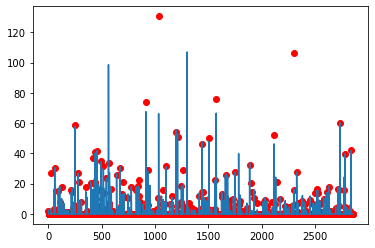

In [45]:
import matplotlib.pyplot as plt
plt.scatter(range(len(y_test)),y_test, color = 'red')
plt.plot(y_pred)
plt.show()

### Fazendo uma breve analise dos eventos de cobrimento da divida!!

In [ ]:
df_inout = pd.read_csv("csvs/meus/cred_vs_deb.csv", sep = ";", names = ['data','a','a1','a11','a111','a1111','a11111','codigo','a2','a22','a222','a2222','valor','conta','a3','a33'])

In [ ]:
df_resumido = df_inout[['data','codigo','valor','conta']]

In [ ]:
display(df_resumido)
df_resumido = df_resumido.sort_values('data')

In [ ]:
for i in range(len(df_resumido.data)):
    if df_resumido.codigo.iloc[i] == 680:
        df_resumido.valor.iloc[i] = - df_resumido.valor.iloc[i]



In [448]:
acumulado = []

contas = set(df_resumido.conta)
for conta in contas:
    soma = 0
    acumulado_por_conta = []
    display(df_resumido.loc[df_resumido.conta == conta])
    for index, row in df_resumido.loc[df_resumido.conta == conta].iterrows():
        soma += row.valor
        data = row.data[2:10]
        acumulado_por_conta.append([soma,data])
#         print(acumulado_por_conta)
    acumulado.append(acumulado_por_conta)

data  codigo    valor   conta
754  2015-07-15 00:00:00.000     680  -429.07  141747
566  2015-11-30 00:00:00.000     680  -347.61  141747
627  2015-12-01 00:00:00.000     680    -5.54  141747
618  2015-12-02 00:00:00.000     680   -27.50  141747
853  2015-12-03 00:00:00.000     680  -500.00  141747
..                       ...     ...      ...     ...
510  2019-11-05 00:00:00.000      80   705.99  141747
536  2019-11-06 00:00:00.000     680 -1258.37  141747
620  2019-11-07 00:00:00.000      80  1035.00  141747
531  2019-11-08 00:00:00.000      80   337.37  141747
739  2019-11-13 00:00:00.000     680 -1250.94  141747

[433 rows x 4 columns]

data  codigo    valor   conta
1550  2017-03-17 00:00:00.000     680  -179.72  958948
1214  2017-03-20 00:00:00.000    5510    20.00  958948
1213  2017-03-20 00:00:00.000      80   179.72  958948
1460  2017-04-03 00:00:00.000     680  -218.86  958948
1311  2017-04-04 00:00:00.000      80   218.86  958948
...                       ...     ...      ...     ...
1372  2019-10-10 00:00:00.000     680  -596.30  958948
1205  2019-10-11 00:00:00.000      80   596.30  958948
1483  2019-11-11 00:00:00.000     680 -2239.61  958948
1415  2019-11-12 00:00:00.000      80  2239.61  958948
1418  2019-11-12 00:00:00.000    5510    60.00  958948

[350 rows x 4 columns]

data  codigo   valor   conta
1113  2015-11-30 00:00:00.000     680 -131.37  396893
1041  2015-12-01 00:00:00.000     680   -0.78  396893
952   2015-12-07 00:00:00.000      80  132.15  396893
951   2015-12-07 00:00:00.000    5510   20.00  396893
970   2015-12-14 00:00:00.000     680 -972.23  396893
...                       ...     ...     ...     ...
1109  2019-10-01 00:00:00.000     680   -8.25  396893
982   2019-10-07 00:00:00.000     680 -386.00  396893
1003  2019-10-10 00:00:00.000    5510  180.00  396893
1065  2019-10-10 00:00:00.000      80  403.18  396893
954   2019-11-07 00:00:00.000     680 -196.18  396893

[290 rows x 4 columns]

data  codigo     valor  conta
452  2015-07-14 00:00:00.000     680   -849.45  25623
56   2015-07-15 00:00:00.000     680   -351.00  25623
144  2015-11-27 00:00:00.000      80  12184.00  25623
360  2015-11-30 00:00:00.000      80    169.65  25623
221  2015-12-01 00:00:00.000      80    715.15  25623
..                       ...     ...       ...    ...
341  2019-11-05 00:00:00.000     680  -1085.11  25623
81   2019-11-05 00:00:00.000    5510    120.00  25623
352  2019-11-08 00:00:00.000      80   1587.46  25623
474  2019-11-12 00:00:00.000     680   -399.46  25623
263  2019-11-13 00:00:00.000      80    399.46  25623

[480 rows x 4 columns]

In [ ]:
print(acumulado)

valor      data
0   -429.07  15-07-15
1   -776.68  15-11-30
2   -782.22  15-12-01
3   -809.72  15-12-02
4  -1309.72  15-12-03
5  -1289.72  15-12-07
6   -409.07  15-12-07
7   -569.61  15-12-08
8   -409.07  15-12-10
9  -5594.72  15-12-14
10  -409.07  15-12-15
11 -1324.15  16-01-08
12  -824.15  16-01-11
13  -409.07  16-01-13
14  -389.07  16-01-13
15  -589.14  16-01-29
16  -595.65  16-02-01
17  -845.65  16-02-02
18  -389.07  16-02-03
19  -769.15  16-02-04
20  -389.07  16-02-05
21  -925.57  16-02-10
22  -389.07  16-02-12
23 -1170.06  16-02-16
24  -389.07  16-02-17
25  -369.07  16-02-17
26 -1109.88  16-02-18
27  -369.07  16-02-19
28  -636.33  16-02-23
29  -369.07  16-02-24
30  -380.74  16-02-29
31  -535.91  16-03-01
32  -369.07  16-03-02
33  -643.27  16-03-10
34  -369.07  16-03-11
35 -1042.15  16-03-16
36  -369.07  16-03-17
37  -349.07  16-03-17
38 -1341.46  16-03-23
39  -349.07  16-03-24
40 -1534.36  16-03-28
41 -3110.36  16-03-29
42  -349.07  16-03-30
43  -532.41  16-03-31
44  -435.15  16-04-01
45  -885.15  16-04-04
46  -349.07  16-04-06
47  -449.70  16-04-08
48  -349.07  16-04-11
49 -1483.83  16-04-20

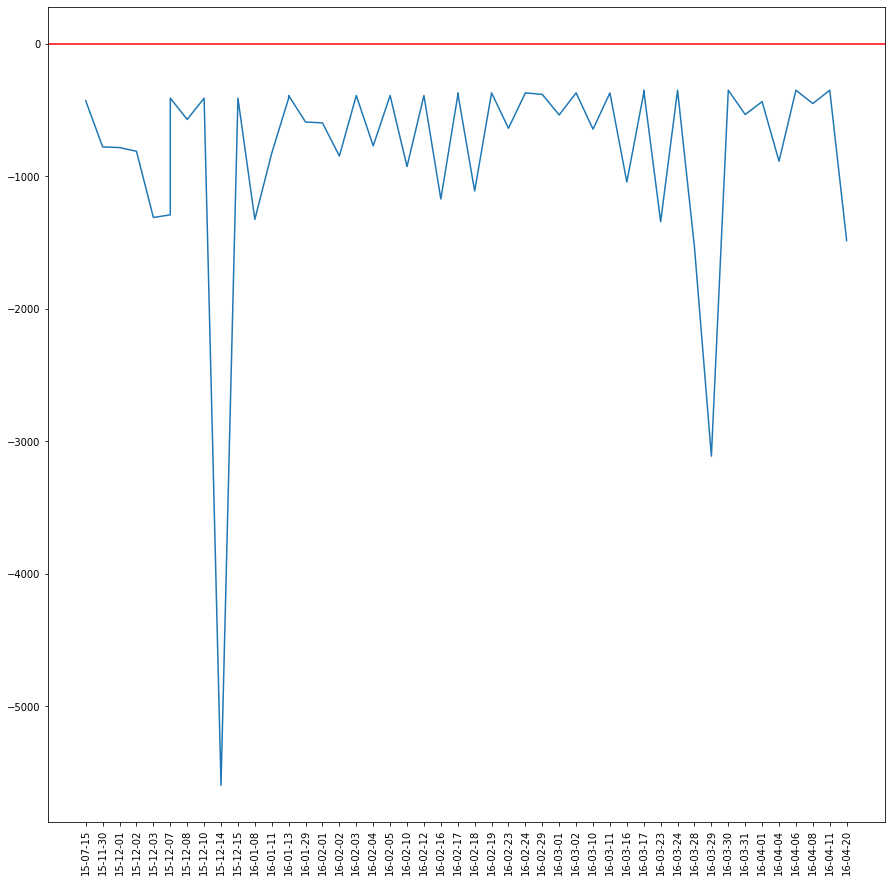

valor      data
0   -179.72  17-03-17
1   -159.72  17-03-20
2     20.00  17-03-20
3   -198.86  17-04-03
4     20.00  17-04-04
5   -398.86  17-04-05
6  -2330.17  17-04-06
7   -427.67  17-04-07
8     20.00  17-04-10
9  -1758.65  17-04-20
10 -1738.65  17-04-24
11    40.00  17-04-24
12 -1101.45  17-04-26
13    40.00  17-04-27
14    17.09  17-04-28
15  -483.89  17-05-02
16  -343.89  17-05-03
17    40.00  17-05-04
18 -1756.91  17-05-09
19    40.00  17-05-10
20 -1206.16  17-05-26
21 -2341.16  17-05-29
22    40.00  17-05-30
23    60.00  17-05-30
24  -348.10  17-05-31
25  -426.03  17-06-01
26 -1090.03  17-06-05
27    60.00  17-06-06
28  -280.97  17-06-12
29    60.00  17-06-13
30 -1041.32  17-06-20
31    60.00  17-06-21
32 -2096.75  17-06-26
33    60.00  17-06-27
34  -326.27  17-06-30
35 -2442.44  17-07-03
36 -3623.44  17-07-04
37    60.00  17-07-05
38    80.00  17-07-05
39  -531.87  17-07-07
40    80.00  17-07-10
41   -56.42  17-07-25
42 -2516.60  17-07-27
43 -1089.60  17-07-28
44  -417.04  17-07-31
45  -461.71  17-08-01
46  -828.21  17-08-03
47    80.00  17-08-04
48  -685.57  17-08-07
49    80.00  17-08-08

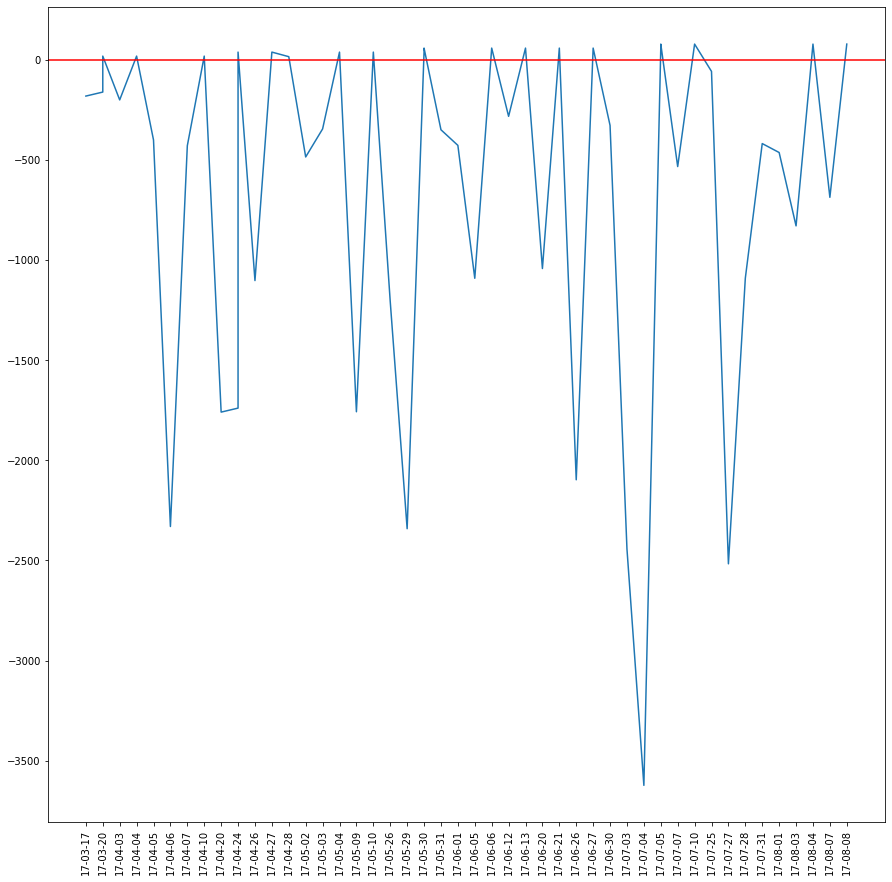

valor      data
0   -131.37  15-11-30
1   -132.15  15-12-01
2      0.00  15-12-07
3     20.00  15-12-07
4   -952.23  15-12-14
5     20.00  15-12-15
6    -19.28  15-12-31
7    -32.00  16-01-04
8  -1120.56  16-01-08
9     20.00  16-01-11
10    40.00  16-01-11
11   -88.60  16-01-29
12   -94.25  16-02-01
13    40.00  16-02-05
14  -106.50  16-02-11
15   -86.50  16-02-15
16    60.00  16-02-15
17  -102.71  16-02-29
18  -111.76  16-03-01
19    60.00  16-03-04
20  -528.15  16-03-07
21  -685.42  16-03-08
22    60.00  16-03-09
23    48.50  16-03-22
24  -151.50  16-03-23
25  -131.50  16-03-24
26    80.00  16-03-24
27   -76.86  16-03-31
28   -81.79  16-04-01
29    80.00  16-04-07
30  -941.79  16-04-11
31    80.00  16-04-13
32   -80.76  16-04-29
33   -87.65  16-05-02
34  -542.52  16-05-06
35   -84.95  16-05-09
36   -64.95  16-05-10
37   100.00  16-05-10
38  -932.33  16-06-07
39 -1011.21  16-06-08
40   100.00  16-06-09
41   120.00  16-06-09
42  -875.30  16-06-14
43   120.00  16-06-15
44   -47.19  16-06-30
45   -55.95  16-07-01
46   120.00  16-07-04
47    81.55  16-07-07
48  -227.58  16-07-08
49  -207.58  16-07-11

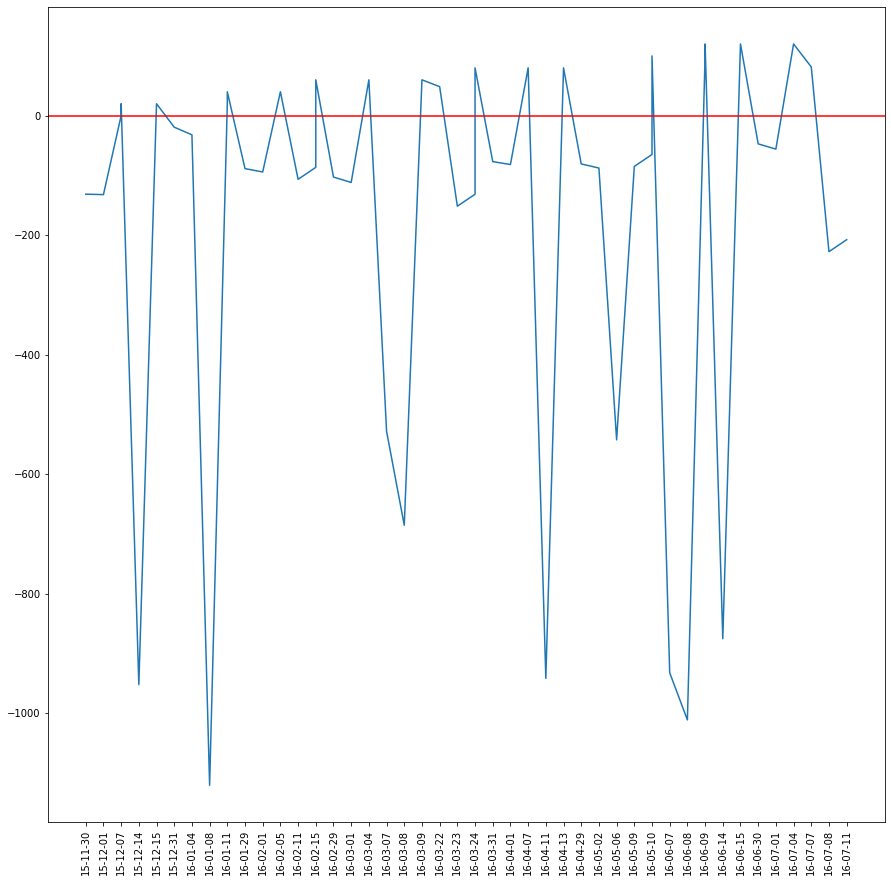

valor      data
0    -849.45  15-07-14
1   -1200.45  15-07-15
2   10983.55  15-11-27
3   11153.20  15-11-30
4   11868.35  15-12-01
5   11888.35  15-12-01
6   10454.38  15-12-14
7    2430.03  15-12-15
8   11888.35  15-12-16
9   11052.13  15-12-21
10   7210.57  15-12-22
11  11888.35  15-12-23
12 -11008.73  15-12-28
13  11609.27  15-12-29
14  11463.57  15-12-30
15  11077.11  15-12-31
16  10936.31  16-01-04
17   8420.31  16-01-05
18  11888.35  16-01-06
19  -6531.74  16-01-11
20  11718.27  16-01-12
21  11888.35  16-01-13
22  11908.35  16-01-13
23   -758.73  16-01-15
24  11531.27  16-01-18
25  11688.27  16-01-19
26  10649.77  16-01-20
27   7668.65  16-01-21
28  11908.35  16-01-22
29   9169.59  16-01-25
30   9830.29  16-01-26
31   6385.29  16-01-27
32  11908.35  16-01-28
33  11242.37  16-01-29
34   6980.75  16-02-01
35  11230.75  16-02-02
36  10460.75  16-02-03
37  11908.35  16-02-04
38  11830.23  16-02-10
39   2699.01  16-02-11
40   7384.37  16-02-12
41  -3894.88  16-02-15
42   9822.12  16-02-16
43  11908.35  16-02-17
44   9938.12  16-02-19
45   6614.72  16-02-22
46   4118.90  16-02-23
47  11537.90  16-02-24
48   6862.90  16-02-25
49   9433.60  16-02-26

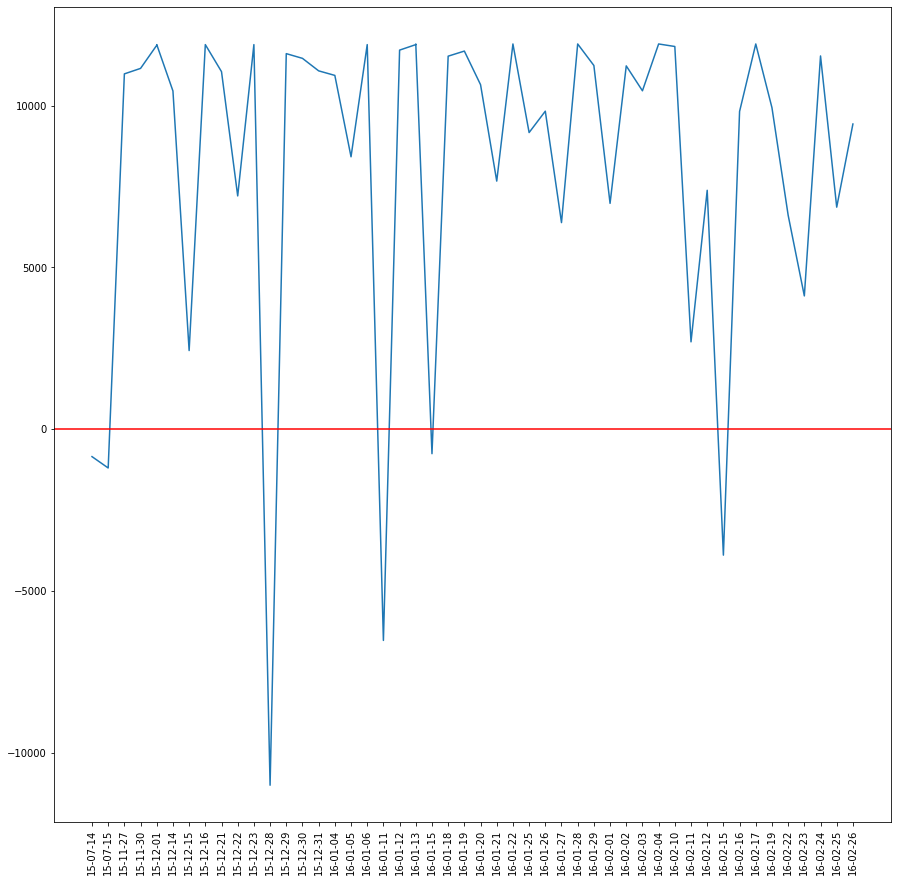

In [453]:
for item in acumulado:
    fig = plt.figure(figsize = (15,15))
    item = pd.DataFrame(item[0:50], columns = ['valor','data'])
    display(item)
    plt.plot(item.data, item.valor)
    plt.axhline(y=0, color = 'red')
    plt.xticks(rotation='vertical')    
    plt.show()